# XCS224U Final Project

## ELECTRA and ChatGPT: Collaborative Approaches to Sentiment Classification

## Initial Setup

### Imports

In [653]:
# OS and utilities
import os
import io
import sys
import time
import pickle
from time import sleep
from datetime import datetime
from dotenv import load_dotenv
import wget
import json
import warnings
from tqdm import tqdm

# Data processing
import pandas as pd
import numpy as np
from collections import defaultdict
from datasets import load_dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report, accuracy_score

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning
import torch
import torch.nn.functional as F
from transformers import AutoModel, AutoTokenizer, ElectraTokenizer
import tiktoken
import openai

# OpenAI
from openai import OpenAI

# DSPy and ReCOGS
import dsp
import dspy
from dspy.evaluate.evaluate import Evaluate
from compgen import recogs_exact_match
from dspy import Retrieve

# Instrumentation and tracing
from phoenix.otel import register
from openinference.instrumentation.dspy import DSPyInstrumentor

# Typing
from typing import List, Union, Optional

# Local imports
from datawaza_funcs import eval_model
from utils import fix_random_seeds, prepare_device, setup_environment


### Environment and Preferences

In [2]:
# DSPy notebook cache
root_path = '.'
os.environ["DSP_NOTEBOOK_CACHEDIR"] = os.path.join(root_path, 'cache')

# Pandas display options
pd.set_option('display.max_colwidth', None)

In [36]:
# Suppress specific warnings
warnings.filterwarnings("ignore", message="resume_download is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use force_download=True.", category=FutureWarning)
warnings.filterwarnings("ignore", message="`resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.", category=FutureWarning)


### API Keys

In [3]:
# Load API keys
load_dotenv()
openai_key = os.getenv('OPENAI_API_KEY')
arize_key = os.getenv('ARIZE_API_KEY')

### Language Model

In [27]:
# Create OpenAI client
client = OpenAI()
models = client.models.list()

# Print OpenAI models by creation date
sorted_models = sorted(models.dict()['data'], key=lambda x: x['created'], reverse=True)
print(f"{'Model ID':<40}{'Creation Date':<40}")
print('-'*80)
for model in sorted_models:
    if not model['id'].startswith('ft:'):
        print(f"{model['id']:<40}{datetime.fromtimestamp(int(model['created'])).strftime('%Y-%m-%d %H:%M:%S'):<40}")


Model ID                                Creation Date                           
--------------------------------------------------------------------------------
gpt-4o-realtime-preview                 2024-09-30 01:33:18                     
gpt-4o-audio-preview                    2024-09-27 18:07:23                     
gpt-4o-audio-preview-2024-10-01         2024-09-26 22:17:22                     
gpt-4o-realtime-preview-2024-10-01      2024-09-23 22:49:26                     
o1-mini                                 2024-09-06 18:56:48                     
o1-mini-2024-09-12                      2024-09-06 18:56:19                     
o1-preview                              2024-09-06 18:54:57                     
o1-preview-2024-09-12                   2024-09-06 18:54:25                     
chatgpt-4o-latest                       2024-08-13 02:12:11                     
gpt-4o-2024-08-06                       2024-08-04 23:38:39                     
gpt-4o-mini                 

In [28]:
# Print the fine-tuned models
print(f"{'Model ID':<40}{'Creation Date':<40}")
print('-'*80)
for model in sorted_models:
    if model['id'].startswith('ft:'):
        print(f"{model['id']:<40}{datetime.fromtimestamp(int(model['created'])).strftime('%Y-%m-%d %H:%M:%S'):<40}")

Model ID                                Creation Date                           
--------------------------------------------------------------------------------
ft:gpt-4o-2024-08-06:personal::AM5cgCGf:ckpt-step-15012024-10-25 03:49:54                     
ft:gpt-4o-2024-08-06:personal::AM5cg622 2024-10-25 03:49:54                     
ft:gpt-4o-mini-2024-07-18:personal::ALnBCEST:ckpt-step-15012024-10-24 08:08:18                     
ft:gpt-4o-mini-2024-07-18:personal::ALnBCKLv2024-10-24 08:08:18                     
ft:gpt-4o-mini-2024-07-18:personal::AAC6TH6s:ckpt-step-15062024-09-22 08:19:30                     
ft:gpt-4o-mini-2024-07-18:personal::AAC6UAgP2024-09-22 08:19:30                     


In [5]:
# Define the language model
lm = dspy.OpenAI(model='gpt-4o-mini-2024-07-18', api_key=openai_key, max_tokens=8192)
dspy.settings.configure(lm=lm, experimental=True)

### Arize Phoenix for Traces

In [6]:
# Arize environment variables
os.environ["OTEL_EXPORTER_OTLP_HEADERS"] = f"api_key={arize_key}"
os.environ["PHOENIX_CLIENT_HEADERS"] = f"api_key={arize_key}"
os.environ["PHOENIX_COLLECTOR_ENDPOINT"] = "https://app.phoenix.arize.com"

In [7]:
# Register the tracer provider
tracer_provider = register(
  project_name="final_project",
  endpoint="https://app.phoenix.arize.com/v1/traces",
  headers={"api_key": f"{arize_key}"}
)

🔭 OpenTelemetry Tracing Details 🔭
|  Phoenix Project: final_project
|  Span Processor: SimpleSpanProcessor
|  Collector Endpoint: https://app.phoenix.arize.com/v1/traces
|  Transport: HTTP
|  Transport Headers: {'api_key': '****'}
|  
|  Using a default SpanProcessor. `add_span_processor` will overwrite this default.
|  
|  `register` has set this TracerProvider as the global OpenTelemetry default.
|  To disable this behavior, call `register` with `set_global_tracer=False`.



In [8]:
# Start the DSPy instrumentor
DSPyInstrumentor().instrument(tracer_provider=tracer_provider)

## Sentiment Data

The dataset is a merge of DynaSent R1, DynaSent R2, and SST-3.

In [410]:
# Load the merged datasets
train_df = pd.read_csv('data/merged/train_all.csv')
val_df = pd.read_csv('data/merged/val_all.csv')
test_df = pd.read_csv('data/merged/test_all.csv')

In [411]:
# Print the lengths of each dataset
print(f"Train: {len(train_df)}")
print(f"Validation: {len(val_df)}")
print(f"Test: {len(test_df)}")

Train: 102097
Validation: 5421
Test: 6530


In [412]:
# Review the train dataset
train_df.head()

,sentence,label,source,split
0,Those 2 drinks are part of the HK culture and has years of history. It is so bad.,negative,dynasent_r2,train
1,"I was told by the repair company that was doing the car repair that fixing the rim was ""impossible"" and to replace it.",negative,dynasent_r1,train
2,It is there to give them a good time .,neutral,sst_local,train
3,Like leafing through an album of photos accompanied by the sketchiest of captions .,negative,sst_local,train
4,Johnny was a talker and liked to have fun.,positive,dynasent_r1,train


In [413]:
# Creat a list of dspy.Example objects from train_df
train_ex = [dspy.Example(review=row['sentence'], classification=row['label']).with_inputs('review') for _, row in train_df.iterrows()]
val_ex = [dspy.Example(review=row['sentence'], classification=row['label']).with_inputs('review') for _, row in val_df.iterrows()]
test_ex = [dspy.Example(review=row['sentence'], classification=row['label']).with_inputs('review') for _, row in test_df.iterrows()]

In [414]:
# Review the first few examples
train_ex[:5]

[Example({'review': 'Those 2 drinks are part of the HK culture and has years of history. It is so bad.', 'classification': 'negative'}) (input_keys={'review'}),
 Example({'review': 'I was told by the repair company that was doing the car repair that fixing the rim was "impossible" and to replace it.', 'classification': 'negative'}) (input_keys={'review'}),
 Example({'review': 'It is there to give them a good time .', 'classification': 'neutral'}) (input_keys={'review'}),
 Example({'review': 'Like leafing through an album of photos accompanied by the sketchiest of captions .', 'classification': 'negative'}) (input_keys={'review'}),
 Example({'review': 'Johnny was a talker and liked to have fun.', 'classification': 'positive'}) (input_keys={'review'})]

## ELECTRA Models

### Setup DDP Environment

I fine-tuned my models in a DDP multi-GPU environment using `ddp_sentiment_finetune.py`. Because I'm loading a checkpoint from that pipele, which has a DDP wrapper, I'm runninig some minimal functions here to setup a basic single-GPU DDP environemnt.

In [37]:
# Set some variables for the DDP environment
rank = 0
device_type = 'cuda'
world_size = 1
backend = 'nccl'
debug = False
random_seed = 42

In [39]:
# Define the device
device = prepare_device(rank, device_type)

In [40]:
# Initiate the process group
setup_environment(rank, world_size, backend, device, debug)

Rank 0 - Device: cuda:0
1 process groups initialized with 'nccl' backend on localhost:12355
NCCL Timeout: 1 hr 0 min. NCCL Blocking Wait: Enabled


In [41]:
# Set random seeds
fix_random_seeds(random_seed)

### Load ELECTRA Tokenizer and Fine-Tuned Model

We'll load an ELECTRA model that was fine-tuned on sentiment using `ddp_sentiment_finetune.py`. This will be part of our DSPy module's forward pass. We'll get the ELECTRA classification for the review, and that will be input/context in the prompt for the GPT4o-mini language model.

In [68]:
# Load the ELECTRA tokenizer from Hugging Face
tokenizer = ElectraTokenizer.from_pretrained('google/electra-large-discriminator')

In [44]:
# Function to unpickle the checkpoint saved with DDP and GPUs
class CPU_Unpickler(pickle.Unpickler):
    def find_class(self, module, name):
        if module == 'torch.storage' and name == '_load_from_bytes':
            return lambda b: torch.load(io.BytesIO(b), map_location='cpu')
        else: return super().find_class(module, name)

In [45]:
# Load the ELECTRA Large model from a checkpoint pickle file
with open('research/final_model_20241025-024222.pkl', 'rb') as f:
    electra_large_model = CPU_Unpickler(f).load()

In [46]:
# Move the model to the device (GPU ideally) to speed up inference time
electra_large_model.to(device)

TorchDDPNeuralClassifier(
	batch_size=16,
	max_iter=50,
	eta=1e-05,
	optimizer_class=<class 'torch.optim.adamw.AdamW'>,
	l2_strength=0.01,
	gradient_accumulation_steps=2,
	max_grad_norm=None,
	validation_fraction=0.1,
	early_stopping=score,
	n_iter_no_change=10,
	warm_start=False,
	tol=1e-05,
	finetune_bert=True,
	pooling=mean,
	hidden_dim=1024,
	hidden_activation=SwishGLU(
  (projection): Linear(in_features=1024, out_features=2048, bias=True)
  (activation): SiLU()
),
	num_layers=2,
	checkpoint_interval=1,
	target_score=None,
	interactive=True,
	freeze_bert=False,
	dropout_rate=0.3,
	show_progress=True,
	advance_epochs=1,
	use_zero=True,
	scheduler_class=<class 'torch.optim.lr_scheduler.CosineAnnealingWarmRestarts'>)

In [47]:
# Review the ELECTRA Large model with custom pooling and classifier head
electra_large_model.model

DistributedDataParallel(
  (module): BERTClassifier(
    (bert): ElectraModel(
      (embeddings): ElectraEmbeddings(
        (word_embeddings): Embedding(30522, 1024, padding_idx=0)
        (position_embeddings): Embedding(512, 1024)
        (token_type_embeddings): Embedding(2, 1024)
        (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): ElectraEncoder(
        (layer): ModuleList(
          (0-23): 24 x ElectraLayer(
            (attention): ElectraAttention(
              (self): ElectraSelfAttention(
                (query): Linear(in_features=1024, out_features=1024, bias=True)
                (key): Linear(in_features=1024, out_features=1024, bias=True)
                (value): Linear(in_features=1024, out_features=1024, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): ElectraSelfOutput(
                (dense): Linear(in_featu

In [69]:
# Load the ELECTRA Base model from a checkpoint pickle file
with open('research/final_model_20241026-053505.pkl', 'rb') as f:
    electra_base_model = CPU_Unpickler(f).load()

In [70]:
# Move the model to the device (GPU ideally) to speed up inference time
electra_base_model.to(device)

TorchDDPNeuralClassifier(
	batch_size=16,
	max_iter=50,
	eta=1e-05,
	optimizer_class=<class 'torch.optim.adamw.AdamW'>,
	l2_strength=0.01,
	gradient_accumulation_steps=2,
	max_grad_norm=None,
	validation_fraction=0.1,
	early_stopping=score,
	n_iter_no_change=10,
	warm_start=False,
	tol=1e-05,
	finetune_bert=True,
	pooling=mean,
	hidden_dim=1024,
	hidden_activation=SwishGLU(
  (projection): Linear(in_features=1024, out_features=2048, bias=True)
  (activation): SiLU()
),
	num_layers=2,
	checkpoint_interval=1,
	target_score=None,
	interactive=True,
	freeze_bert=False,
	dropout_rate=0.3,
	show_progress=True,
	advance_epochs=1,
	use_zero=True,
	scheduler_class=<class 'torch.optim.lr_scheduler.CosineAnnealingWarmRestarts'>)

In [71]:
# Review the ELECTRA Base model with custom pooling and classifier head
electra_base_model.model

DistributedDataParallel(
  (module): BERTClassifier(
    (bert): ElectraModel(
      (embeddings): ElectraEmbeddings(
        (word_embeddings): Embedding(30522, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (token_type_embeddings): Embedding(2, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): ElectraEncoder(
        (layer): ModuleList(
          (0-11): 12 x ElectraLayer(
            (attention): ElectraAttention(
              (self): ElectraSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): ElectraSelfOutput(
                (dense): Linear(in_features=768, o

### ELECTRA Prediction Functions

In [48]:
# Set the class label mapping dictionary
numeric_dict = {0: 'negative', 1: 'neutral', 2: 'positive'}

In [49]:
# Tokenize function
def tokenize(texts, tokenizer, device):
    encoded = tokenizer.batch_encode_plus(
        texts,
        add_special_tokens=True,
        padding='max_length',
        truncation=True,
        max_length=512,
        return_tensors="pt"
    )
    input_ids = encoded['input_ids'].to(device)
    attention_mask = encoded['attention_mask'].to(device)
    
    return input_ids, attention_mask

In [50]:
# Function to predict the class of a sentence
def predict_sentence(model, sentence, tokenizer, numeric_dict):

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.model
    
    # Tokenize the input sentence
    input_ids, attention_mask = tokenize([sentence], tokenizer, device)

    # Set the model to evaluation mode
    model.eval()

    # Perform inference
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)

    # Get the predictions
    if isinstance(outputs, torch.Tensor):
        logits = outputs
    elif hasattr(outputs, 'logits'):
        logits = outputs.logits
    else:
        logits = outputs[0]

    probabilities = torch.softmax(logits, dim=1)
    predicted_class = torch.argmax(probabilities, dim=1).item()
    predicted_label = numeric_dict[predicted_class]

    # Move probabilities back to CPU and convert to list
    probabilities = probabilities.cpu().squeeze().tolist()

    # Free up GPU memory
    del input_ids, attention_mask, logits, outputs
    torch.cuda.empty_cache()

    return predicted_class, predicted_label, probabilities

### Creating ELECTRA Train Predictions for GPT fine-tuning

In [292]:
test_review = "Those 2 drinks are part of the HK culture and has years of history. It is so bad."

In [293]:
# Test prediction with ELECTRA base model
predict_sentence(electra_base_model, test_review, tokenizer, numeric_dict)

(0,
 'negative',
 [0.9988487958908081, 0.0008097602985799313, 0.0003413360973354429])

In [294]:
# Test prediction with ELECTRA large model
predict_sentence(electra_large_model, test_review, tokenizer, numeric_dict)

(0,
 'negative',
 [0.9984808564186096, 0.0003502856707200408, 0.0011688611702993512])

In [415]:
train_df.head()

,sentence,label,source,split
0,Those 2 drinks are part of the HK culture and has years of history. It is so bad.,negative,dynasent_r2,train
1,"I was told by the repair company that was doing the car repair that fixing the rim was ""impossible"" and to replace it.",negative,dynasent_r1,train
2,It is there to give them a good time .,neutral,sst_local,train
3,Like leafing through an album of photos accompanied by the sketchiest of captions .,negative,sst_local,train
4,Johnny was a talker and liked to have fun.,positive,dynasent_r1,train


In [295]:
def add_electra_predictions(df, electra_base_model, electra_large_model, tokenizer_base, tokenizer_large, numeric_dict):
    """
    Add ELECTRA base and large model predictions to the DataFrame with tqdm progress bar
    
    Parameters:
    df: pandas DataFrame containing the 'sentence' column
    electra_base_model: ELECTRA base model instance
    electra_large_model: ELECTRA large model instance
    tokenizer_base: tokenizer for base model
    tokenizer_large: tokenizer for large model
    numeric_dict: dictionary mapping numeric labels to text labels
    
    Returns:
    DataFrame with added prediction columns
    """
    # Create copies of the predictions to avoid modifying the original
    df = df.copy()
    
    # Initialize new columns
    df['electra_base_prediction'] = ''
    df['electra_base_probabilities'] = None
    df['electra_large_prediction'] = ''
    df['electra_large_probabilities'] = None
    
    # Create tqdm progress bar
    pbar = tqdm(df.iterrows(), total=len(df), desc="Processing sentences")
    
    # Process each sentence
    for idx, row in pbar:
        # Get predictions from base model
        _, base_label, base_probs = predict_sentence(
            electra_base_model, 
            row['sentence'],
            tokenizer_base,
            numeric_dict
        )
        
        # Get predictions from large model
        _, large_label, large_probs = predict_sentence(
            electra_large_model,
            row['sentence'],
            tokenizer_large,
            numeric_dict
        )
        
        # Store predictions and probabilities
        df.at[idx, 'electra_base_prediction'] = base_label
        df.at[idx, 'electra_base_probabilities'] = base_probs
        df.at[idx, 'electra_large_prediction'] = large_label
        df.at[idx, 'electra_large_probabilities'] = large_probs
        
        # Update progress bar description with current predictions
        pbar.set_postfix({
            'Base': base_label,
            'Large': large_label
        })
    
    return df

In [244]:
train_with_electra_preds_df = add_electra_predictions(
    df=train_df,
    electra_base_model=electra_base_model,
    electra_large_model=electra_large_model,
    tokenizer_base=electra_base_model.bert_tokenizer,
    tokenizer_large=electra_large_model.bert_tokenizer,
    numeric_dict=numeric_dict
)

Processing sentences:   0%|          | 0/102097 [00:00<?, ?it/s]

In [245]:
train_with_electra_preds_df.to_csv('research/train_with_electra_preds.csv', index=False)

In [318]:
train_with_electra_preds_df.head()

,sentence,label,source,split,electra_base_prediction,electra_base_probabilities,electra_large_prediction,electra_large_probabilities
0,Those 2 drinks are part of the HK culture and has years of history. It is so bad.,negative,dynasent_r2,train,negative,"[0.9988487958908081, 0.0008097602985799313, 0.0003413360973354429]",negative,"[0.9984808564186096, 0.0003502856707200408, 0.0011688611702993512]"
1,"I was told by the repair company that was doing the car repair that fixing the rim was ""impossible"" and to replace it.",negative,dynasent_r1,train,negative,"[0.750698447227478, 0.24390113353729248, 0.005400347523391247]",negative,"[0.930504322052002, 0.06783030182123184, 0.0016653756611049175]"
2,It is there to give them a good time .,neutral,sst_local,train,neutral,"[0.016632072627544403, 0.7018547654151917, 0.28151315450668335]",neutral,"[0.010434377938508987, 0.6591203808784485, 0.33044523000717163]"
3,Like leafing through an album of photos accompanied by the sketchiest of captions .,negative,sst_local,train,negative,"[0.9957066178321838, 0.002995532238855958, 0.001297850627452135]",negative,"[0.9150474667549133, 0.08219709247350693, 0.002755437046289444]"
4,Johnny was a talker and liked to have fun.,positive,dynasent_r1,train,positive,"[0.0001658612600294873, 0.1131131649017334, 0.8867210149765015]",positive,"[0.0010451035341247916, 0.23813723027706146, 0.7608176469802856]"


In [305]:
val_with_electra_preds_df = add_electra_predictions(
    df=val_df,
    electra_base_model=electra_base_model,
    electra_large_model=electra_large_model,
    tokenizer_base=electra_base_model.bert_tokenizer,
    tokenizer_large=electra_large_model.bert_tokenizer,
    numeric_dict=numeric_dict
)

Processing sentences: 100%|██████████| 5421/5421 [11:53<00:00,  7.60it/s, Base=neutral, Large=neutral]  


In [306]:
val_with_electra_preds_df.to_csv('research/val_with_electra_preds.csv', index=False)

In [319]:
val_with_electra_preds_df.head()

,sentence,label,source,split,electra_base_prediction,electra_base_probabilities,electra_large_prediction,electra_large_probabilities
0,Found Thai Spoon on the Vegan Pittsburgh website.,neutral,dynasent_r1,validation,neutral,"[0.00018192018615081906, 0.9930110573768616, 0.006806982681155205]",neutral,"[0.0002572769590187818, 0.9571502208709717, 0.04259249195456505]"
1,Our bill came out to around $27 and we ate like the wealthy.,positive,dynasent_r1,validation,positive,"[0.16897831857204437, 0.03550531715154648, 0.7955163717269897]",positive,"[0.004331634845584631, 0.0017557682003825903, 0.9939125776290894]"
2,State Farm broke down the costs for me of the parts and labor.,neutral,dynasent_r1,validation,neutral,"[0.00011470958270365372, 0.9811069965362549, 0.01877826452255249]",neutral,"[0.00047532867756672204, 0.9276981949806213, 0.0718264952301979]"
3,The only con for this resto is the wait to get a seat.,negative,dynasent_r1,validation,negative,"[0.9464658498764038, 0.015969356521964073, 0.03756479173898697]",negative,"[0.9962604641914368, 0.00046653527533635497, 0.0032729844097048044]"
4,We could hear the people above us stomping around even after midnight.,negative,dynasent_r1,validation,negative,"[0.7719284296035767, 0.21691103279590607, 0.011160519905388355]",negative,"[0.9870899319648743, 0.005847276654094458, 0.007062854245305061]"


## Fine-Tune GPT Models

### A: DSPy Prompt

#### Convert Train Data to DSPy Prompt

In [308]:
# Function to convert training data to chat format, with the same DSPy prompt
def convert_to_chat_format(df, output_file):
    """
    Convert training data to match DSPy signature format for GPT-4o-mini fine-tuning
    
    Parameters:
    df: pandas DataFrame containing 'sentence' and 'label' columns
    output_file: path to save the JSONL output file
    """
    with open(output_file, 'w') as f:
        pbar = tqdm(df.iterrows(), total=len(df), desc="Converting to chat format")
        
        for _, row in pbar:
            prompt = f"""Classify the sentiment of a review as either 'negative', 'neutral', or 'positive'.

---

Follow the following format.

Review: The review text to classify.
Classification: One word representing the sentiment classification: 'negative', 'neutral', or 'positive' (do not repeat the field name, do not use 'mixed')

---

Review: {row['sentence']}
Classification:"""
            
            chat_record = {
                "messages": [
                    {
                        "role": "system",
                        "content": "You are a sentiment analysis assistant."
                    },
                    {
                        "role": "user",
                        "content": prompt
                    },
                    {
                        "role": "assistant",
                        "content": row['label']
                    }
                ]
            }
            json.dump(chat_record, f)
            f.write('\n')
            
            pbar.set_postfix({
                'Label': row['label']
            })

In [283]:
# Convert the train dataset to chat format for fine-tuning
convert_to_chat_format(train_df, 'sentiment_merged_chat_train.jsonl')
convert_to_chat_format(val_df, 'sentiment_merged_chat_val.jsonl')

Converting to chat format: 100%|██████████| 5421/5421 [00:03<00:00, 1673.01it/s, Label=neutral] 


#### Load Training and Validation JSONL Data

In [284]:
# Path to the jsonl datasets
train_path = "sentiment_merged_chat_train.jsonl"
val_path = "sentiment_merged_chat_val.jsonl"

# Load the datasets
with open(train_path, 'r', encoding='utf-8') as f:
    train_data = [json.loads(line) for line in f]

with open(val_path, 'r', encoding='utf-8') as f:
    val_data = [json.loads(line) for line in f]

print(f"Training examples: {len(train_data)}")
print(f"Validation examples: {len(val_data)}")

Training examples: 102097
Validation examples: 5421


#### Validate JSONL Files

In [285]:
# Path to the training dataset
data_path = "sentiment_merged_chat_train.jsonl"

# Load the dataset
with open(data_path, 'r', encoding='utf-8') as f:
    jsonl_data = [json.loads(line) for line in f]

# Initial dataset stats
print("Num examples:", len(jsonl_data))
print("First example:")
for message in jsonl_data[0]["messages"]:
    print(message)

Num examples: 102097
First example:
{'role': 'system', 'content': 'You are a sentiment analysis assistant.'}
{'role': 'user', 'content': "Classify the sentiment of a review as either 'negative', 'neutral', or 'positive'.\n\n---\n\nFollow the following format.\n\nReview: The review text to classify.\nClassification: One word representing the sentiment classification: 'negative', 'neutral', or 'positive' (do not repeat the field name, do not use 'mixed')\n\n---\n\nReview: Those 2 drinks are part of the HK culture and has years of history. It is so bad.\nClassification:"}
{'role': 'assistant', 'content': 'negative'}


In [286]:
# Format error checks
format_errors = defaultdict(int)

for ex in jsonl_data:
    if not isinstance(ex, dict):
        format_errors["data_type"] += 1
        continue
        
    messages = ex.get("messages", None)
    if not messages:
        format_errors["missing_messages_list"] += 1
        continue
        
    for message in messages:
        if "role" not in message or "content" not in message:
            format_errors["message_missing_key"] += 1
        
        if any(k not in ("role", "content", "name", "function_call", "weight") for k in message):
            format_errors["message_unrecognized_key"] += 1
        
        if message.get("role", None) not in ("system", "user", "assistant", "function"):
            format_errors["unrecognized_role"] += 1
            
        content = message.get("content", None)
        function_call = message.get("function_call", None)
        
        if (not content and not function_call) or not isinstance(content, str):
            format_errors["missing_content"] += 1
    
    if not any(message.get("role", None) == "assistant" for message in messages):
        format_errors["example_missing_assistant_message"] += 1

if format_errors:
    print("Found errors:")
    for k, v in format_errors.items():
        print(f"{k}: {v}")
else:
    print("No errors found")

No errors found


#### Calculate Statistics

In [287]:
# Define the encoding
encoding = tiktoken.get_encoding("cl100k_base")

# not exact!
# simplified from https://github.com/openai/openai-cookbook/blob/main/examples/How_to_count_tokens_with_tiktoken.ipynb
def num_tokens_from_messages(messages, tokens_per_message=3, tokens_per_name=1):
    num_tokens = 0
    for message in messages:
        num_tokens += tokens_per_message
        for key, value in message.items():
            num_tokens += len(encoding.encode(value))
            if key == "name":
                num_tokens += tokens_per_name
    num_tokens += 3
    return num_tokens

def num_assistant_tokens_from_messages(messages):
    num_tokens = 0
    for message in messages:
        if message["role"] == "assistant":
            num_tokens += len(encoding.encode(message["content"]))
    return num_tokens

def print_distribution(values, name):
    print(f"\n#### Distribution of {name}:")
    print(f"min / max: {min(values)}, {max(values)}")
    print(f"mean / median: {np.mean(values)}, {np.median(values)}")
    print(f"p5 / p95: {np.quantile(values, 0.1)}, {np.quantile(values, 0.9)}")

In [288]:
# Warnings and tokens counts
n_missing_system = 0
n_missing_user = 0
n_messages = []
convo_lens = []
assistant_message_lens = []

for ex in jsonl_data:
    messages = ex["messages"]
    if not any(message["role"] == "system" for message in messages):
        n_missing_system += 1
    if not any(message["role"] == "user" for message in messages):
        n_missing_user += 1
    n_messages.append(len(messages))
    convo_lens.append(num_tokens_from_messages(messages))
    assistant_message_lens.append(num_assistant_tokens_from_messages(messages))
    
print("Num examples missing system message:", n_missing_system)
print("Num examples missing user message:", n_missing_user)
print_distribution(n_messages, "num_messages_per_example")
print_distribution(convo_lens, "num_total_tokens_per_example")
print_distribution(assistant_message_lens, "num_assistant_tokens_per_example")
n_too_long = sum(l > 16385 for l in convo_lens)
print(f"\n{n_too_long} examples may be over the 16,385 token limit, they will be truncated during fine-tuning")

Num examples missing system message: 0
Num examples missing user message: 0

#### Distribution of num_messages_per_example:
min / max: 3, 3
mean / median: 3.0, 3.0
p5 / p95: 3.0, 3.0

#### Distribution of num_total_tokens_per_example:
min / max: 96, 751
mean / median: 110.59470895325035, 109.0
p5 / p95: 100.0, 123.0

#### Distribution of num_assistant_tokens_per_example:
min / max: 1, 1
mean / median: 1.0, 1.0
p5 / p95: 1.0, 1.0

0 examples may be over the 16,385 token limit, they will be truncated during fine-tuning


In [289]:
# Pricing and default n_epochs estimate
MAX_TOKENS_PER_EXAMPLE = 16385

TARGET_EPOCHS = 3
MIN_TARGET_EXAMPLES = 100
MAX_TARGET_EXAMPLES = 135546
MIN_DEFAULT_EPOCHS = 1
MAX_DEFAULT_EPOCHS = 5

n_epochs = TARGET_EPOCHS
n_train_examples = len(jsonl_data)
if n_train_examples * TARGET_EPOCHS < MIN_TARGET_EXAMPLES:
    n_epochs = min(MAX_DEFAULT_EPOCHS, MIN_TARGET_EXAMPLES // n_train_examples)
elif n_train_examples * TARGET_EPOCHS > MAX_TARGET_EXAMPLES:
    n_epochs = max(MIN_DEFAULT_EPOCHS, MAX_TARGET_EXAMPLES // n_train_examples)

n_billing_tokens_in_dataset = sum(min(MAX_TOKENS_PER_EXAMPLE, length) for length in convo_lens)
print(f"Dataset has ~{n_billing_tokens_in_dataset} tokens that will be charged for during training")
print(f"By default, you'll train for {n_epochs} epochs on this dataset")
print(f"By default, you'll be charged for ~{n_epochs * n_billing_tokens_in_dataset} tokens")

Dataset has ~11291388 tokens that will be charged for during training
By default, you'll train for 1 epochs on this dataset
By default, you'll be charged for ~11291388 tokens


### B: DSPy Prompt w/ELECTRA Pred (Base)

#### Convert Train Data to DSPy Prompt w/ELECTRA Prediction

In [309]:
# Function to convert training data to chat format, with the same DSPy prompt
def convert_to_chat_format_with_pred(df, output_file):
    """
    Convert training data to match DSPy signature format for GPT-4o-mini fine-tuning
    
    Parameters:
    df: pandas DataFrame containing 'sentence' and 'label' columns
    output_file: path to save the JSONL output file
    """
    with open(output_file, 'w') as f:
        pbar = tqdm(df.iterrows(), total=len(df), desc="Converting to chat format")
        
        for _, row in pbar:
            prompt = f"""Classify the sentiment of a review as either 'negative', 'neutral', or 'positive'.

---

Follow the following format.

Review: The review text to classify.
Classifier Decision: The sentiment classification proposed by a model fine-tuned on sentiment.
Classification: One word representing the sentiment classification: 'negative', 'neutral', or 'positive' (do not repeat the field name, do not use 'mixed')

---

Review: {row['sentence']}
Classifier Decision: {row['electra_base_prediction']}
Classification:"""
            
            chat_record = {
                "messages": [
                    {
                        "role": "system",
                        "content": "You are a sentiment analysis assistant."
                    },
                    {
                        "role": "user",
                        "content": prompt
                    },
                    {
                        "role": "assistant",
                        "content": row['label']
                    }
                ]
            }
            json.dump(chat_record, f)
            f.write('\n')
            
            pbar.set_postfix({
                'Label': row['label']
            })

In [310]:
# Convert the train dataset to chat format for fine-tuning
convert_to_chat_format_with_pred(train_with_electra_preds_df, 'sentiment_merged_chat_train_base_preds.jsonl')
convert_to_chat_format_with_pred(val_with_electra_preds_df, 'sentiment_merged_chat_val_base_preds.jsonl')

Converting to chat format: 100%|██████████| 5421/5421 [00:03<00:00, 1626.10it/s, Label=neutral] 


#### Load Training and Validation JSONL Data

In [311]:
# Path to the jsonl datasets
train_path = "sentiment_merged_chat_train_base_preds.jsonl"
val_path = "sentiment_merged_chat_val_base_preds.jsonl"

# Load the datasets
with open(train_path, 'r', encoding='utf-8') as f:
    train_data = [json.loads(line) for line in f]

with open(val_path, 'r', encoding='utf-8') as f:
    val_data = [json.loads(line) for line in f]

print(f"Training examples: {len(train_data)}")
print(f"Validation examples: {len(val_data)}")

Training examples: 102097
Validation examples: 5421


#### Validate JSONL Files

In [312]:
# Path to the training dataset
data_path = "sentiment_merged_chat_train_base_preds.jsonl"

# Load the dataset
with open(data_path, 'r', encoding='utf-8') as f:
    jsonl_data = [json.loads(line) for line in f]

# Initial dataset stats
print("Num examples:", len(jsonl_data))
print("First example:")
for message in jsonl_data[0]["messages"]:
    print(message)

Num examples: 102097
First example:
{'role': 'system', 'content': 'You are a sentiment analysis assistant.'}
{'role': 'user', 'content': "Classify the sentiment of a review as either 'negative', 'neutral', or 'positive'.\n\n---\n\nFollow the following format.\n\nReview: The review text to classify.\nClassifier Decision: The sentiment classification proposed by a model fine-tuned on sentiment.\nClassification: One word representing the sentiment classification: 'negative', 'neutral', or 'positive' (do not repeat the field name, do not use 'mixed')\n\n---\n\nReview: Those 2 drinks are part of the HK culture and has years of history. It is so bad.\nClassifier Decision: negative\nClassification:"}
{'role': 'assistant', 'content': 'negative'}


In [313]:
# Format error checks
format_errors = defaultdict(int)

for ex in jsonl_data:
    if not isinstance(ex, dict):
        format_errors["data_type"] += 1
        continue
        
    messages = ex.get("messages", None)
    if not messages:
        format_errors["missing_messages_list"] += 1
        continue
        
    for message in messages:
        if "role" not in message or "content" not in message:
            format_errors["message_missing_key"] += 1
        
        if any(k not in ("role", "content", "name", "function_call", "weight") for k in message):
            format_errors["message_unrecognized_key"] += 1
        
        if message.get("role", None) not in ("system", "user", "assistant", "function"):
            format_errors["unrecognized_role"] += 1
            
        content = message.get("content", None)
        function_call = message.get("function_call", None)
        
        if (not content and not function_call) or not isinstance(content, str):
            format_errors["missing_content"] += 1
    
    if not any(message.get("role", None) == "assistant" for message in messages):
        format_errors["example_missing_assistant_message"] += 1

if format_errors:
    print("Found errors:")
    for k, v in format_errors.items():
        print(f"{k}: {v}")
else:
    print("No errors found")

No errors found


#### Calculate Statistics

In [314]:
# Warnings and tokens counts
n_missing_system = 0
n_missing_user = 0
n_messages = []
convo_lens = []
assistant_message_lens = []

for ex in jsonl_data:
    messages = ex["messages"]
    if not any(message["role"] == "system" for message in messages):
        n_missing_system += 1
    if not any(message["role"] == "user" for message in messages):
        n_missing_user += 1
    n_messages.append(len(messages))
    convo_lens.append(num_tokens_from_messages(messages))
    assistant_message_lens.append(num_assistant_tokens_from_messages(messages))
    
print("Num examples missing system message:", n_missing_system)
print("Num examples missing user message:", n_missing_user)
print_distribution(n_messages, "num_messages_per_example")
print_distribution(convo_lens, "num_total_tokens_per_example")
print_distribution(assistant_message_lens, "num_assistant_tokens_per_example")
n_too_long = sum(l > 16385 for l in convo_lens)
print(f"\n{n_too_long} examples may be over the 16,385 token limit, they will be truncated during fine-tuning")

Num examples missing system message: 0
Num examples missing user message: 0

#### Distribution of num_messages_per_example:
min / max: 3, 3
mean / median: 3.0, 3.0
p5 / p95: 3.0, 3.0

#### Distribution of num_total_tokens_per_example:
min / max: 117, 772
mean / median: 131.59470895325035, 130.0
p5 / p95: 121.0, 144.0

#### Distribution of num_assistant_tokens_per_example:
min / max: 1, 1
mean / median: 1.0, 1.0
p5 / p95: 1.0, 1.0

0 examples may be over the 16,385 token limit, they will be truncated during fine-tuning


In [315]:
# Pricing and default n_epochs estimate
MAX_TOKENS_PER_EXAMPLE = 16385

TARGET_EPOCHS = 3
MIN_TARGET_EXAMPLES = 100
MAX_TARGET_EXAMPLES = 135546
MIN_DEFAULT_EPOCHS = 1
MAX_DEFAULT_EPOCHS = 5

n_epochs = TARGET_EPOCHS
n_train_examples = len(jsonl_data)
if n_train_examples * TARGET_EPOCHS < MIN_TARGET_EXAMPLES:
    n_epochs = min(MAX_DEFAULT_EPOCHS, MIN_TARGET_EXAMPLES // n_train_examples)
elif n_train_examples * TARGET_EPOCHS > MAX_TARGET_EXAMPLES:
    n_epochs = max(MIN_DEFAULT_EPOCHS, MAX_TARGET_EXAMPLES // n_train_examples)

n_billing_tokens_in_dataset = sum(min(MAX_TOKENS_PER_EXAMPLE, length) for length in convo_lens)
print(f"Dataset has ~{n_billing_tokens_in_dataset} tokens that will be charged for during training")
print(f"By default, you'll train for {n_epochs} epochs on this dataset")
print(f"By default, you'll be charged for ~{n_epochs * n_billing_tokens_in_dataset} tokens")

Dataset has ~13435425 tokens that will be charged for during training
By default, you'll train for 1 epochs on this dataset
By default, you'll be charged for ~13435425 tokens


### C: DSPy Prompt w/ELECTRA Pred (Large)

#### Convert Train Data to DSPy Prompt w/ELECTRA Prediction

In [316]:
# Function to convert training data to chat format, with the same DSPy prompt
def convert_to_chat_format_with_pred_large(df, output_file):
    """
    Convert training data to match DSPy signature format for GPT-4o-mini fine-tuning
    
    Parameters:
    df: pandas DataFrame containing 'sentence' and 'label' columns
    output_file: path to save the JSONL output file
    """
    with open(output_file, 'w') as f:
        pbar = tqdm(df.iterrows(), total=len(df), desc="Converting to chat format")
        
        for _, row in pbar:
            prompt = f"""Classify the sentiment of a review as either 'negative', 'neutral', or 'positive'.

---

Follow the following format.

Review: The review text to classify.
Classifier Decision: The sentiment classification proposed by a model fine-tuned on sentiment.
Classification: One word representing the sentiment classification: 'negative', 'neutral', or 'positive' (do not repeat the field name, do not use 'mixed')

---

Review: {row['sentence']}
Classifier Decision: {row['electra_large_prediction']}
Classification:"""
            
            chat_record = {
                "messages": [
                    {
                        "role": "system",
                        "content": "You are a sentiment analysis assistant."
                    },
                    {
                        "role": "user",
                        "content": prompt
                    },
                    {
                        "role": "assistant",
                        "content": row['label']
                    }
                ]
            }
            json.dump(chat_record, f)
            f.write('\n')
            
            pbar.set_postfix({
                'Label': row['label']
            })

In [317]:
# Convert the train dataset to chat format for fine-tuning
convert_to_chat_format_with_pred_large(train_with_electra_preds_df, 'sentiment_merged_chat_train_large_preds.jsonl')
convert_to_chat_format_with_pred_large(val_with_electra_preds_df, 'sentiment_merged_chat_val_large_preds.jsonl')

Converting to chat format: 100%|██████████| 5421/5421 [00:03<00:00, 1643.51it/s, Label=neutral] 


#### Load Training and Validation JSONL Data

In [ ]:
# Path to the jsonl datasets
train_path = "sentiment_merged_chat_train_large_preds.jsonl"
val_path = "sentiment_merged_chat_val_large_preds.jsonl"

# Load the datasets
with open(train_path, 'r', encoding='utf-8') as f:
    train_data = [json.loads(line) for line in f]

with open(val_path, 'r', encoding='utf-8') as f:
    val_data = [json.loads(line) for line in f]

print(f"Training examples: {len(train_data)}")
print(f"Validation examples: {len(val_data)}")

Training examples: 102097
Validation examples: 5421


#### Validate JSONL Files

In [ ]:
# Path to the training dataset
data_path = "sentiment_merged_chat_train_base_preds.jsonl"

# Load the dataset
with open(data_path, 'r', encoding='utf-8') as f:
    jsonl_data = [json.loads(line) for line in f]

# Initial dataset stats
print("Num examples:", len(jsonl_data))
print("First example:")
for message in jsonl_data[0]["messages"]:
    print(message)

Num examples: 102097
First example:
{'role': 'system', 'content': 'You are a sentiment analysis assistant.'}
{'role': 'user', 'content': "Classify the sentiment of a review as either 'negative', 'neutral', or 'positive'.\n\n---\n\nFollow the following format.\n\nReview: The review text to classify.\nClassifier Decision: The sentiment classification proposed by a model fine-tuned on sentiment.\nClassification: One word representing the sentiment classification: 'negative', 'neutral', or 'positive' (do not repeat the field name, do not use 'mixed')\n\n---\n\nReview: Those 2 drinks are part of the HK culture and has years of history. It is so bad.\nClassifier Decision: negative\nClassification:"}
{'role': 'assistant', 'content': 'negative'}


In [ ]:
# Format error checks
format_errors = defaultdict(int)

for ex in jsonl_data:
    if not isinstance(ex, dict):
        format_errors["data_type"] += 1
        continue
        
    messages = ex.get("messages", None)
    if not messages:
        format_errors["missing_messages_list"] += 1
        continue
        
    for message in messages:
        if "role" not in message or "content" not in message:
            format_errors["message_missing_key"] += 1
        
        if any(k not in ("role", "content", "name", "function_call", "weight") for k in message):
            format_errors["message_unrecognized_key"] += 1
        
        if message.get("role", None) not in ("system", "user", "assistant", "function"):
            format_errors["unrecognized_role"] += 1
            
        content = message.get("content", None)
        function_call = message.get("function_call", None)
        
        if (not content and not function_call) or not isinstance(content, str):
            format_errors["missing_content"] += 1
    
    if not any(message.get("role", None) == "assistant" for message in messages):
        format_errors["example_missing_assistant_message"] += 1

if format_errors:
    print("Found errors:")
    for k, v in format_errors.items():
        print(f"{k}: {v}")
else:
    print("No errors found")

No errors found


#### Calculate Statistics

In [ ]:
# Warnings and tokens counts
n_missing_system = 0
n_missing_user = 0
n_messages = []
convo_lens = []
assistant_message_lens = []

for ex in jsonl_data:
    messages = ex["messages"]
    if not any(message["role"] == "system" for message in messages):
        n_missing_system += 1
    if not any(message["role"] == "user" for message in messages):
        n_missing_user += 1
    n_messages.append(len(messages))
    convo_lens.append(num_tokens_from_messages(messages))
    assistant_message_lens.append(num_assistant_tokens_from_messages(messages))
    
print("Num examples missing system message:", n_missing_system)
print("Num examples missing user message:", n_missing_user)
print_distribution(n_messages, "num_messages_per_example")
print_distribution(convo_lens, "num_total_tokens_per_example")
print_distribution(assistant_message_lens, "num_assistant_tokens_per_example")
n_too_long = sum(l > 16385 for l in convo_lens)
print(f"\n{n_too_long} examples may be over the 16,385 token limit, they will be truncated during fine-tuning")

Num examples missing system message: 0
Num examples missing user message: 0

#### Distribution of num_messages_per_example:
min / max: 3, 3
mean / median: 3.0, 3.0
p5 / p95: 3.0, 3.0

#### Distribution of num_total_tokens_per_example:
min / max: 117, 772
mean / median: 131.59470895325035, 130.0
p5 / p95: 121.0, 144.0

#### Distribution of num_assistant_tokens_per_example:
min / max: 1, 1
mean / median: 1.0, 1.0
p5 / p95: 1.0, 1.0

0 examples may be over the 16,385 token limit, they will be truncated during fine-tuning


In [ ]:
# Pricing and default n_epochs estimate
MAX_TOKENS_PER_EXAMPLE = 16385

TARGET_EPOCHS = 3
MIN_TARGET_EXAMPLES = 100
MAX_TARGET_EXAMPLES = 135546
MIN_DEFAULT_EPOCHS = 1
MAX_DEFAULT_EPOCHS = 5

n_epochs = TARGET_EPOCHS
n_train_examples = len(jsonl_data)
if n_train_examples * TARGET_EPOCHS < MIN_TARGET_EXAMPLES:
    n_epochs = min(MAX_DEFAULT_EPOCHS, MIN_TARGET_EXAMPLES // n_train_examples)
elif n_train_examples * TARGET_EPOCHS > MAX_TARGET_EXAMPLES:
    n_epochs = max(MIN_DEFAULT_EPOCHS, MAX_TARGET_EXAMPLES // n_train_examples)

n_billing_tokens_in_dataset = sum(min(MAX_TOKENS_PER_EXAMPLE, length) for length in convo_lens)
print(f"Dataset has ~{n_billing_tokens_in_dataset} tokens that will be charged for during training")
print(f"By default, you'll train for {n_epochs} epochs on this dataset")
print(f"By default, you'll be charged for ~{n_epochs * n_billing_tokens_in_dataset} tokens")

Dataset has ~13435425 tokens that will be charged for during training
By default, you'll train for 1 epochs on this dataset
By default, you'll be charged for ~13435425 tokens


### D: No DSPy Prompt, Just Input Text w/System Role

#### Convert Train Data to OpenAI Minimal Format

In [ ]:
# Function to convert training data to chat format required by GPT-4o-mini
def convert_to_chat_format(df, output_file):
    with open(output_file, 'w') as f:
        for index, row in df.iterrows():
            chat_record = {
                "messages": [
                    {"role": "system", "content": "You are a model that classifies the sentiment of a review as either 'positive', 'neutral', or 'negative'."},
                    {"role": "user", "content": row['sentence']},
                    {"role": "assistant", "content": row['label']}
                ]
            }
            json.dump(chat_record, f)
            f.write('\n')

In [ ]:
# Convert the train dataset to chat format for fine-tuning
convert_to_chat_format(train_df, 'sentiment_merged_chat_min_train.jsonl')
convert_to_chat_format(val_df, 'sentiment_merged_chat_min_val.jsonl')

#### Load Training and Validation JSONL Data

In [ ]:
# Path to the jsonl datasets
train_path = "sentiment_merged_chat_min_train.jsonl"
val_path = "sentiment_merged_chat_min_val.jsonl"

# Load the datasets
with open(train_path, 'r', encoding='utf-8') as f:
    train_data = [json.loads(line) for line in f]

with open(val_path, 'r', encoding='utf-8') as f:
    val_data = [json.loads(line) for line in f]

print(f"Training examples: {len(train_data)}")
print(f"Validation examples: {len(val_data)}")

Training examples: 102097
Validation examples: 5421


#### Validate JSONL Files

In [ ]:
# Path to the training dataset
data_path = "sentiment_merged_chat_train.jsonl"

# Load the dataset
with open(data_path, 'r', encoding='utf-8') as f:
    jsonl_data = [json.loads(line) for line in f]

# Initial dataset stats
print("Num examples:", len(jsonl_data))
print("First example:")
for message in jsonl_data[0]["messages"]:
    print(message)

Num examples: 102097
First example:
{'role': 'system', 'content': "You are a model that classifies the sentiment of a review as either 'positive', 'neutral', or 'negative'."}
{'role': 'user', 'content': 'Those 2 drinks are part of the HK culture and has years of history. It is so bad.'}
{'role': 'assistant', 'content': 'negative'}


In [ ]:
# Format error checks
format_errors = defaultdict(int)

for ex in jsonl_data:
    if not isinstance(ex, dict):
        format_errors["data_type"] += 1
        continue
        
    messages = ex.get("messages", None)
    if not messages:
        format_errors["missing_messages_list"] += 1
        continue
        
    for message in messages:
        if "role" not in message or "content" not in message:
            format_errors["message_missing_key"] += 1
        
        if any(k not in ("role", "content", "name", "function_call", "weight") for k in message):
            format_errors["message_unrecognized_key"] += 1
        
        if message.get("role", None) not in ("system", "user", "assistant", "function"):
            format_errors["unrecognized_role"] += 1
            
        content = message.get("content", None)
        function_call = message.get("function_call", None)
        
        if (not content and not function_call) or not isinstance(content, str):
            format_errors["missing_content"] += 1
    
    if not any(message.get("role", None) == "assistant" for message in messages):
        format_errors["example_missing_assistant_message"] += 1

if format_errors:
    print("Found errors:")
    for k, v in format_errors.items():
        print(f"{k}: {v}")
else:
    print("No errors found")

No errors found


#### Calculate Statistics

In [ ]:
# Define the encoding
encoding = tiktoken.get_encoding("cl100k_base")

# not exact!
# simplified from https://github.com/openai/openai-cookbook/blob/main/examples/How_to_count_tokens_with_tiktoken.ipynb
def num_tokens_from_messages(messages, tokens_per_message=3, tokens_per_name=1):
    num_tokens = 0
    for message in messages:
        num_tokens += tokens_per_message
        for key, value in message.items():
            num_tokens += len(encoding.encode(value))
            if key == "name":
                num_tokens += tokens_per_name
    num_tokens += 3
    return num_tokens

def num_assistant_tokens_from_messages(messages):
    num_tokens = 0
    for message in messages:
        if message["role"] == "assistant":
            num_tokens += len(encoding.encode(message["content"]))
    return num_tokens

def print_distribution(values, name):
    print(f"\n#### Distribution of {name}:")
    print(f"min / max: {min(values)}, {max(values)}")
    print(f"mean / median: {np.mean(values)}, {np.median(values)}")
    print(f"p5 / p95: {np.quantile(values, 0.1)}, {np.quantile(values, 0.9)}")

In [ ]:
# Warnings and tokens counts
n_missing_system = 0
n_missing_user = 0
n_messages = []
convo_lens = []
assistant_message_lens = []

for ex in jsonl_data:
    messages = ex["messages"]
    if not any(message["role"] == "system" for message in messages):
        n_missing_system += 1
    if not any(message["role"] == "user" for message in messages):
        n_missing_user += 1
    n_messages.append(len(messages))
    convo_lens.append(num_tokens_from_messages(messages))
    assistant_message_lens.append(num_assistant_tokens_from_messages(messages))
    
print("Num examples missing system message:", n_missing_system)
print("Num examples missing user message:", n_missing_user)
print_distribution(n_messages, "num_messages_per_example")
print_distribution(convo_lens, "num_total_tokens_per_example")
print_distribution(assistant_message_lens, "num_assistant_tokens_per_example")
n_too_long = sum(l > 16385 for l in convo_lens)
print(f"\n{n_too_long} examples may be over the 16,385 token limit, they will be truncated during fine-tuning")

Num examples missing system message: 0
Num examples missing user message: 0

#### Distribution of num_messages_per_example:
min / max: 3, 3
mean / median: 3.0, 3.0
p5 / p95: 3.0, 3.0

#### Distribution of num_total_tokens_per_example:
min / max: 41, 697
mean / median: 56.587382587147516, 55.0
p5 / p95: 46.0, 69.0

#### Distribution of num_assistant_tokens_per_example:
min / max: 1, 1
mean / median: 1.0, 1.0
p5 / p95: 1.0, 1.0

0 examples may be over the 16,385 token limit, they will be truncated during fine-tuning


In [ ]:
# Pricing and default n_epochs estimate
MAX_TOKENS_PER_EXAMPLE = 16385

TARGET_EPOCHS = 3
MIN_TARGET_EXAMPLES = 100
MAX_TARGET_EXAMPLES = 135546
MIN_DEFAULT_EPOCHS = 1
MAX_DEFAULT_EPOCHS = 5

n_epochs = TARGET_EPOCHS
n_train_examples = len(jsonl_data)
if n_train_examples * TARGET_EPOCHS < MIN_TARGET_EXAMPLES:
    n_epochs = min(MAX_DEFAULT_EPOCHS, MIN_TARGET_EXAMPLES // n_train_examples)
elif n_train_examples * TARGET_EPOCHS > MAX_TARGET_EXAMPLES:
    n_epochs = max(MIN_DEFAULT_EPOCHS, MAX_TARGET_EXAMPLES // n_train_examples)

n_billing_tokens_in_dataset = sum(min(MAX_TOKENS_PER_EXAMPLE, length) for length in convo_lens)
print(f"Dataset has ~{n_billing_tokens_in_dataset} tokens that will be charged for during training")
print(f"By default, you'll train for {n_epochs} epochs on this dataset")
print(f"By default, you'll be charged for ~{n_epochs * n_billing_tokens_in_dataset} tokens")

Dataset has ~5777402 tokens that will be charged for during training
By default, you'll train for 1 epochs on this dataset
By default, you'll be charged for ~5777402 tokens


## API 

Substitute API-KEY for these to work.


### JOB-1: GPT-4o-mini with A: DSPy Prompt


##### Upload Train Data

```
curl -X POST -H "Authorization: Bearer API-KEY" -F "file=@sentiment_merged_chat_train.jsonl" -F "purpose=fine-tune" https://api.openai.com/v1/files

{
  "object": "file",
  "id": "file-yKIFGoKBWGXhUI6tnuhnECtk",
  "purpose": "fine-tune",
  "filename": "sentiment_merged_chat_train.jsonl",
  "bytes": 60572207,
  "created_at": 1730050009,
  "status": "processed",
  "status_details": null
}
```

##### Upload Validation Data
```
curl -X POST -H "Authorization: Bearer API-KEY" -F "file=@sentiment_merged_chat_val.jsonl" -F "purpose=fine-tune" https://api.openai.com/v1/files

{
  "object": "file",
  "id": "file-ntndnD6Qqd0Gubdphs127kBC",
  "purpose": "fine-tune",
  "filename": "sentiment_merged_chat_val.jsonl",
  "bytes": 3253015,
  "created_at": 1730050050,
  "status": "processed",
  "status_details": null
}
```

##### Start Fine-Tuning Job

```
curl -X POST -H "Content-Type: application/json" -H "Authorization: Bearer API-KEY" -d '{"model": "gpt-4o-mini-2024-07-18","training_file": "file-yKIFGoKBWGXhUI6tnuhnECtk","validation_file": "file-ntndnD6Qqd0Gubdphs127kBC","seed": 42,"integrations": [{"type": "wandb","wandb": {"entity": "jimbeno","project": "OpenAI Finetune","tags": ["sentiment", "stanford"]}}]}' https://api.openai.com/v1/fine_tuning/jobs

{
  "object": "fine_tuning.job",
  "id": "ftjob-4rB6jh7fkqT3IF7VwA5rEvp0",
  "model": "gpt-4o-mini-2024-07-18",
  "created_at": 1730050269,
  "finished_at": null,
  "fine_tuned_model": null,
  "organization_id": "org-mPzSezITuiy7tC8aFUjixSL5",
  "result_files": [],
  "status": "validating_files",
  "validation_file": "file-ntndnD6Qqd0Gubdphs127kBC",
  "training_file": "file-yKIFGoKBWGXhUI6tnuhnECtk",
  "hyperparameters": {
    "n_epochs": "auto",
    "batch_size": "auto",
    "learning_rate_multiplier": "auto"
  },
  "trained_tokens": null,
  "error": {},
  "user_provided_suffix": null,
  "seed": 42,
  "estimated_finish": null,
  "integrations": [
    {
      "type": "wandb",
      "wandb": {
        "project": "OpenAI Finetune",
        "entity": "jimbeno",
        "run_id": "ftjob-4rB6jh7fkqT3IF7VwA5rEvp0"
      }
    }
  ]
}
```


### JOB-3: GPT-4o with A: DSPy Prompt


##### Start Fine-Tuning Job with GPT-4o

```
curl -X POST -H "Content-Type: application/json" -H "Authorization: Bearer API-KEY" -d '{"model": "gpt-4o-2024-08-06","training_file": "file-yKIFGoKBWGXhUI6tnuhnECtk","validation_file": "file-ntndnD6Qqd0Gubdphs127kBC","seed": 42,"integrations": [{"type": "wandb","wandb": {"entity": "jimbeno","project": "OpenAI Finetune","tags": ["sentiment", "stanford"]}}]}' https://api.openai.com/v1/fine_tuning/jobs

{
  "object": "fine_tuning.job",
  "id": "ftjob-wM0mZOvg57Xb7YGAVc3zqGsT",
  "model": "gpt-4o-2024-08-06",
  "created_at": 1730058245,
  "finished_at": null,
  "fine_tuned_model": null,
  "organization_id": "org-mPzSezITuiy7tC8aFUjixSL5",
  "result_files": [],
  "status": "validating_files",
  "validation_file": "file-ntndnD6Qqd0Gubdphs127kBC",
  "training_file": "file-yKIFGoKBWGXhUI6tnuhnECtk",
  "hyperparameters": {
    "n_epochs": "auto",
    "batch_size": "auto",
    "learning_rate_multiplier": "auto"
  },
  "trained_tokens": null,
  "error": {},
  "user_provided_suffix": null,
  "seed": 42,
  "estimated_finish": null,
  "integrations": [
    {
      "type": "wandb",
      "wandb": {
        "project": "OpenAI Finetune",
        "entity": "jimbeno",
        "run_id": "ftjob-wM0mZOvg57Xb7YGAVc3zqGsT"
      }
    }
  ]
}
```


### JOB-2: GPT-4o-mini with B: DSPy Prompt w/ELECTRA Pred (Base)

##### Upload Train Data

```
curl -X POST -H "Authorization: Bearer API-KEY" -F "file=@sentiment_merged_chat_train_base_preds.jsonl" -F "purpose=fine-tune" https://api.openai.com/v1/files

{
  "object": "file",
  "id": "file-isdFKYFoBixXlk2Ie4DSI7QR",
  "purpose": "fine-tune",
  "filename": "sentiment_merged_chat_train_base_preds.jsonl",
  "bytes": 73490243,
  "created_at": 1730160541,
  "status": "processed",
  "status_details": null
}
```

##### Upload Validation Data
```
curl -X POST -H "Authorization: Bearer API-KEY" -F "file=@sentiment_merged_chat_val_base_preds.jsonl" -F "purpose=fine-tune" https://api.openai.com/v1/files

{
  "object": "file",
  "id": "file-nNyVFYCQPkvIb4uVthFPcyG6",
  "purpose": "fine-tune",
  "filename": "sentiment_merged_chat_val_base_preds.jsonl",
  "bytes": 3939665,
  "created_at": 1730160572,
  "status": "processed",
  "status_details": null
}
```

##### Start Fine-Tuning Job

```
curl -X POST -H "Content-Type: application/json" -H "Authorization: Bearer API-KEY" -d '{"model": "gpt-4o-mini-2024-07-18","training_file": "file-isdFKYFoBixXlk2Ie4DSI7QR","validation_file": "file-nNyVFYCQPkvIb4uVthFPcyG6","seed": 42,"integrations": [{"type": "wandb","wandb": {"entity": "jimbeno","project": "OpenAI Finetune","tags": ["sentiment", "stanford"]}}]}' https://api.openai.com/v1/fine_tuning/jobs

{
  "object": "fine_tuning.job",
  "id": "ftjob-FutiPC92zZab63hwnvvz502w",
  "model": "gpt-4o-mini-2024-07-18",
  "created_at": 1730160796,
  "finished_at": null,
  "fine_tuned_model": null,
  "organization_id": "org-mPzSezITuiy7tC8aFUjixSL5",
  "result_files": [],
  "status": "validating_files",
  "validation_file": "file-nNyVFYCQPkvIb4uVthFPcyG6",
  "training_file": "file-isdFKYFoBixXlk2Ie4DSI7QR",
  "hyperparameters": {
    "n_epochs": "auto",
    "batch_size": "auto",
    "learning_rate_multiplier": "auto"
  },
  "trained_tokens": null,
  "error": {},
  "user_provided_suffix": null,
  "seed": 42,
  "estimated_finish": null,
  "integrations": [
    {
      "type": "wandb",
      "wandb": {
        "project": "OpenAI Finetune",
        "entity": "jimbeno",
        "run_id": "ftjob-FutiPC92zZab63hwnvvz502w"
      }
    }
  ]
}
```

### JOB-4: GPT-4o with C: DSPy Prompt w/ELECTRA Pred (Large)

##### Upload Train Data

```
curl -X POST -H "Authorization: Bearer API-KEY" -F "file=@sentiment_merged_chat_train_large_preds.jsonl" -F "purpose=fine-tune" https://api.openai.com/v1/files

{
  "object": "file",
  "id": "file-HJTRqx57bMmofI17YWcxfjY1",
  "purpose": "fine-tune",
  "filename": "sentiment_merged_chat_train_large_preds.jsonl",
  "bytes": 73491118,
  "created_at": 1730185975,
  "status": "processed",
  "status_details": null
}
```

##### Upload Validation Data
```
curl -X POST -H "Authorization: Bearer API-KEY" -F "file=@sentiment_merged_chat_val_large_preds.jsonl" -F "purpose=fine-tune" https://api.openai.com/v1/files

{
  "object": "file",
  "id": "file-44AKnREOssylgZHN4rOYKSCx",
  "purpose": "fine-tune",
  "filename": "sentiment_merged_chat_val_large_preds.jsonl",
  "bytes": 3939780,
  "created_at": 1730186004,
  "status": "processed",
  "status_details": null
}
```

##### Start Fine-Tuning Job

```
curl -X POST -H "Content-Type: application/json" -H "Authorization: Bearer API-KEY" -d '{"model": "gpt-4o-2024-08-06","training_file": "file-HJTRqx57bMmofI17YWcxfjY1","validation_file": "file-44AKnREOssylgZHN4rOYKSCx","seed": 42,"integrations": [{"type": "wandb","wandb": {"entity": "jimbeno","project": "OpenAI Finetune","tags": ["sentiment", "stanford"]}}]}' https://api.openai.com/v1/fine_tuning/jobs

{
  "object": "fine_tuning.job",
  "id": "ftjob-lQ8NyFb0GLGG1f9ejknCicVy",
  "model": "gpt-4o-2024-08-06",
  "created_at": 1730186207,
  "finished_at": null,
  "fine_tuned_model": null,
  "organization_id": "org-mPzSezITuiy7tC8aFUjixSL5",
  "result_files": [],
  "status": "validating_files",
  "validation_file": "file-44AKnREOssylgZHN4rOYKSCx",
  "training_file": "file-HJTRqx57bMmofI17YWcxfjY1",
  "hyperparameters": {
    "n_epochs": "auto",
    "batch_size": "auto",
    "learning_rate_multiplier": "auto"
  },
  "trained_tokens": null,
  "error": {},
  "user_provided_suffix": null,
  "seed": 42,
  "estimated_finish": null,
  "integrations": [
    {
      "type": "wandb",
      "wandb": {
        "project": "OpenAI Finetune",
        "entity": "jimbeno",
        "run_id": "ftjob-lQ8NyFb0GLGG1f9ejknCicVy"
      }
    }
  ]
}
```

### JOB-5: GPT-4o-mini with No Prompt

##### Upload Train Data

```
curl -X POST -H "Authorization: Bearer API-KEY" -F "file=@sentiment_merged_chat_train.jsonl" -F "purpose=fine-tune" https://api.openai.com/v1/files

{
  "object": "file",
  "id": "file-gyIcFWGgLnZedgeXPhlqKOFi",
  "purpose": "fine-tune",
  "filename": "sentiment_merged_chat_train.jsonl",
  "bytes": 31168271,
  "created_at": 1729751926,
  "status": "processed",
  "status_details": null
}
```

##### Upload Validation Data
```
curl -X POST -H "Authorization: Bearer API-KEY" -F "file=@sentiment_merged_chat_val.jsonl" -F "purpose=fine-tune" https://api.openai.com/v1/files

{
  "object": "file",
  "id": "file-VBrywvXv9q5FBrPCLxOvrGnM",
  "purpose": "fine-tune",
  "filename": "sentiment_merged_chat_val.jsonl",
  "bytes": 1691767,
  "created_at": 1729751956,
  "status": "processed",
  "status_details": null
}
```

##### Start Fine-Tuning Job

```
curl -X POST -H "Content-Type: application/json" -H "Authorization: Bearer API-KEY" -d '{"model": "gpt-4o-mini-2024-07-18","training_file": "file-gyIcFWGgLnZedgeXPhlqKOFi","validation_file": "file-VBrywvXv9q5FBrPCLxOvrGnM","seed": 42,"integrations": [{"type": "wandb","wandb": {"entity": "jimbeno","project": "OpenAI Finetune","tags": ["sentiment", "stanford"]}}]}' https://api.openai.com/v1/fine_tuning/jobs

{
  "object": "fine_tuning.job",
  "id": "ftjob-qjmtJD7rG8E6qMgaip2R9kry",
  "model": "gpt-4o-mini-2024-07-18",
  "created_at": 1729752676,
  "finished_at": null,
  "fine_tuned_model": null,
  "organization_id": "org-mPzSezITuiy7tC8aFUjixSL5",
  "result_files": [],
  "status": "validating_files",
  "validation_file": "file-VBrywvXv9q5FBrPCLxOvrGnM",
  "training_file": "file-gyIcFWGgLnZedgeXPhlqKOFi",
  "hyperparameters": {
    "n_epochs": "auto",
    "batch_size": "auto",
    "learning_rate_multiplier": "auto"
  },
  "trained_tokens": null,
  "error": {},
  "user_provided_suffix": null,
  "seed": 42,
  "estimated_finish": null,
  "integrations": [
    {
      "type": "wandb",
      "wandb": {
        "project": "OpenAI Finetune",
        "entity": "jimbeno",
        "run_id": "ftjob-qjmtJD7rG8E6qMgaip2R9kry"
      }
    }
  ]
}
```

### JOB-6: GPT-4o with No Prompt

##### Start Fine-Tuning Job with GPT-4o

```
curl -X POST -H "Content-Type: application/json" -H "Authorization: Bearer API-KEY" -d '{"model": "gpt-4o-2024-08-06","training_file": "file-gyIcFWGgLnZedgeXPhlqKOFi","validation_file": "file-VBrywvXv9q5FBrPCLxOvrGnM","seed": 42,"integrations": [{"type": "wandb","wandb": {"entity": "jimbeno","project": "OpenAI Finetune","tags": ["sentiment", "stanford"]}}]}' https://api.openai.com/v1/fine_tuning/jobs

{
  "object": "fine_tuning.job",
  "id": "ftjob-83naTXGkuWceaoIsM4iaNXxR",
  "model": "gpt-4o-2024-08-06",
  "created_at": 1729822735,
  "finished_at": null,
  "fine_tuned_model": null,
  "organization_id": "org-mPzSezITuiy7tC8aFUjixSL5",
  "result_files": [],
  "status": "validating_files",
  "validation_file": "file-VBrywvXv9q5FBrPCLxOvrGnM",
  "training_file": "file-gyIcFWGgLnZedgeXPhlqKOFi",
  "hyperparameters": {
    "n_epochs": "auto",
    "batch_size": "auto",
    "learning_rate_multiplier": "auto"
  },
  "trained_tokens": null,
  "error": {},
  "user_provided_suffix": null,
  "seed": 42,
  "estimated_finish": null,
  "integrations": [
    {
      "type": "wandb",
      "wandb": {
        "project": "OpenAI Finetune",
        "entity": "jimbeno",
        "run_id": "ftjob-83naTXGkuWceaoIsM4iaNXxR"
      }
    }
  ]
}
```

## DSPy Signatures, Modules, Instances

### Classify

In [422]:
# DSPy signature that defines the prompt: review -> classification
class Classify(dspy.Signature):
    __doc__ = """Classify the sentiment of a review as either 'negative', 'neutral', or 'positive'."""

    review = dspy.InputField(desc="The review text to classify.")
    classification = dspy.OutputField(desc="One word representing the sentiment classification: 'negative', 'neutral', or 'positive' (do not repeat the field name, do not use 'mixed')")

In [423]:
# DSPy module to classify the sentiment of a review
class GPTSentiment(dspy.Module):
    def __init__(self):
        super().__init__()
        self.generate_answer = dspy.Predict(Classify)

    def forward(self, review):

        prediction = self.generate_answer(review=review)
        # Sleep to avoid rate limiting
        sleep(0.5)
        
        return dspy.Prediction(classification=prediction.classification.lower().strip())

In [430]:
# Create an instance of the GPT sentiment module
gpt_sentiment = GPTSentiment()

### Classify with Pred

In [424]:
# DSPy signature that defines the prompt: review, classifier_decision -> classification
class ClassifyWithPred(dspy.Signature):
    __doc__ = """Classify the sentiment of a review as either 'negative', 'neutral', or 'positive'."""

    review = dspy.InputField(desc="The review text to classify.")
    classifier_decision = dspy.InputField(desc="The sentiment classification proposed by a model fine-tuned on sentiment.")
    classification = dspy.OutputField(desc="One word representing the sentiment classification: 'negative', 'neutral', or 'positive' (do not repeat the field name, do not use 'mixed')")

In [425]:
# DSPy module that uses the ELECTRA model to help classify the sentiment of a review
class CollabSentiment(dspy.Module):
    def __init__(self, model_type='base'):
        super().__init__()
        self.generate_answer = dspy.Predict(ClassifyWithPred)
        self.numeric_dict = {0: 'negative', 1: 'neutral', 2: 'positive'}
        
        # Determine which model and tokenizer to use
        if model_type == 'base':
            self.model = electra_base_model
            self.model_name = 'google/electra-base-discriminator'
        elif model_type == 'large':
            self.model = electra_large_model
            self.model_name = 'google/electra-large-discriminator'
        else:
            raise ValueError("Invalid model_type. Choose 'base' or 'large'.")

        # Load the ELECTRA tokenizer from Hugging Face
        self.tokenizer = ElectraTokenizer.from_pretrained(self.model_name)
    
    def classify_with_electra(self, review):
        _, predicted_label, probabilities = predict_sentence(self.model, review, self.tokenizer, self.numeric_dict)
        return predicted_label, probabilities
    
    def model_summary(self):
        # Display the model summary to confirm
        print(f"Model Summary for {self.model_name}:\n")
        
        # Print the model architecture
        print(self.model)
        print(self.model.model)

    def forward(self, review):
        classifier_decision, probabilities = self.classify_with_electra(review)
    
        prediction = self.generate_answer(review=review, classifier_decision=classifier_decision)
        # Sleep to avoid rate limiting
        time.sleep(0.5)
        
        return dspy.Prediction(classification=prediction.classification.lower().strip(),
                               classifier_decision=classifier_decision, probabilities=probabilities)

In [426]:
# Create an instance of the Electra Base + GPT sentiment module
electra_base_gpt_sentiment = CollabSentiment(model_type='base')

In [427]:
# Verify the base model is loaded correctly
electra_base_gpt_sentiment.model_summary()

Model Summary for google/electra-base-discriminator:

TorchDDPNeuralClassifier(
	batch_size=16,
	max_iter=50,
	eta=1e-05,
	optimizer_class=<class 'torch.optim.adamw.AdamW'>,
	l2_strength=0.01,
	gradient_accumulation_steps=2,
	max_grad_norm=None,
	validation_fraction=0.1,
	early_stopping=score,
	n_iter_no_change=10,
	warm_start=False,
	tol=1e-05,
	finetune_bert=True,
	pooling=mean,
	hidden_dim=1024,
	hidden_activation=SwishGLU(
  (projection): Linear(in_features=1024, out_features=2048, bias=True)
  (activation): SiLU()
),
	num_layers=2,
	checkpoint_interval=1,
	target_score=None,
	interactive=True,
	freeze_bert=False,
	dropout_rate=0.3,
	show_progress=True,
	advance_epochs=1,
	use_zero=True,
	scheduler_class=<class 'torch.optim.lr_scheduler.CosineAnnealingWarmRestarts'>)
DistributedDataParallel(
  (module): BERTClassifier(
    (bert): ElectraModel(
      (embeddings): ElectraEmbeddings(
        (word_embeddings): Embedding(30522, 768, padding_idx=0)
        (position_embeddings): Embed

In [428]:
# Create an instance of the ELECTRA Large + GPT sentiment module
electra_large_gpt_sentiment = CollabSentiment(model_type='large')

In [429]:
# Verify the large model is loaded correctly
electra_large_gpt_sentiment.model_summary()

Model Summary for google/electra-large-discriminator:

TorchDDPNeuralClassifier(
	batch_size=16,
	max_iter=50,
	eta=1e-05,
	optimizer_class=<class 'torch.optim.adamw.AdamW'>,
	l2_strength=0.01,
	gradient_accumulation_steps=2,
	max_grad_norm=None,
	validation_fraction=0.1,
	early_stopping=score,
	n_iter_no_change=10,
	warm_start=False,
	tol=1e-05,
	finetune_bert=True,
	pooling=mean,
	hidden_dim=1024,
	hidden_activation=SwishGLU(
  (projection): Linear(in_features=1024, out_features=2048, bias=True)
  (activation): SiLU()
),
	num_layers=2,
	checkpoint_interval=1,
	target_score=None,
	interactive=True,
	freeze_bert=False,
	dropout_rate=0.3,
	show_progress=True,
	advance_epochs=1,
	use_zero=True,
	scheduler_class=<class 'torch.optim.lr_scheduler.CosineAnnealingWarmRestarts'>)
DistributedDataParallel(
  (module): BERTClassifier(
    (bert): ElectraModel(
      (embeddings): ElectraEmbeddings(
        (word_embeddings): Embedding(30522, 1024, padding_idx=0)
        (position_embeddings): Emb

### Classify with Probabilities

In [766]:
# DSPy signature that defines the prompt: review, classifier_decision -> classification
class ClassifyWithProbs(dspy.Signature):
    __doc__ = """Classify the sentiment of a review as either 'negative', 'neutral', or 'positive'."""

    review = dspy.InputField(desc="The review text to classify.")
    #classifier_decision = dspy.InputField(desc="The sentiment classification proposed by a model fine-tuned on sentiment.")
    #probabilities = dspy.InputField(desc="The probabilities of each sentiment class: 'negative', 'neutral', 'positive'.")
    negative_probability = dspy.InputField(desc="Probability the review is negative from a model fine-tuned on sentiment")
    neutral_probability = dspy.InputField(desc="Probability the review is neutral from a model fine-tuned on sentiment")
    positive_probability = dspy.InputField(desc="Probability the review is positive from a model fine-tuned on sentiment")
    classification = dspy.OutputField(desc="One word representing the sentiment classification: 'negative', 'neutral', or 'positive' (do not repeat the field name, do not use 'mixed')")

In [778]:
# DSPy module that uses the ELECTRA model to help classify the sentiment of a review
class CollabSentimentProbs(dspy.Module):
    def __init__(self, model_type='base'):
        super().__init__()
        self.generate_answer = dspy.Predict(ClassifyWithProbs)
        self.numeric_dict = {0: 'negative', 1: 'neutral', 2: 'positive'}
        
        # Determine which model and tokenizer to use
        if model_type == 'base':
            self.model = electra_base_model
            self.model_name = 'google/electra-base-discriminator'
        elif model_type == 'large':
            self.model = electra_large_model
            self.model_name = 'google/electra-large-discriminator'
        else:
            raise ValueError("Invalid model_type. Choose 'base' or 'large'.")

        # Load the ELECTRA tokenizer from Hugging Face
        self.tokenizer = ElectraTokenizer.from_pretrained(self.model_name)
    
    def classify_with_electra(self, review):
        _, predicted_label, probabilities = predict_sentence(self.model, review, self.tokenizer, self.numeric_dict)
        # convert each probability to a string with 4 decimal places
        neg_prob = f"{probabilities[0] * 100:.2f}%"
        neu_prob = f"{probabilities[1] * 100:.2f}%"
        pos_prob = f"{probabilities[2] * 100:.2f}%"
        return predicted_label, neg_prob, neu_prob, pos_prob
    
    def model_summary(self):
        # Display the model summary to confirm
        print(f"Model Summary for {self.model_name}:\n")
        
        # Print the model architecture
        print(self.model)
        print(self.model.model)

    def forward(self, review):
        #classifier_decision, probabilities = self.classify_with_electra(review)
        classifier_decision, neg_prob, neu_prob, pos_prob = self.classify_with_electra(review)
    
        #prediction = self.generate_answer(review=review, classifier_decision=classifier_decision)

        prediction = self.generate_answer(
            review=review, 
            negative_probability = neg_prob,
            neutral_probability = neu_prob,
            positive_probability = pos_prob,
            #classifier_decision=classifier_decision
        )

         # Sleep to avoid rate limiting
        time.sleep(0.5)

        return dspy.Prediction(
            classification=prediction.classification.lower().strip(), 
            #classifier_decision=classifier_decision, 
            negative_probability=neg_prob,
            neutral_probability=neu_prob,
            positive_probability=pos_prob
        )
    
        # return dspy.Prediction(classification=prediction.classification.lower().strip(),
        #                        classifier_decision=classifier_decision, probabilities=probabilities)

In [779]:
electra_large_gpt_sentiment_probs = CollabSentimentProbs(model_type='large')

### Classify with Prediction and Probabilities

In [801]:
# DSPy signature that defines the prompt: review, classifier_decision -> classification
class ClassifyWithPredProbs(dspy.Signature):
    __doc__ = """Classify the sentiment of a review as either 'negative', 'neutral', or 'positive'."""

    review = dspy.InputField(desc="The review text to classify.")
    classifier_decision = dspy.InputField(desc="The sentiment classification proposed by a model fine-tuned on sentiment.")
    #probabilities = dspy.InputField(desc="The probabilities of each sentiment class: 'negative', 'neutral', 'positive'.")
    negative_probability = dspy.InputField(desc="Probability the review is negative")
    neutral_probability = dspy.InputField(desc="Probability the review is neutral")
    positive_probability = dspy.InputField(desc="Probability the review is positive")
    classification = dspy.OutputField(desc="One word representing the sentiment classification: 'negative', 'neutral', or 'positive' (do not repeat the field name, do not use 'mixed')")

In [802]:
# DSPy module that uses the ELECTRA model to help classify the sentiment of a review
class CollabSentimentPredProbs(dspy.Module):
    def __init__(self, model_type='base'):
        super().__init__()
        self.generate_answer = dspy.Predict(ClassifyWithPredProbs)
        self.numeric_dict = {0: 'negative', 1: 'neutral', 2: 'positive'}
        
        # Determine which model and tokenizer to use
        if model_type == 'base':
            self.model = electra_base_model
            self.model_name = 'google/electra-base-discriminator'
        elif model_type == 'large':
            self.model = electra_large_model
            self.model_name = 'google/electra-large-discriminator'
        else:
            raise ValueError("Invalid model_type. Choose 'base' or 'large'.")

        # Load the ELECTRA tokenizer from Hugging Face
        self.tokenizer = ElectraTokenizer.from_pretrained(self.model_name)
    
    def classify_with_electra(self, review):
        _, predicted_label, probabilities = predict_sentence(self.model, review, self.tokenizer, self.numeric_dict)
        # convert each probability to a string with 4 decimal places
        neg_prob = f"{probabilities[0] * 100:.2f}%"
        neu_prob = f"{probabilities[1] * 100:.2f}%"
        pos_prob = f"{probabilities[2] * 100:.2f}%"
        return predicted_label, neg_prob, neu_prob, pos_prob
    
    def model_summary(self):
        # Display the model summary to confirm
        print(f"Model Summary for {self.model_name}:\n")
        
        # Print the model architecture
        print(self.model)
        print(self.model.model)

    def forward(self, review):
        #classifier_decision, probabilities = self.classify_with_electra(review)
        classifier_decision, neg_prob, neu_prob, pos_prob = self.classify_with_electra(review)
    
        #prediction = self.generate_answer(review=review, classifier_decision=classifier_decision)

        prediction = self.generate_answer(
            review=review, 
            negative_probability = neg_prob,
            neutral_probability = neu_prob,
            positive_probability = pos_prob,
            classifier_decision=classifier_decision
        )

         # Sleep to avoid rate limiting
        time.sleep(0.5)

        return dspy.Prediction(
            classification=prediction.classification.lower().strip(), 
            classifier_decision=classifier_decision, 
            negative_probability=neg_prob,
            neutral_probability=neu_prob,
            positive_probability=pos_prob
        )
    
        # return dspy.Prediction(classification=prediction.classification.lower().strip(),
        #                        classifier_decision=classifier_decision, probabilities=probabilities)

In [803]:
electra_large_gpt_sentiment_pred_probs = CollabSentimentPredProbs(model_type='large')

### Classify with Examples

In [860]:
from typing import List, Optional, Union
import torch
import torch.nn.functional as F
from transformers import ElectraTokenizer, ElectraModel
from dspy import Retrieve
from dspy.utils import dotdict
import io
import pickle

class ElectraSentimentRetriever(Retrieve):
    def __init__(
        self,
        model,
        tokenizer,
        examples: List[dict],
        k: int = 3,
        max_length: int = 512,
        batch_size: int = 32,
    ):
        super().__init__(k=k)
        
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model = model.model
        self.tokenizer = tokenizer
        self.model.eval()
        
        self.max_length = max_length
        self.batch_size = batch_size

        # Precompute embeddings for examples
        self.examples = examples
        self.example_texts = []
        self.example_classes = []
        for ex in self.examples:
            text = ex.get('review', ex.get('sentence', ''))
            classification = ex.get('classification', ex.get('label', ''))
            self.example_texts.append(text)
            self.example_classes.append(classification)
        
        # Precompute and store example embeddings
        self.example_embeddings = self._get_embeddings(self.example_texts)

    def _get_embeddings_batch(self, texts: List[str]) -> torch.Tensor:
        encoded = self.tokenizer(
            texts,
            padding=True,
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt"
        )
        
        input_ids = encoded['input_ids'].to(self.device)
        attention_mask = encoded['attention_mask'].to(self.device)
        
        with torch.no_grad():
            base_model = self.model.module if hasattr(self.model, 'module') else self.model
            electra_outputs = base_model.bert(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            pooled_output = base_model.custom_pooling(
                electra_outputs.last_hidden_state,
                attention_mask
            )
            normalized_embeddings = F.normalize(pooled_output, p=2, dim=1)
        
        del input_ids, attention_mask, electra_outputs, pooled_output
        torch.cuda.empty_cache()
        
        return normalized_embeddings

    def _get_embeddings(self, texts: List[str]) -> torch.Tensor:
        embeddings_list = []
        for i in range(0, len(texts), self.batch_size):
            batch_texts = texts[i:i + self.batch_size]
            batch_embeddings = self._get_embeddings_batch(batch_texts)
            embeddings_list.append(batch_embeddings)
        return torch.cat(embeddings_list, dim=0)

    def forward(self, query_or_queries: Union[str, List[str]]) -> List[dict]:
        # Handle both single query and multiple queries
        queries = [query_or_queries] if isinstance(query_or_queries, str) else query_or_queries
        queries = [q for q in queries if q]

        # Generate embeddings for queries
        query_embeddings = self._get_embeddings(queries)
        
        # Calculate similarities with precomputed example embeddings
        similarities = F.cosine_similarity(
            query_embeddings.unsqueeze(1),
            self.example_embeddings.unsqueeze(0),
            dim=2
        )
        
        # Get top indices for each query
        top_indices = similarities.argsort(dim=1, descending=True)[:, :self.k * 2]

        results = []
        if len(queries) == 1:
            selected_reviews = {}
            
            # Try to get balanced examples first
            for idx in top_indices[0]:
                idx = int(idx)
                sentiment = self.example_classes[idx]
                if sentiment not in selected_reviews and len(selected_reviews) < self.k:
                    selected_reviews[sentiment] = {
                        'index': idx,
                        'similarity_score': float(similarities[0][idx]),
                        'review': self.example_texts[idx],
                        'classification': sentiment
                    }
            
            # Fill remaining slots with highest similarity scores
            if len(selected_reviews) < self.k:
                for idx in top_indices[0]:
                    idx = int(idx)
                    if len(results) >= self.k:
                        break
                    if not any(r.get('index') == idx for r in results):
                        results.append({
                            'index': idx,
                            'similarity_score': float(similarities[0][idx]),
                            'review': self.example_texts[idx],
                            'classification': self.example_classes[idx]
                        })
            
            # Add balanced selections to results
            results.extend(selected_reviews.values())
            results = results[:self.k]
        else:
            # Handle multiple queries (if needed)
            pass

        # Clean up GPU memory
        del query_embeddings, similarities
        torch.cuda.empty_cache()
        
        return results

In [861]:

class ClassifyWithPredExamples(dspy.Signature):
    __doc__ = """Classify the sentiment of a review as either 'negative', 'neutral', or 'positive'."""

    examples = dspy.InputField(
        desc="A list of examples that demonstrate different sentiment classes.",
        format=lambda examples: "\n".join([
            f"- {ex['classification']}: {ex['review']}"
            for i, ex in enumerate(examples)
        ]) if isinstance(examples, list) else examples
    )
    review = dspy.InputField(desc="The review text to classify.")
    classifier_decision = dspy.InputField(desc="The sentiment classification proposed by a model fine-tuned on sentiment.")
    classification = dspy.OutputField(desc="One word representing the sentiment classification: 'negative', 'neutral', or 'positive' (do not repeat the field name, do not use 'mixed')")

class CollabSentimentExamples(dspy.Module):
    def __init__(self):
        super().__init__()
        
        self.tokenizer = ElectraTokenizer.from_pretrained('google/electra-large-discriminator')
        # Create example data with both text and classification
        self.example_data = [
            {
                'review': row['sentence'],
                'classification': self.numeric_dict[row['label']] if isinstance(row['label'], (int, np.integer)) else row['label']
            }
            for _, row in val_df.iterrows()
        ]
        self.retrieve = ElectraSentimentRetriever(
            model=electra_large_model,
            tokenizer=self.tokenizer,
            examples=self.example_data,
            k=5
        )

        self.generate_answer = dspy.Predict(ClassifyWithPredExamples)
        
        self.numeric_dict = {0: 'negative', 1: 'neutral', 2: 'positive'}

    def classify_with_electra(self, review):
        _, predicted_label, probabilities = predict_sentence(electra_large_model, review, self.tokenizer, self.numeric_dict)
        return predicted_label, probabilities

    def forward(self, review):
        # Now examples will include both text and classification
        examples = self.retrieve(review)
        
        classifier_decision, probabilities = self.classify_with_electra(review)

        prediction = self.generate_answer(
            review=review, 
            examples=examples, 
            classifier_decision=classifier_decision
        )
        
        return dspy.Prediction(
            examples=examples,
            classification=prediction.classification,
            classifier_decision=classifier_decision,
            probabilities=probabilities
        )

In [740]:
electra_large_gpt_sentiment_examples = CollabSentimentExamples()

In [741]:
# Switch to the correct language model and disable experimental mode
lm = dspy.OpenAI(model='gpt-4o-mini-2024-07-18', api_key=openai_key, max_tokens=8192)
dspy.settings.configure(lm=lm, experimental=False)
dsp.settings.show_guidelines = True

In [748]:
test_example_result = electra_large_gpt_sentiment_examples(test_df['sentence'][11])

In [749]:
test_example_result

Prediction(
    examples=[{'index': 4118, 'similarity_score': 0.9966667294502258, 'review': 'Commented to waiter.', 'classification': 'neutral'}, {'index': 3076, 'similarity_score': 0.9965805411338806, 'review': 'They started the services anyway.', 'classification': 'neutral'}, {'index': 4947, 'similarity_score': 0.9962669610977173, 'review': 'Never once had any ?', 'classification': 'neutral'}, {'index': 2584, 'similarity_score': 0.9962118864059448, 'review': 'I was wrong.', 'classification': 'neutral'}, {'index': 489, 'similarity_score': 0.9955471158027649, 'review': 'Long Time Dead ?', 'classification': 'neutral'}],
    classification='neutral',
    classifier_decision='neutral',
    probabilities=[0.021250536665320396, 0.957855224609375, 0.020894253626465797]
)

In [750]:
lm.inspect_history(n=1)




Classify the sentiment of a review as either 'negative', 'neutral', or 'positive'.

---

Follow the following format.

Examples: A list of examples that demonstrate different sentiment classes.

Review: The review text to classify.

Classifier Decision: The sentiment classification proposed by a model fine-tuned on sentiment.

Classification: One word representing the sentiment classification: 'negative', 'neutral', or 'positive' (do not repeat the field name, do not use 'mixed')

---

Examples:
- neutral: Commented to waiter.
- neutral: They started the services anyway.
- neutral: Never once had any ?
- neutral: I was wrong.
- neutral: Long Time Dead ?

Review: How is possible?

Classifier Decision: neutral

Classification: neutral





"\n\n\nClassify the sentiment of a review as either 'negative', 'neutral', or 'positive'.\n\n---\n\nFollow the following format.\n\nExamples: A list of examples that demonstrate different sentiment classes.\n\nReview: The review text to classify.\n\nClassifier Decision: The sentiment classification proposed by a model fine-tuned on sentiment.\n\nClassification: One word representing the sentiment classification: 'negative', 'neutral', or 'positive' (do not repeat the field name, do not use 'mixed')\n\n---\n\nExamples:\n- neutral: Commented to waiter.\n- neutral: They started the services anyway.\n- neutral: Never once had any ?\n- neutral: I was wrong.\n- neutral: Long Time Dead ?\n\nReview: How is possible?\n\nClassifier Decision: neutral\n\nClassification:\x1b neutral\x1b\n\n\n"

### Classify with Balanced Examples

In [903]:
class BalancedElectraSentimentRetriever(Retrieve):
    def __init__(
        self,
        model,
        tokenizer,
        examples: List[dict],
        k: int = 3,
        max_length: int = 512,
        batch_size: int = 32,
    ):
        super().__init__(k=k)
        
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model = model.model
        self.tokenizer = tokenizer
        self.model.eval()
        
        self.max_length = max_length
        self.batch_size = batch_size

        # Precompute embeddings for examples
        self.examples = examples
        self.example_texts = []
        self.example_classes = []
        
        # Create class indices for balanced retrieval
        self.class_indices = defaultdict(list)
        
        # Process examples and create indices
        for i, ex in enumerate(self.examples):
            text = ex.get('review', ex.get('sentence', ''))
            classification = ex.get('classification', ex.get('label', ''))
            self.example_texts.append(text)
            self.example_classes.append(classification)
            self.class_indices[classification].append(i)
        
        # Precompute and store example embeddings
        self.example_embeddings = self._get_embeddings(self.example_texts)

    def _get_embeddings_batch(self, texts: List[str]) -> torch.Tensor:
        encoded = self.tokenizer(
            texts,
            padding=True,
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt"
        )
        
        input_ids = encoded['input_ids'].to(self.device)
        attention_mask = encoded['attention_mask'].to(self.device)
        
        with torch.no_grad():
            base_model = self.model.module if hasattr(self.model, 'module') else self.model
            electra_outputs = base_model.bert(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            pooled_output = base_model.custom_pooling(
                electra_outputs.last_hidden_state,
                attention_mask
            )
            normalized_embeddings = F.normalize(pooled_output, p=2, dim=1)
        
        del input_ids, attention_mask, electra_outputs, pooled_output
        torch.cuda.empty_cache()
        
        return normalized_embeddings

    def _get_embeddings(self, texts: List[str]) -> torch.Tensor:
        embeddings_list = []
        for i in range(0, len(texts), self.batch_size):
            batch_texts = texts[i:i + self.batch_size]
            batch_embeddings = self._get_embeddings_batch(batch_texts)
            embeddings_list.append(batch_embeddings)
        return torch.cat(embeddings_list, dim=0)

    def forward(self, query_or_queries: Union[str, List[str]]) -> List[dict]:
        # Handle both single query and multiple queries
        queries = [query_or_queries] if isinstance(query_or_queries, str) else query_or_queries
        queries = [q for q in queries if q]

        # Generate embeddings for queries
        query_embeddings = self._get_embeddings(queries)
        
        # Calculate similarities with precomputed example embeddings
        similarities = F.cosine_similarity(
            query_embeddings.unsqueeze(1),
            self.example_embeddings.unsqueeze(0),
            dim=2
        )

        results = []
        if len(queries) == 1:
            sorted_results = []
            
            # Process classes in desired order: negative, neutral, positive
            for class_label in ['negative', 'neutral', 'positive']:
                if class_label not in self.class_indices:
                    continue
                
                # Get indices and similarities for this class
                class_idx = self.class_indices[class_label]
                class_similarities = similarities[0][class_idx]
                
                # Get top k most similar examples from this class
                top_k = min(self.k, len(class_idx))
                class_rankings = class_similarities.argsort(descending=True)[:top_k]
                
                # Store this class's examples, sorted by similarity
                class_results = []
                for idx in class_rankings:
                    original_idx = class_idx[idx]
                    class_results.append({
                        'index': int(original_idx),
                        'similarity_score': float(similarities[0][original_idx]),
                        'review': self.example_texts[original_idx],
                        'classification': class_label
                    })
                    
                # Sort by similarity within this class block and add to results
                class_results.sort(key=lambda x: x['similarity_score'], reverse=True)
                sorted_results.extend(class_results)
            
            return sorted_results

In [904]:

class ClassifyWithPredExamplesBalanced(dspy.Signature):
    __doc__ = """Classify the sentiment of a review as either 'negative', 'neutral', or 'positive'."""

    examples = dspy.InputField(
        desc="A list of examples that demonstrate different sentiment classes.",
        format=lambda examples: "\n".join([
            f"- {ex['classification']}: {ex['review']}"
            for i, ex in enumerate(examples)
        ]) if isinstance(examples, list) else examples
    )
    review = dspy.InputField(desc="The review text to classify.")
    classifier_decision = dspy.InputField(desc="The sentiment classification proposed by a model fine-tuned on sentiment.")
    classification = dspy.OutputField(desc="One word representing the sentiment classification: 'negative', 'neutral', or 'positive' (do not repeat the field name, do not use 'mixed')")

class CollabSentimentExamplesBalanced(dspy.Module):
    def __init__(self):
        super().__init__()
        
        self.tokenizer = ElectraTokenizer.from_pretrained('google/electra-large-discriminator')
        # Create example data with both text and classification
        self.example_data = [
            {
                'review': row['sentence'],
                'classification': self.numeric_dict[row['label']] if isinstance(row['label'], (int, np.integer)) else row['label']
            }
            for _, row in val_df.iterrows()
        ]
        self.retrieve = BalancedElectraSentimentRetriever(
            model=electra_large_model,
            tokenizer=self.tokenizer,
            examples=self.example_data,
            k=2
        )

        self.generate_answer = dspy.Predict(ClassifyWithPredExamplesBalanced)
        
        self.numeric_dict = {0: 'negative', 1: 'neutral', 2: 'positive'}

    def classify_with_electra(self, review):
        _, predicted_label, probabilities = predict_sentence(electra_large_model, review, self.tokenizer, self.numeric_dict)
        return predicted_label, probabilities

    def forward(self, review):
        # Now examples will include both text and classification
        examples = self.retrieve(review)
        
        classifier_decision, probabilities = self.classify_with_electra(review)

        prediction = self.generate_answer(
            review=review, 
            examples=examples, 
            classifier_decision=classifier_decision
        )
        
        return dspy.Prediction(
            examples=examples,
            classification=prediction.classification,
            classifier_decision=classifier_decision,
            probabilities=probabilities
        )

In [905]:
electra_large_gpt_sentiment_examples_balanced = CollabSentimentExamplesBalanced()

In [906]:
# Switch to the correct language model and disable experimental mode
lm = dspy.OpenAI(model='gpt-4o-mini-2024-07-18', api_key=openai_key, max_tokens=8192)
dspy.settings.configure(lm=lm, experimental=False)
dsp.settings.show_guidelines = True

In [907]:
balanced_test_example_result = electra_large_gpt_sentiment_examples_balanced(test_df['sentence'][12])

In [908]:
balanced_test_example_result

Prediction(
    examples=[{'index': 751, 'similarity_score': 0.9963672161102295, 'review': "It's littered with college kids and their laptops.", 'classification': 'negative'}, {'index': 4621, 'similarity_score': 0.9959249496459961, 'review': 'Or we could watch paint dry...', 'classification': 'negative'}, {'index': 4935, 'similarity_score': 0.9972602128982544, 'review': 'After nothing was helping, my doctor said my next step would be accutane.', 'classification': 'neutral'}, {'index': 4956, 'similarity_score': 0.9970909357070923, 'review': 'They have words, of course in Spanish.', 'classification': 'neutral'}, {'index': 2751, 'similarity_score': 0.9951156377792358, 'review': 'And I understand that you have a family life.', 'classification': 'positive'}, {'index': 4399, 'similarity_score': 0.9948238730430603, 'review': 'Of the 5 nightclubs we visited, we only paid for 2 and the most was $20.', 'classification': 'positive'}],
    classification='neutral',
    classifier_decision='neutral

In [909]:
lm.inspect_history(n=1)




Classify the sentiment of a review as either 'negative', 'neutral', or 'positive'.

---

Follow the following format.

Examples: A list of examples that demonstrate different sentiment classes.

Review: The review text to classify.

Classifier Decision: The sentiment classification proposed by a model fine-tuned on sentiment.

Classification: One word representing the sentiment classification: 'negative', 'neutral', or 'positive' (do not repeat the field name, do not use 'mixed')

---

Examples:
- negative: It's littered with college kids and their laptops.
- negative: Or we could watch paint dry...
- neutral: After nothing was helping, my doctor said my next step would be accutane.
- neutral: They have words, of course in Spanish.
- positive: And I understand that you have a family life.
- positive: Of the 5 nightclubs we visited, we only paid for 2 and the most was $20.

Review: She answered the phone by saying "yeah?".

Classifier Decision: neutral

Classification: neutral





'\n\n\nClassify the sentiment of a review as either \'negative\', \'neutral\', or \'positive\'.\n\n---\n\nFollow the following format.\n\nExamples: A list of examples that demonstrate different sentiment classes.\n\nReview: The review text to classify.\n\nClassifier Decision: The sentiment classification proposed by a model fine-tuned on sentiment.\n\nClassification: One word representing the sentiment classification: \'negative\', \'neutral\', or \'positive\' (do not repeat the field name, do not use \'mixed\')\n\n---\n\nExamples:\n- negative: It\'s littered with college kids and their laptops.\n- negative: Or we could watch paint dry...\n- neutral: After nothing was helping, my doctor said my next step would be accutane.\n- neutral: They have words, of course in Spanish.\n- positive: And I understand that you have a family life.\n- positive: Of the 5 nightclubs we visited, we only paid for 2 and the most was $20.\n\nReview: She answered the phone by saying "yeah?".\n\nClassifier Deci

### Classify with Predictions, Probabilities, and Examples

In [822]:
class ClassifyWithPredProbsExamples(dspy.Signature):
    __doc__ = """Classify the sentiment of a review as either 'negative', 'neutral', or 'positive'."""

    examples = dspy.InputField(
        desc="A list of examples that demonstrate different sentiment classes.",
        format=lambda examples: "\n".join([
            f"- {ex['classification']}: {ex['review']}"
            for i, ex in enumerate(examples)
        ]) if isinstance(examples, list) else examples
    )
    review = dspy.InputField(desc="The review text to classify.")
    classifier_decision = dspy.InputField(desc="The sentiment classification proposed by a model fine-tuned on sentiment.")
    #probabilities = dspy.InputField(desc="The probabilities of each sentiment class: 'negative', 'neutral', 'positive'.")
    negative_probability = dspy.InputField(desc="Probability the review is negative")
    neutral_probability = dspy.InputField(desc="Probability the review is neutral")
    positive_probability = dspy.InputField(desc="Probability the review is positive")
    classification = dspy.OutputField(desc="One word representing the sentiment classification: 'negative', 'neutral', or 'positive' (do not repeat the field name, do not use 'mixed')")

class CollabSentimentPredProbsExamples(dspy.Module):
    def __init__(self):
        super().__init__()
        self.tokenizer = ElectraTokenizer.from_pretrained('google/electra-large-discriminator')
        # Create example data with both text and classification
        self.example_data = [
            {
                'review': row['sentence'],
                'classification': self.numeric_dict[row['label']] if isinstance(row['label'], (int, np.integer)) else row['label']
            }
            for _, row in val_df.iterrows()
        ]
        self.retrieve = ElectraSentimentRetriever(
            model=electra_large_model,
            tokenizer=self.tokenizer,
            examples=self.example_data,
            k=5
        )

        self.generate_answer = dspy.Predict(ClassifyWithPredProbsExamples)
        
        self.numeric_dict = {0: 'negative', 1: 'neutral', 2: 'positive'}
    
    def classify_with_electra(self, review):
        _, predicted_label, probabilities = predict_sentence(electra_large_model, review, self.tokenizer, self.numeric_dict)
        # convert each probability to a string with 4 decimal places
        neg_prob = f"{probabilities[0] * 100:.2f}%"
        neu_prob = f"{probabilities[1] * 100:.2f}%"
        pos_prob = f"{probabilities[2] * 100:.2f}%"
        return predicted_label, neg_prob, neu_prob, pos_prob

    def forward(self, review):
        examples = self.retrieve(review)
        
        classifier_decision, neg_prob, neu_prob, pos_prob = self.classify_with_electra(review)

        prediction = self.generate_answer(
            examples=examples,
            review=review, 
            negative_probability = neg_prob,
            neutral_probability = neu_prob,
            positive_probability = pos_prob,
            classifier_decision=classifier_decision
        )

        return dspy.Prediction(
            examples=examples,
            classification=prediction.classification.lower().strip(), 
            classifier_decision=classifier_decision, 
            negative_probability=neg_prob,
            neutral_probability=neu_prob,
            positive_probability=pos_prob,
        )

In [823]:
electra_large_gpt_sentiment_pred_probs_examples = CollabSentimentPredProbsExamples()

## Metric

In [18]:
# Define a classification match metric that is flexible for the DSPy optimizer prompt variations
def classification_match(review, pred, trace=None, frac=1.0):
    # Define the possible field names, based on the prompts we saw in the COPRO optimizer
    field_names = ['classification', 'sentiment_classification']
    
    # Get the actual classification from the review
    actual_classification = None
    for field in field_names:
        if hasattr(review, field):
            actual_classification = getattr(review, field)
            break
    if actual_classification is None:
        raise ValueError("No classification field found in the review object")
    
    # Get the predicted classification
    predicted_classification = None
    for field in field_names:
        if hasattr(pred, field):
            predicted_classification = getattr(pred, field)
            break
    if predicted_classification is None:
        raise ValueError("No classification field found in the prediction object")
    
    # Clean up the predicted classification
    predicted_classification = predicted_classification.lower().strip()
    if ':' in predicted_classification:
        predicted_classification = predicted_classification.split(':')[-1].strip()
    
    # Extract just the sentiment if there's additional information
    sentiment_words = ['positive', 'neutral', 'negative']
    for word in sentiment_words:
        if word in predicted_classification:
            predicted_classification = word
            break
    
    # Perform the matching
    if isinstance(actual_classification, str):
        return dsp.answer_match(predicted_classification, [actual_classification], frac=frac)
    elif isinstance(actual_classification, list):
        return dsp.answer_match(predicted_classification, actual_classification, frac=frac)
    else:
        raise TypeError("Unexpected type for classification")

## Evaluation Functions

In [503]:
def convert_results_to_df(results):
    # Extract the list of tuples from the results tuple
    examples = results[1]
    
    # Initialize an empty list to store the extracted data
    data = []
    
    # Iterate over the list of tuples
    for example, prediction, match in examples:
        # Base data that's always present
        row_data = {
            'review': example['review'],
            'classification': example['classification'],
            'prediction': prediction.classification,
            'match': match
        }
        
        # Safely add classifier_decision if it exists
        if hasattr(prediction, 'classifier_decision'):
            row_data['classifier_decision'] = prediction.classifier_decision
        
        # Safely add probabilities as a list if they exist
        if hasattr(prediction, 'probabilities'):
            row_data['probabilities'] = prediction.probabilities
    
        data.append(row_data)
    
    # Convert the list to a DataFrame
    results_df = pd.DataFrame(data)
    
    # Print column names and their presence
    print("\nColumns in results DataFrame:")
    for col in results_df.columns:
        print(f"{col:<20} {results_df[col].count():>6} values")
    
    return results_df

In [24]:
def evaluate_model(data_df, model_name=None):
    # Set the dictionaries to convert label formats
    label_dict = {'negative': 0, 'neutral': 1, 'positive': 2}
    numeric_dict = {0: 'negative', 1: 'neutral', 2: 'positive'}

    # Set the y_test and y_pred variables
    y_test = data_df['classification']
    y_pred = data_df['prediction']

    # Convert text labels to numeric labels
    y_test_numeric = np.array([label_dict[label] for label in y_test])
    y_pred_numeric = np.array([label_dict[label] for label in y_pred])

    # Use the DataWaza eval_model function
    metrics = eval_model(
        y_test=y_test_numeric,
        y_pred=y_pred_numeric,
        class_map=numeric_dict,
        estimator=None,
        x_test=None,
        class_type='multi' if len(numeric_dict) > 2 else 'binary',
        model_name=model_name,
        plot=False,
        save_plots=True,
        save_dir='saves',
        debug=False,
        pos_label=None,
        decimal=4,
        return_metrics=True,
        threshold=0.5,
        wandb_run=None
    )

    return metrics

In [495]:
def check_invalid_predictions(results_df, dataset):
    """
    Check for and report invalid predictions without modifying data
    
    Parameters:
    results_df: DataFrame with predictions
    dataset: Original test dataset
    
    Returns:
    bool: Whether invalid predictions were found
    """
    valid_predictions = {'negative', 'neutral', 'positive'}
    
    # Show all unique predictions and their counts
    print("\nPrediction value counts:")
    value_counts = results_df['prediction'].value_counts()
    for value, count in value_counts.items():
        print(f"{value:<20} {count:>6}")
    
    # Find invalid predictions
    invalid_mask = ~results_df['prediction'].isin(valid_predictions)
    invalid_indices = results_df[invalid_mask].index
    
    if len(invalid_indices) > 0:
        print(f"\nFound {len(invalid_indices)} invalid predictions at row indices:")
        print(invalid_indices.tolist())
        
        print("\nInvalid prediction rows:")
        print(dataset.loc[invalid_indices])
        
        return True
    
    return False

In [519]:
from datetime import datetime
import json
import os
import pandas as pd
from sklearn.metrics import classification_report
import dspy
import time

def evaluate_experiment(lm, name, instance, dataset, examples, results=None, notes=None, save_dir='research', save_results=True):
    """
    Evaluate a model experiment and return detailed results and metrics
    
    Parameters:
    lm (str): Language model identifier (e.g., 'gpt-4o-mini-2024-07-18')
    name (str): Experiment name (e.g., 'e3_g4om_ebft')
    instance (str): Model instance name (e.g., 'electra_base_gpt_sentiment')
    dataset (pd.DataFrame): Test dataset
    examples (list): Test dataset in form of list of DSPy examples
    results(pd.DataFrame): Results DataFrame (default: None)
    notes (str): Additional notes for the experiment (default: None)
    save_dir (str): Directory to save results and metrics (default: 'research')
    save_results (bool): Whether to save results to files (default: True)
    
    Returns:
    tuple: (results_df, metrics_dict)
    """
    start_time = datetime.now()
    print('-' * 80)
    print(f"Experiment: {name.upper()}")
    print('-' * 80)
    print(f"Start time: {start_time.strftime('%Y-%m-%d %H:%M:%S')}")
    print(f"Notes: {notes}") if notes is not None else None
    print(f"Model: {lm}")
    print(f"Instance: {instance}")
    print(f"Dataset shape: {list(dataset.shape)}")
    print(f"Examples length: {len(examples)}")
    print(f"Results shape: {list(results.shape)}") if results is not None else None
    print(f"Save directory: {save_dir}") if save_results else None
    
    if results is None:

        # Configure DSPy
        dspy.settings.configure(
            lm=dspy.OpenAI(model=lm, api_key=openai_key, max_tokens=8192),
            experimental=False
        )
        dsp.settings.show_guidelines = True
        
        # Create evaluator
        evaluator = Evaluate(
            devset=examples,
            num_threads=1,
            display_progress=True,
            display_table=False,
            return_outputs=True
        )
    
        # Run evaluation
        print(f"\nRunning evaluation...")
        results = evaluator(eval(instance), metric=classification_match)
        
        # Convert results to DataFrame
        #print("\nProcessing results...")
        results_df = convert_results_to_df(results)
        return_results = True
    else:
        results_df = results.copy()
        return_results = False
    
    # Add source information
    if 'source' in dataset.columns:
        results_df['source'] = dataset['source']

    # Print the lengths of each subset of 'source' column
    print("\nSource value counts:")
    for source in results_df['source'].unique():
        print(f"{source:<20} {len(results_df[results_df['source'] == source]):>6}")
    
    # Check for invalid predictions
    has_invalid = check_invalid_predictions(results_df, dataset)
    
    if has_invalid:
        print("\nWARNING: Invalid predictions found. Please review the above details and re-run problematic cases.")
        return results_df, None

    # Initialize metrics dictionary
    metrics_dict = {
        'experiment_name': name.upper(),
        'start_time': start_time.strftime('%Y-%m-%d %H:%M:%S'),
        'notes': notes,
        'model': lm,
        'instance': instance,
        'dataset_shape': list(dataset.shape),
        'examples_length': len(examples),
        'results_shape': list(results_df.shape),
        'save_directory': save_dir
    }
    
    # Calculate and store overall metrics
    #print("\nCalculating metrics for 'merged_local'...")
    overall_metrics = evaluate_model(results_df, model_name=name.upper())
    metrics_dict['merged_local'] = extract_metrics_from_report(overall_metrics)
    
    # Calculate metrics for each source
    #sources = ['dynasent_r1', 'dynasent_r2', 'sst_local']
    sources = {
        'dynasent_r1': 'DYN-R1',
        'dynasent_r2': 'DYN-R2',
        'sst_local': 'SST'
    }

    #for source in sources:
    for source, id in sources.items():
        #print(f"\nCalculating metrics for '{source}'...")
        source_df = results_df[results_df['source'] == source]
        source_metrics = evaluate_model(source_df, model_name=f"{name.upper()}-{id}")
        metrics_dict[source] = extract_metrics_from_report(source_metrics)
    
    # Save results if requested
    if save_results:
        print(f"Saving results to '{save_dir}'...")
        os.makedirs(save_dir, exist_ok=True)
        results_df.to_csv(f"{save_dir}/{name}_results.csv", index=False)
        
        # Filter out any tqdm objects or other non-serializable items from metrics_dict
        serializable_metrics = {}
        for key, value in metrics_dict.items():
            if isinstance(value, (dict, list, str, int, float, bool, type(None))):
                serializable_metrics[key] = value
                
        with open(f"{save_dir}/{name}_metrics.json", 'w') as f:
            json.dump(serializable_metrics, f, indent=2)
    
    # Print summary metrics
    print("\nSummary Metrics:")
    print(f"{'Dataset':<12}\tF1 (macro)\tAccuracy")
    print("-" * 45)
    print(f"{'Merged':<12}\t{metrics_dict['merged_local']['macro avg']['f1-score']*100:>9.2f}\t{metrics_dict['merged_local']['accuracy']*100:>8.2f}")
    print(f"{'DynaSent R1':<12}\t{metrics_dict['dynasent_r1']['macro avg']['f1-score']*100:>9.2f}\t{metrics_dict['dynasent_r1']['accuracy']*100:>8.2f}")
    print(f"{'DynaSent R2':<12}\t{metrics_dict['dynasent_r2']['macro avg']['f1-score']*100:>9.2f}\t{metrics_dict['dynasent_r2']['accuracy']*100:>8.2f}")
    print(f"{'SST-3':<12}\t{metrics_dict['sst_local']['macro avg']['f1-score']*100:>9.2f}\t{metrics_dict['sst_local']['accuracy']*100:>8.2f}")
        
    end_time = datetime.now()
    duration = end_time - start_time
    print(f"\nEvaluation completed")
    print(f"End time: {end_time.strftime('%Y-%m-%d %H:%M:%S')}")
    print(f"Duration: {duration}")
    metrics_dict['end_time'] = end_time.strftime('%Y-%m-%d %H:%M:%S')
    metrics_dict['duration'] = str(duration)
    
    # Return results if it was not provided, and metrics
    if return_results:
        return results_df, metrics_dict
    else:
        return metrics_dict

def extract_metrics_from_report(report):
    """Helper function to extract metrics from classification report"""
    return {
        'negative': report['negative'],
        'neutral': report['neutral'],
        'positive': report['positive'],
        'accuracy': report['accuracy'],
        'macro avg': report['macro avg'],
        'weighted avg': report['weighted avg']
    }

## GPT Minimal Classifier that Mirrors Fine-Tuning Scenario

In [597]:
# Class to classify the sentiment of a review that aligns with the fine-tuning format
class GPTMinSentiment:
    def __init__(self, model=None):
        """
        Initializes the sentiment model with the specified model name.
        Args:
            model (str): The model identifier for the OpenAI API.
        """
        self.client = OpenAI()
        self.history = []
        self.model = model

    def __call__(self, review):
        messages = [
            {'role': 'system', 'content': "You are a model that classifies the sentiment of a review as either 'positive', 'neutral', or 'negative'."},
            {'role': 'user', 'content': review}
        ]
        
        response = self.client.chat.completions.create(
            model=self.model,
            messages=messages,
            temperature=0
        )
        
        # Store the full conversation
        self.history = messages + [
            {'role': 'assistant', 'content': response.choices[0].message.content}
        ]
        
        sleep(1)
        return {'classification': response.choices[0].message.content.strip().lower()}
    
    def get_last_conversation(self):
        """Returns the most recent conversation"""
        return self.history

In [610]:
# Create an instance of the GPT minimal sentiment module
gpt_4o_mini_min_sentiment = GPTMinSentiment(model="ft:gpt-4o-mini-2024-07-18:personal::ALnBCKLv")

In [598]:
# Create an instance of the GPT minimal sentiment module
gpt_4o_min_sentiment = GPTMinSentiment(model="ft:gpt-4o-2024-08-06:personal::AM5cg622")

In [621]:
# Class to classify the sentiment of a review that aligns with the fine-tuning format
class GPTMinSentimentWithPred:
    def __init__(self, model=None, model_type='base'):
        """
        Initializes the sentiment model with the specified model name.
        Args:
            model (str): The model identifier for the OpenAI API.
        """
        self.client = OpenAI()
        self.history = []
        self.model = model
        self.numeric_dict = {0: 'negative', 1: 'neutral', 2: 'positive'}

        # Determine which model and tokenizer to use
        if model_type == 'base':
            self.electra_model = electra_base_model
            self.electra_model_name = 'google/electra-base-discriminator'
        elif model_type == 'large':
            self.electra_model = electra_large_model
            self.electra_model_name = 'google/electra-large-discriminator'
        else:
            raise ValueError("Invalid model_type. Choose 'base' or 'large'.")

        # Load the ELECTRA tokenizer from Hugging Face
        self.tokenizer = ElectraTokenizer.from_pretrained(self.electra_model_name)

    def classify_with_electra(self, review):
        _, predicted_label, probabilities = predict_sentence(self.electra_model, review, self.tokenizer, self.numeric_dict)
        return predicted_label, probabilities

    def model_summary(self):
        # Display the model summary to confirm
        print(f"Model Summary for {self.electra_model_name}:\n")
        
        # Print the model architecture
        print(self.electra_model)
        print(self.electra_model.model)

    def __call__(self, review):
        classifier_decision, probabilities = self.classify_with_electra(review)

        messages = [
            {'role': 'system', 'content': "You are a model that classifies the sentiment of a review as either 'positive', 'neutral', or 'negative'. 'Classifier Decision' is the sentiment classification proposed by a model fine-tuned on sentiment."},
            {'role': 'user', 'content': f'Classifier Decision: {classifier_decision}.\nReview: {review}'}
        ]
        
        response = self.client.chat.completions.create(
            model=self.model,
            messages=messages,
            temperature=0
        )
        
        # Store the full conversation
        self.history = messages + [
            {'role': 'assistant', 'content': response.choices[0].message.content}
        ]
        
        sleep(1)
        return {'classification': response.choices[0].message.content.strip().lower()}
    
    def get_last_conversation(self):
        """Returns the most recent conversation"""
        return self.history

In [622]:
# Create an instance of the GPT minimal sentiment module
gpt_4o_mini_min_sentiment_with_pred = GPTMinSentimentWithPred(model="ft:gpt-4o-mini-2024-07-18:personal::ALnBCKLv", model_type='large')

### Evaluate GPT-4o-mini FT with prompt that matches fine-tuning

In [ ]:
import pandas as pd
from tqdm.notebook import tqdm
from time import sleep

def process_batch(classifier, data, input_format='examples'):
    """
    Process a batch of reviews through the sentiment classifier.
    
    Args:
        classifier: Instance of GPTMinSentimentV1
        data: Either list of Examples or DataFrame
        input_format: 'examples' or 'dataframe'
    
    Returns:
        DataFrame with columns: review, classification (ground truth), prediction, match
    """
    results = []
    
    # Convert input to standard format
    if input_format == 'examples':
        reviews = [ex.review for ex in data]
        labels = [ex.classification for ex in data]
    else:  # dataframe
        reviews = data['sentence'].tolist()
        labels = data['label'].tolist()
    
    # Process each review
    for review, true_label in tqdm(zip(reviews, labels), total=len(reviews)):
        try:
            result = classifier(review=review)
            prediction = result['classification']
            results.append({
                'review': review,
                'classification': true_label,
                'prediction': prediction,
                'match': true_label == prediction
            })
            sleep(0.2)  # Respect rate limits
        except Exception as e:
            print(f"Error processing review: {review[:50]}... Error: {str(e)}")
            continue
    
    # Convert to DataFrame
    results_df = pd.DataFrame(results)
    
    return results_df

# Example usage for Examples format:
# results_df = process_batch(gpt_min_sentiment_v1, test_ex, input_format='examples')

# Example usage for DataFrame format:
# results_df = process_batch(gpt_min_sentiment_v1, test_df, input_format='dataframe')

## Experiments

### Model Evaluation Results

| Model Scenario                    | ID             | F1 Score | Accuracy | Model ID / File                                | Date       |
|-----------------------------------|----------------|----------|----------|------------------------------------------------|------------|
| GPT-4o-mini                       | B3-G4OM        | 79.35    | 79.65    | gpt-4o-mini-2024-07-18                         | 2024-10-27 |
| gpt-4o-mini + ELECTRA Base FT     | E3-G4OM-EBFT   |          |          | ft:gpt-4o-mini-2024-07-18:personal::ALnBCKLv   | 2024-10-27 |
| GPT-4o-mini FT w/DSPy             | DSPy V1        | 68.93    | 70.37    | ft:gpt-4o-mini-2024-07-18:personal::ALnBCKLv   | 2024-10-24 |
| GPT-4o-mini FT w/OpenAI           | OpenAI V2      | 87.10    | 87.20    | ft:gpt-4o-mini-2024-07-18:personal::ALnBCKLv   | 2024-10-26 |
| GPT-4o-mini FT w/DSPy minimal     | DSPy V3        | 86.61    | 86.72    | ft:gpt-4o-mini-2024-07-18:personal::ALnBCKLv   | 2024-10-26 |
| GPT-4o                            | DSPy V1        | 74.16    | 74.32    | gpt-4o-2024-08-06                              | 2024-10-25 |
| GPT-4o FT w/DSPy                  | DSPy V1        | 87.07    | 87.33    | ft:gpt-4o-2024-08-06:personal::AM5cg622        | 2024-10-25 |
| GPT-4o FT w/OpenAI                | TBD            | TBD      | TBD      | ft:gpt-4o-2024-08-06:personal::AM5cg622        |            |
| ELECTRA Large                     | TBD            | TBD      | TBD      |                                                |            |
| ELECTRA Large FT                  | PyTorch        | 82.55    | 82.72    | checkpoint_epoch_13_20241024-215451.pth        | 2024-10-24 |
| ELECTRA Base                      | TBD            | TBD      | TBD      |                                                |            |
| ELECTRA Base FT                   | PyTorch        | 79.32    | 79.39    | checkpoint_epoch_14_20241026-042844.pth        | 2024-10-25 |
| ELECTRA Large FT + GPT-4o-mini    | TBD            | TBD      | TBD      |                                                |            |
| ELECTRA Large FT + GPT-4o-mini FT | TBD            | TBD      | TBD      |                                                |            |
| ELECTRA Large FT + GPT-4o         | DSPy V1        | 83.18    | 83.32    |                                                | 2024-10-26 |
| ELECTRA Large FT + GPT-4o FT      | DSPy V1        | 83.40    | 83.58    |                                                | 2024-10-25 |
| ELECTRA Base FT + GPT-4o-mini     | DSPy V1        | 81.83    | 81.96    |                                                | 2024-10-26 |
| ELECTRA Base FT + GPT-4o-mini FT  | TBD            | TBD      | TBD      |                                                |            |
| ELECTRA Base FT + GPT-4o          | TBD            | TBD      | TBD      |                                                |            |
| ELECTRA Base FT + GPT-4o FT       | TBD            | TBD      | TBD      |                                                |            |


### B3-G4OM

In [416]:
# Switch to the correct language model and disable experimental mode
lm = dspy.OpenAI(model='gpt-4o-mini-2024-07-18', api_key=openai_key, max_tokens=8192)
dspy.settings.configure(lm=lm, experimental=False)
dsp.settings.show_guidelines = True

In [417]:
# Create a test result for the GPT sentiment module
b3_g4om_result = gpt_sentiment(review=test_review)

In [418]:
b3_g4om_result

Prediction(
    classification='negative'
)

In [419]:
lm.inspect_history(n=1)




Classify the sentiment of a review as either 'negative', 'neutral', or 'positive'.

---

Follow the following format.

Review: The review text to classify.
Classification: One word representing the sentiment classification: 'negative', 'neutral', or 'positive' (do not repeat the field name, do not use 'mixed')

---

Review: Those 2 drinks are part of the HK culture and has years of history. It is so bad.
Classification: negative





"\n\n\nClassify the sentiment of a review as either 'negative', 'neutral', or 'positive'.\n\n---\n\nFollow the following format.\n\nReview: The review text to classify.\nClassification: One word representing the sentiment classification: 'negative', 'neutral', or 'positive' (do not repeat the field name, do not use 'mixed')\n\n---\n\nReview: Those 2 drinks are part of the HK culture and has years of history. It is so bad.\nClassification:\x1b negative\x1b\n\n\n"

In [431]:
# Define the evaluater, setting threads to 1 to avoid rate limiting
test_full_evaluater = Evaluate(
    devset=test_ex,
    num_threads=1,
    display_progress=True,
    display_table=False,
    return_outputs=True)

In [432]:
b3_g4om_results = test_full_evaluater(gpt_sentiment, metric=classification_match)

Average Metric: 5245 / 6530  (80.3): 100%|██████████| 6530/6530 [1:29:34<00:00,  1.22it/s]  


In [433]:
b3_g4om_results_df = convert_results_to_df(b3_g4om_results)

In [434]:
# Display unique value counts for prediction column
b3_g4om_results_df['prediction'].value_counts()

prediction
negative                                                                                                                                                                                                                                                                       2624
positive                                                                                                                                                                                                                                                                       2108
neutral                                                                                                                                                                                                                                                                        1796
review: the review text to classify.\nclassification: neutral                                                                                                    

In [435]:
# Find out the row IDs for the predictions that start with "review"
review_indices = b3_g4om_results_df[b3_g4om_results_df['prediction'].str.startswith('review')].index

In [436]:
review_indices

Index([4512, 6426], dtype='int64')

In [437]:
test_df.loc[review_indices]

,sentence,label,source,split
4512,https://www.yelp.com/biz/vegas-discount-nutrition-superstore-las-vegas-8?hrid=QQhKNmf3VF_6r_qAfE8jxg&utm_campaign=www_review_share_popup&utm_medium=copy_link&utm_source=(direct),neutral,dynasent_r1,test
6426,HERE.,neutral,dynasent_r1,test


In [438]:
b3_g4om_review_4512_retry = gpt_sentiment(review=test_df.loc[4512, 'sentence'])

In [439]:
lm.inspect_history(n=1)




Classify the sentiment of a review as either 'negative', 'neutral', or 'positive'.

---

Follow the following format.

Review: The review text to classify.
Classification: One word representing the sentiment classification: 'negative', 'neutral', or 'positive' (do not repeat the field name, do not use 'mixed')

---

Review: https://www.yelp.com/biz/vegas-discount-nutrition-superstore-las-vegas-8?hrid=QQhKNmf3VF_6r_qAfE8jxg&utm_campaign=www_review_share_popup&utm_medium=copy_link&utm_source=(direct)
Classification: Review: The review text to classify.
Classification: neutral





"\n\n\nClassify the sentiment of a review as either 'negative', 'neutral', or 'positive'.\n\n---\n\nFollow the following format.\n\nReview: The review text to classify.\nClassification: One word representing the sentiment classification: 'negative', 'neutral', or 'positive' (do not repeat the field name, do not use 'mixed')\n\n---\n\nReview: https://www.yelp.com/biz/vegas-discount-nutrition-superstore-las-vegas-8?hrid=QQhKNmf3VF_6r_qAfE8jxg&utm_campaign=www_review_share_popup&utm_medium=copy_link&utm_source=(direct)\nClassification:\x1b Review: The review text to classify.\nClassification: neutral\x1b\n\n\n"

In [440]:
# Update b4_g4om_results_df with the retry result
b3_g4om_results_df.at[4512, 'prediction'] = 'neutral'

In [441]:
b3_g4om_review_6426_retry = gpt_sentiment(review="HERE. (This is the actual review, please just classify 'HERE.')")

In [442]:
lm.inspect_history(n=1)




Classify the sentiment of a review as either 'negative', 'neutral', or 'positive'.

---

Follow the following format.

Review: The review text to classify.
Classification: One word representing the sentiment classification: 'negative', 'neutral', or 'positive' (do not repeat the field name, do not use 'mixed')

---

Review: HERE. (This is the actual review, please just classify 'HERE.')
Classification: neutral





"\n\n\nClassify the sentiment of a review as either 'negative', 'neutral', or 'positive'.\n\n---\n\nFollow the following format.\n\nReview: The review text to classify.\nClassification: One word representing the sentiment classification: 'negative', 'neutral', or 'positive' (do not repeat the field name, do not use 'mixed')\n\n---\n\nReview: HERE. (This is the actual review, please just classify 'HERE.')\nClassification:\x1b neutral\x1b\n\n\n"

In [443]:
# Update b4_g4om_results_df with the retry result
b3_g4om_results_df.at[6426, 'prediction'] = b3_g4om_review_6426_retry.classification

In [444]:
b3_g4om_results_df.loc[review_indices]

,review,classification,prediction,match
4512,https://www.yelp.com/biz/vegas-discount-nutrition-superstore-las-vegas-8?hrid=QQhKNmf3VF_6r_qAfE8jxg&utm_campaign=www_review_share_popup&utm_medium=copy_link&utm_source=(direct),neutral,neutral,True
6426,HERE.,neutral,neutral,False


In [445]:
# Display unique value counts for prediction column
b3_g4om_results_df['prediction'].value_counts()

prediction
negative    2624
positive    2108
neutral     1798
Name: count, dtype: int64

In [520]:
b3_g4om_metrics = evaluate_experiment(
    name='B3-G4OM',
    notes='Baseline 3: Establish GPT-4o-mini baseline with prompt',
    lm='gpt-4o-mini-2024-07-18',
    instance='gpt_sentiment',
    dataset=test_df,
    examples=test_ex,
    results=b3_g4om_results_df
)

--------------------------------------------------------------------------------
Experiment: B3-G4OM
--------------------------------------------------------------------------------
Start time: 2024-10-28 23:02:18
Notes: Baseline 3: Establish GPT-4o-mini baseline with prompt
Model: gpt-4o-mini-2024-07-18
Instance: gpt_sentiment
Dataset shape: [6530, 4]
Examples length: 6530
Results shape: [6530, 5]
Save directory: research

Source value counts:
dynasent_r1            3600
sst_local              2210
dynasent_r2             720

Prediction value counts:
negative               2624
positive               2108
neutral                1798

B3-G4OM Multi-Class Classification Report

              precision    recall  f1-score   support

    negative     0.7980    0.8903    0.8416      2352
     neutral     0.7013    0.6894    0.6953      1829
    positive     0.8971    0.8050    0.8486      2349

    accuracy                         0.8034      6530
   macro avg     0.7988    0.7949    0.79

### E3-G4OM-EBFT

In [469]:
# Switch to the correct language model and disable experimental mode
lm = dspy.OpenAI(model='gpt-4o-mini-2024-07-18', api_key=openai_key, max_tokens=8192)
dspy.settings.configure(lm=lm, experimental=False)
dsp.settings.show_guidelines = True

In [470]:
# Create a test result for the GPT sentiment module
e3_g4om_ebft_result = electra_base_gpt_sentiment(review=test_review)

In [471]:
e3_g4om_ebft_result

Prediction(
    classification='negative',
    classifier_decision='negative',
    probabilities=[0.9988487958908081, 0.0008097602985799313, 0.0003413360973354429]
)

In [472]:
lm.inspect_history(n=1)




Classify the sentiment of a review as either 'negative', 'neutral', or 'positive'.

---

Follow the following format.

Review: The review text to classify.
Classifier Decision: The sentiment classification proposed by a model fine-tuned on sentiment.
Classification: One word representing the sentiment classification: 'negative', 'neutral', or 'positive' (do not repeat the field name, do not use 'mixed')

---

Review: Those 2 drinks are part of the HK culture and has years of history. It is so bad.
Classifier Decision: negative
Classification: negative





"\n\n\nClassify the sentiment of a review as either 'negative', 'neutral', or 'positive'.\n\n---\n\nFollow the following format.\n\nReview: The review text to classify.\nClassifier Decision: The sentiment classification proposed by a model fine-tuned on sentiment.\nClassification: One word representing the sentiment classification: 'negative', 'neutral', or 'positive' (do not repeat the field name, do not use 'mixed')\n\n---\n\nReview: Those 2 drinks are part of the HK culture and has years of history. It is so bad.\nClassifier Decision: negative\nClassification:\x1b negative\x1b\n\n\n"

In [473]:
# Define the evaluater, setting threads to 1 to avoid rate limiting
test_full_evaluater = Evaluate(
    devset=test_ex,
    num_threads=1,
    display_progress=True,
    display_table=False,
    return_outputs=True)

In [474]:
e3_g4om_ebft_results = test_full_evaluater(electra_base_gpt_sentiment, metric=classification_match)

Average Metric: 5443 / 6530  (83.4): 100%|██████████| 6530/6530 [1:37:02<00:00,  1.12it/s]


In [522]:
e3_g4om_ebft_results_df = convert_results_to_df(e3_g4om_ebft_results)


Columns in results DataFrame:
review                 6530 values
classification         6530 values
prediction             6530 values
match                  6530 values
classifier_decision    6530 values
probabilities          6530 values


In [523]:
e3_g4om_ebft_metrics = evaluate_experiment(
    name='E3-G4OM-EBFT',
    notes='Experiment 3: Evaluate prompt-based model collaboration between GPT-4o-mini and Electra Base fine-tuned model',
    lm='gpt-4o-mini-2024-07-18',
    instance='electra_base_gpt_sentiment',
    dataset=test_df,
    examples=test_ex,
    results=e3_g4om_ebft_results_df
)

--------------------------------------------------------------------------------
Experiment: E3-G4OM-EBFT
--------------------------------------------------------------------------------
Start time: 2024-10-28 23:07:33
Notes: Experiment 3: Evaluate prompt-based model collaboration between GPT-4o-mini and Electra Base fine-tuned model
Model: gpt-4o-mini-2024-07-18
Instance: electra_base_gpt_sentiment
Dataset shape: [6530, 4]
Examples length: 6530
Results shape: [6530, 6]
Save directory: research

Source value counts:
dynasent_r1            3600
sst_local              2210
dynasent_r2             720

Prediction value counts:
negative               2528
positive               2188
neutral                1814

E3-G4OM-EBFT Multi-Class Classification Report

              precision    recall  f1-score   support

    negative     0.8307    0.8929    0.8607      2352
     neutral     0.7536    0.7474    0.7505      1829
    positive     0.9031    0.8412    0.8711      2349

    accuracy     

### E4-G4OMFT

In [524]:
# Switch to the correct language model and disable experimental mode
lm = dspy.OpenAI(model='ft:gpt-4o-mini-2024-07-18:personal::AN2RNUvd', api_key=openai_key, max_tokens=8192)
dspy.settings.configure(lm=lm, experimental=False)
dsp.settings.show_guidelines = True

In [525]:
# Create a test result for the GPT sentiment module
e4_g4omft_result = gpt_sentiment(review=test_review)

In [526]:
e4_g4omft_result

Prediction(
    classification='negative'
)

In [527]:
lm.inspect_history(n=1)




Classify the sentiment of a review as either 'negative', 'neutral', or 'positive'.

---

Follow the following format.

Review: The review text to classify.
Classification: One word representing the sentiment classification: 'negative', 'neutral', or 'positive' (do not repeat the field name, do not use 'mixed')

---

Review: Those 2 drinks are part of the HK culture and has years of history. It is so bad.
Classification: negative





"\n\n\nClassify the sentiment of a review as either 'negative', 'neutral', or 'positive'.\n\n---\n\nFollow the following format.\n\nReview: The review text to classify.\nClassification: One word representing the sentiment classification: 'negative', 'neutral', or 'positive' (do not repeat the field name, do not use 'mixed')\n\n---\n\nReview: Those 2 drinks are part of the HK culture and has years of history. It is so bad.\nClassification:\x1b negative\x1b\n\n\n"

In [528]:
e4_g4omft_results_df, e4_g4omft_metrics = evaluate_experiment(
    name='E4-G4OMFT',
    notes='Experiment 4: Measure impact of fine-tuning on GPT-4o-mini',
    lm='ft:gpt-4o-mini-2024-07-18:personal::AN2RNUvd',
    instance='gpt_sentiment',
    dataset=test_df,
    examples=test_ex
)

--------------------------------------------------------------------------------
Experiment: E4-G4OMFT
--------------------------------------------------------------------------------
Start time: 2024-10-28 23:37:00
Notes: Experiment 4: Measure impact of fine-tuning on GPT-4o-mini
Model: ft:gpt-4o-mini-2024-07-18:personal::AN2RNUvd
Instance: gpt_sentiment
Dataset shape: [6530, 4]
Examples length: 6530
Save directory: research

Running evaluation...
Average Metric: 4252 / 4866  (87.4):  75%|███████▍  | 4866/6530 [1:35:51<30:58,  1.12s/it]   

Average Metric: 5698 / 6530  (87.3): 100%|██████████| 6530/6530 [2:10:38<00:00,  1.20s/it]   

Columns in results DataFrame:
review                 6530 values
classification         6530 values
prediction             6530 values
match                  6530 values

Source value counts:
dynasent_r1            3600
sst_local              2210
dynasent_r2             720

Prediction value counts:
negative               2323
positive               2287
neutral                1920

E4-G4OMFT Multi-Class Classification Report

              precision    recall  f1-score   support

    negative     0.9023    0.8912    0.8967      2352
     neutral     0.7786    0.8174    0.7975      1829
    positive     0.9213    0.8970    0.9090      2349

    accuracy                         0.8726      6530
   macro avg     0.8674    0.8685    0.8677      6530
weighted avg     0.8745    0.8726    0.8733      6530

Predicted  negative  neutral  positive
Actual                                
negative      

### E5-G4OMFT-EBFT-P

In [529]:
# Switch to the correct language model and disable experimental mode
lm = dspy.OpenAI(model='ft:gpt-4o-mini-2024-07-18:personal::AN2RNUvd', api_key=openai_key, max_tokens=8192)
dspy.settings.configure(lm=lm, experimental=False)
dsp.settings.show_guidelines = True

In [530]:
# Create a test result for the ELECTRA Base GPT sentiment module
e5_g4omft_ebft_p_result = electra_base_gpt_sentiment(review=test_review)

In [531]:
e5_g4omft_ebft_p_result

Prediction(
    classification='negative',
    classifier_decision='negative',
    probabilities=[0.9988487958908081, 0.0008097602985799313, 0.0003413360973354429]
)

In [532]:
lm.inspect_history(n=1)




Classify the sentiment of a review as either 'negative', 'neutral', or 'positive'.

---

Follow the following format.

Review: The review text to classify.
Classifier Decision: The sentiment classification proposed by a model fine-tuned on sentiment.
Classification: One word representing the sentiment classification: 'negative', 'neutral', or 'positive' (do not repeat the field name, do not use 'mixed')

---

Review: Those 2 drinks are part of the HK culture and has years of history. It is so bad.
Classifier Decision: negative
Classification: negative





"\n\n\nClassify the sentiment of a review as either 'negative', 'neutral', or 'positive'.\n\n---\n\nFollow the following format.\n\nReview: The review text to classify.\nClassifier Decision: The sentiment classification proposed by a model fine-tuned on sentiment.\nClassification: One word representing the sentiment classification: 'negative', 'neutral', or 'positive' (do not repeat the field name, do not use 'mixed')\n\n---\n\nReview: Those 2 drinks are part of the HK culture and has years of history. It is so bad.\nClassifier Decision: negative\nClassification:\x1b negative\x1b\n\n\n"

In [533]:
e5_g4omft_ebft_p_results_df, e5_g4omft_ebft_p_metrics = evaluate_experiment(
    name='E5-G4OMFT-EBFT-P',
    notes='Experiment 5: Evaluate combined impact of fine-tuning and prompt collaboration between GPT-4o-mini and Electra Base fine-tuned model',
    lm='ft:gpt-4o-mini-2024-07-18:personal::AN2RNUvd',
    instance='electra_base_gpt_sentiment',
    dataset=test_df,
    examples=test_ex
)

--------------------------------------------------------------------------------
Experiment: E5-G4OMFT-EBFT-P
--------------------------------------------------------------------------------
Start time: 2024-10-29 02:20:06
Notes: Experiment 5: Evaluate combined impact of fine-tuning and prompt collaboration between GPT-4o-mini and Electra Base fine-tuned model
Model: ft:gpt-4o-mini-2024-07-18:personal::AN2RNUvd
Instance: electra_base_gpt_sentiment
Dataset shape: [6530, 4]
Examples length: 6530
Save directory: research

Running evaluation...
Average Metric: 5348 / 6530  (81.9): 100%|██████████| 6530/6530 [2:10:51<00:00,  1.20s/it]   

Columns in results DataFrame:
review                 6530 values
classification         6530 values
prediction             6530 values
match                  6530 values
classifier_decision    6530 values
probabilities          6530 values

Source value counts:
dynasent_r1            3600
sst_local              2210
dynasent_r2             720

Prediction 

### E6-G4OMFT-EBFT-FT

In [534]:
# Switch to the correct language model and disable experimental mode
lm = dspy.OpenAI(model='ft:gpt-4o-mini-2024-07-18:personal::ANVDva8W', api_key=openai_key, max_tokens=8192)
dspy.settings.configure(lm=lm, experimental=False)
dsp.settings.show_guidelines = True

In [535]:
# Create a test result for the ELECTRA Base GPT sentiment module
e6_g4omft_ebft_ft_result = electra_base_gpt_sentiment(review=test_review)

In [536]:
e6_g4omft_ebft_ft_result

Prediction(
    classification='negative',
    classifier_decision='negative',
    probabilities=[0.9988487958908081, 0.0008097602985799313, 0.0003413360973354429]
)

In [537]:
lm.inspect_history(n=1)




Classify the sentiment of a review as either 'negative', 'neutral', or 'positive'.

---

Follow the following format.

Review: The review text to classify.
Classifier Decision: The sentiment classification proposed by a model fine-tuned on sentiment.
Classification: One word representing the sentiment classification: 'negative', 'neutral', or 'positive' (do not repeat the field name, do not use 'mixed')

---

Review: Those 2 drinks are part of the HK culture and has years of history. It is so bad.
Classifier Decision: negative
Classification: negative





"\n\n\nClassify the sentiment of a review as either 'negative', 'neutral', or 'positive'.\n\n---\n\nFollow the following format.\n\nReview: The review text to classify.\nClassifier Decision: The sentiment classification proposed by a model fine-tuned on sentiment.\nClassification: One word representing the sentiment classification: 'negative', 'neutral', or 'positive' (do not repeat the field name, do not use 'mixed')\n\n---\n\nReview: Those 2 drinks are part of the HK culture and has years of history. It is so bad.\nClassifier Decision: negative\nClassification:\x1b negative\x1b\n\n\n"

In [538]:
e6_g4omft_ebft_ft_results_df, e6_g4omft_ebft_ft_metrics = evaluate_experiment(
    name='E6-G4OMFT-EBFT-FT',
    notes='Experiment 6: Evaluate deep model collaboration through fine-tuning GPT-4o-mini and Electra Base fine-tuned model',
    lm='ft:gpt-4o-mini-2024-07-18:personal::ANVDva8W',
    instance='electra_base_gpt_sentiment',
    dataset=test_df,
    examples=test_ex
)

--------------------------------------------------------------------------------
Experiment: E6-G4OMFT-EBFT-FT
--------------------------------------------------------------------------------
Start time: 2024-10-29 06:25:54
Notes: Experiment 6: Evaluate deep model collaboration through fine-tuning GPT-4o-mini and Electra Base fine-tuned model
Model: ft:gpt-4o-mini-2024-07-18:personal::ANVDva8W
Instance: electra_base_gpt_sentiment
Dataset shape: [6530, 4]
Examples length: 6530
Save directory: research

Running evaluation...
Average Metric: 5389 / 6530  (82.5): 100%|██████████| 6530/6530 [2:14:04<00:00,  1.23s/it]  

Columns in results DataFrame:
review                 6530 values
classification         6530 values
prediction             6530 values
match                  6530 values
classifier_decision    6530 values
probabilities          6530 values

Source value counts:
dynasent_r1            3600
sst_local              2210
dynasent_r2             720

Prediction value counts:
posit

#### E11-G4OMFT-M

In [611]:
# Create a test result for the GPT sentiment module
e11_g4omft_m_result = gpt_4o_mini_min_sentiment(review=test_review)

In [612]:
e11_g4omft_m_result

{'classification': 'negative'}

In [613]:
gpt_4o_mini_min_sentiment.get_last_conversation()

[{'role': 'system',
  'content': "You are a model that classifies the sentiment of a review as either 'positive', 'neutral', or 'negative'."},
 {'role': 'user',
  'content': 'Those 2 drinks are part of the HK culture and has years of history. It is so bad.'},
 {'role': 'assistant', 'content': 'negative'}]

In [614]:
e11_g4omft_m_results_df = process_batch(gpt_4o_mini_min_sentiment, test_df, input_format='dataframe')

100%|██████████| 6530/6530 [3:06:05<00:00,  1.71s/it]  


In [615]:
e11_g4omft_m_metrics = evaluate_experiment(
    name='E11-G4OMFT-M',
    notes='Experiment 11: Measure impact of fine-tuning on GPT-4o-mini using a minimal format',
    lm='ft:gpt-4o-mini-2024-07-18:personal::ALnBCKLv',
    instance='gpt_min_sentiment',
    dataset=test_df,
    examples=test_ex,
    results=e11_g4omft_m_results_df
)

--------------------------------------------------------------------------------
Experiment: E11-G4OMFT-M
--------------------------------------------------------------------------------
Start time: 2024-10-31 04:36:17
Notes: Experiment 11: Measure impact of fine-tuning on GPT-4o-mini using a minimal format
Model: ft:gpt-4o-mini-2024-07-18:personal::ALnBCKLv
Instance: gpt_min_sentiment
Dataset shape: [6530, 4]
Examples length: 6530
Results shape: [6530, 4]
Save directory: research

Source value counts:
dynasent_r1            3600
sst_local              2210
dynasent_r2             720

Prediction value counts:
positive               2279
negative               2278
neutral                1973

E11-G4OMFT-M Multi-Class Classification Report

              precision    recall  f1-score   support

    negative     0.9056    0.8771    0.8911      2352
     neutral     0.7663    0.8267    0.7954      1829
    positive     0.9241    0.8966    0.9101      2349

    accuracy                   

### B4-G4O

In [545]:
# Switch to the correct language model and disable experimental mode
lm = dspy.OpenAI(model='gpt-4o-2024-08-06', api_key=openai_key, max_tokens=8192)
dspy.settings.configure(lm=lm, experimental=False)
dsp.settings.show_guidelines = True

In [546]:
# Create a test result for the ELECTRA Base GPT sentiment module
b4_g4o_result = gpt_sentiment(review=test_review)

In [547]:
b4_g4o_result

Prediction(
    classification='negative'
)

In [548]:
lm.inspect_history(n=1)




Classify the sentiment of a review as either 'negative', 'neutral', or 'positive'.

---

Follow the following format.

Review: The review text to classify.
Classification: One word representing the sentiment classification: 'negative', 'neutral', or 'positive' (do not repeat the field name, do not use 'mixed')

---

Review: Those 2 drinks are part of the HK culture and has years of history. It is so bad.
Classification: negative





"\n\n\nClassify the sentiment of a review as either 'negative', 'neutral', or 'positive'.\n\n---\n\nFollow the following format.\n\nReview: The review text to classify.\nClassification: One word representing the sentiment classification: 'negative', 'neutral', or 'positive' (do not repeat the field name, do not use 'mixed')\n\n---\n\nReview: Those 2 drinks are part of the HK culture and has years of history. It is so bad.\nClassification:\x1b negative\x1b\n\n\n"

In [549]:
b4_g4o_results_df, b4_g4o_metrics = evaluate_experiment(
    name='B4-G4O',
    notes='Baseline 4: Establish GPT-4o baseline with prompt',
    lm='gpt-4o-2024-08-06',
    instance='gpt_sentiment',
    dataset=test_df,
    examples=test_ex
)

--------------------------------------------------------------------------------
Experiment: B4-G4O
--------------------------------------------------------------------------------
Start time: 2024-10-30 00:54:21
Notes: Baseline 4: Establish GPT-4o baseline with prompt
Model: gpt-4o-2024-08-06
Instance: gpt_sentiment
Dataset shape: [6530, 4]
Examples length: 6530
Save directory: research

Running evaluation...
Average Metric: 5271 / 6530  (80.7): 100%|██████████| 6530/6530 [2:17:38<00:00,  1.26s/it]    

Columns in results DataFrame:
review                 6530 values
classification         6530 values
prediction             6530 values
match                  6530 values

Source value counts:
dynasent_r1            3600
sst_local              2210
dynasent_r2             720

Prediction value counts:
negative               2501
positive               2028
neutral                2000
i'm sorry, but i can't access external content such as the link you provided. if you can provide the tex

In [568]:
b4_g4o_review_4512_retry = gpt_sentiment(review='https://www.yelp.com/biz/vegas-discount-nutrition-superstore-las-vegas-8?hrid=QQhKNmf3VF_6r_qAfE8jxg&utm_campaign=www_review_share_popup&utm_medium=copy_link&utm_source=(direct) (Do not access the URL. Just make the classification decision as if the URL itself was the content of the review)')

In [569]:
b4_g4o_review_4512_retry

Prediction(
    classification='neutral'
)

In [571]:
# Update b4_g4o_results_df with the retry result
b4_g4o_results_df.at[4512, 'prediction'] = 'neutral'

In [572]:
b4_g4o_metrics = evaluate_experiment(
    name='B4-G4O',
    notes='Baseline 4: Establish GPT-4o baseline with prompt',
    lm='gpt-4o-2024-08-06',
    instance='gpt_sentiment',
    dataset=test_df,
    examples=test_ex,
    results=b4_g4o_results_df
)

--------------------------------------------------------------------------------
Experiment: B4-G4O
--------------------------------------------------------------------------------
Start time: 2024-10-30 05:06:59
Notes: Baseline 4: Establish GPT-4o baseline with prompt
Model: gpt-4o-2024-08-06
Instance: gpt_sentiment
Dataset shape: [6530, 4]
Examples length: 6530
Results shape: [6530, 5]
Save directory: research

Source value counts:
dynasent_r1            3600
sst_local              2210
dynasent_r2             720

Prediction value counts:
negative               2501
positive               2028
neutral                2001

B4-G4O Multi-Class Classification Report

              precision    recall  f1-score   support

    negative     0.8285    0.8810    0.8539      2352
     neutral     0.6737    0.7370    0.7039      1829
    positive     0.9132    0.7884    0.8462      2349

    accuracy                         0.8074      6530
   macro avg     0.8051    0.8021    0.8014      6530

### E7-G4O-ELFT

In [573]:
# Switch to the correct language model and disable experimental mode
lm = dspy.OpenAI(model='gpt-4o-2024-08-06', api_key=openai_key, max_tokens=8192)
dspy.settings.configure(lm=lm, experimental=False)
dsp.settings.show_guidelines = True

In [574]:
# Create a test result for the ELECTRA Base GPT sentiment module
e7_g4o_elft_result = electra_base_gpt_sentiment(review=test_review)

In [575]:
e7_g4o_elft_result

Prediction(
    classification='negative',
    classifier_decision='negative',
    probabilities=[0.9988487958908081, 0.0008097602985799313, 0.0003413360973354429]
)

In [578]:
lm.inspect_history(n=1)




Classify the sentiment of a review as either 'negative', 'neutral', or 'positive'.

---

Follow the following format.

Review: The review text to classify.
Classifier Decision: The sentiment classification proposed by a model fine-tuned on sentiment.
Classification: One word representing the sentiment classification: 'negative', 'neutral', or 'positive' (do not repeat the field name, do not use 'mixed')

---

Review: Those 2 drinks are part of the HK culture and has years of history. It is so bad.
Classifier Decision: negative
Classification: negative





"\n\n\nClassify the sentiment of a review as either 'negative', 'neutral', or 'positive'.\n\n---\n\nFollow the following format.\n\nReview: The review text to classify.\nClassifier Decision: The sentiment classification proposed by a model fine-tuned on sentiment.\nClassification: One word representing the sentiment classification: 'negative', 'neutral', or 'positive' (do not repeat the field name, do not use 'mixed')\n\n---\n\nReview: Those 2 drinks are part of the HK culture and has years of history. It is so bad.\nClassifier Decision: negative\nClassification:\x1b negative\x1b\n\n\n"

In [577]:
e7_g4o_elft_results_df, e7_g4o_elft_metrics = evaluate_experiment(
    name='E7-G4O-ELFT',
    notes='Experiment 7: Evaluate prompt-based collaboration with larger models',
    lm='gpt-4o-2024-08-06',
    instance='electra_base_gpt_sentiment',
    dataset=test_df,
    examples=test_ex
)

--------------------------------------------------------------------------------
Experiment: E7-G4O-ELFT
--------------------------------------------------------------------------------
Start time: 2024-10-30 05:23:40
Notes: Experiment 7: Evaluate prompt-based collaboration with larger models
Model: gpt-4o-2024-08-06
Instance: electra_base_gpt_sentiment
Dataset shape: [6530, 4]
Examples length: 6530
Save directory: research

Running evaluation...
Average Metric: 5353 / 6530  (82.0): 100%|██████████| 6530/6530 [2:09:18<00:00,  1.19s/it]  

Columns in results DataFrame:
review                 6530 values
classification         6530 values
prediction             6530 values
match                  6530 values
classifier_decision    6530 values
probabilities          6530 values

Source value counts:
dynasent_r1            3600
sst_local              2210
dynasent_r2             720

Prediction value counts:
negative               2343
neutral                2096
positive               2091

### E8-G4OFT

In [579]:
# Switch to the correct language model and disable experimental mode
lm = dspy.OpenAI(model='ft:gpt-4o-2024-08-06:personal::AN55MS6K', api_key=openai_key, max_tokens=8192)
dspy.settings.configure(lm=lm, experimental=False)
dsp.settings.show_guidelines = True

In [580]:
# Create a test result for the ELECTRA Base GPT sentiment module
e8_g4oft_result = gpt_sentiment(review=test_review)

In [581]:
e8_g4oft_result

Prediction(
    classification='negative'
)

In [582]:
lm.inspect_history(n=1)




Classify the sentiment of a review as either 'negative', 'neutral', or 'positive'.

---

Follow the following format.

Review: The review text to classify.
Classification: One word representing the sentiment classification: 'negative', 'neutral', or 'positive' (do not repeat the field name, do not use 'mixed')

---

Review: Those 2 drinks are part of the HK culture and has years of history. It is so bad.
Classification: negative





"\n\n\nClassify the sentiment of a review as either 'negative', 'neutral', or 'positive'.\n\n---\n\nFollow the following format.\n\nReview: The review text to classify.\nClassification: One word representing the sentiment classification: 'negative', 'neutral', or 'positive' (do not repeat the field name, do not use 'mixed')\n\n---\n\nReview: Those 2 drinks are part of the HK culture and has years of history. It is so bad.\nClassification:\x1b negative\x1b\n\n\n"

In [583]:
e8_g4oft_results_df, e8_g4oft_metrics = evaluate_experiment(
    name='E8-G4OFT',
    notes='Experiment 8: Measure impact of fine-tuning on GPT-4o',
    lm='ft:gpt-4o-2024-08-06:personal::AN55MS6K',
    instance='gpt_sentiment',
    dataset=test_df,
    examples=test_ex
)

--------------------------------------------------------------------------------
Experiment: E8-G4OFT
--------------------------------------------------------------------------------
Start time: 2024-10-30 08:02:19
Notes: Experiment 8: Measure impact of fine-tuning on GPT-4o
Model: ft:gpt-4o-2024-08-06:personal::AN55MS6K
Instance: gpt_sentiment
Dataset shape: [6530, 4]
Examples length: 6530
Save directory: research

Running evaluation...
Average Metric: 5709 / 6530  (87.4): 100%|██████████| 6530/6530 [2:13:52<00:00,  1.23s/it]  

Columns in results DataFrame:
review                 6530 values
classification         6530 values
prediction             6530 values
match                  6530 values

Source value counts:
dynasent_r1            3600
sst_local              2210
dynasent_r2             720

Prediction value counts:
negative               2360
positive               2350
neutral                1820

E8-G4OFT Multi-Class Classification Report

              precision    recall

### E9-G4OFT-ELFT-P

In [584]:
# Switch to the correct language model and disable experimental mode
lm = dspy.OpenAI(model='ft:gpt-4o-2024-08-06:personal::AN55MS6K', api_key=openai_key, max_tokens=8192)
dspy.settings.configure(lm=lm, experimental=False)
dsp.settings.show_guidelines = True

In [585]:
# Create a test result for the ELECTRA Base GPT sentiment module
e9_g4oft_elft_p_result = electra_large_gpt_sentiment(review=test_review)

In [586]:
e9_g4oft_elft_p_result

Prediction(
    classification='negative',
    classifier_decision='negative',
    probabilities=[0.9984808564186096, 0.0003502856707200408, 0.0011688611702993512]
)

In [587]:
lm.inspect_history(n=1)




Classify the sentiment of a review as either 'negative', 'neutral', or 'positive'.

---

Follow the following format.

Review: The review text to classify.
Classifier Decision: The sentiment classification proposed by a model fine-tuned on sentiment.
Classification: One word representing the sentiment classification: 'negative', 'neutral', or 'positive' (do not repeat the field name, do not use 'mixed')

---

Review: Those 2 drinks are part of the HK culture and has years of history. It is so bad.
Classifier Decision: negative
Classification: negative





"\n\n\nClassify the sentiment of a review as either 'negative', 'neutral', or 'positive'.\n\n---\n\nFollow the following format.\n\nReview: The review text to classify.\nClassifier Decision: The sentiment classification proposed by a model fine-tuned on sentiment.\nClassification: One word representing the sentiment classification: 'negative', 'neutral', or 'positive' (do not repeat the field name, do not use 'mixed')\n\n---\n\nReview: Those 2 drinks are part of the HK culture and has years of history. It is so bad.\nClassifier Decision: negative\nClassification:\x1b negative\x1b\n\n\n"

In [588]:
e9_g4oft_elft_p_results_df, e9_g4oft_elft_p_metrics = evaluate_experiment(
    name='E9-G4OFT-ELFT-P',
    notes='Experiment 9: Evaluate combined impact of fine-tuning and prompt collaboration with larger models',
    lm='ft:gpt-4o-2024-08-06:personal::AN55MS6K',
    instance='electra_large_gpt_sentiment',
    dataset=test_df,
    examples=test_ex
)

--------------------------------------------------------------------------------
Experiment: E9-G4OFT-ELFT-P
--------------------------------------------------------------------------------
Start time: 2024-10-30 15:50:19
Notes: Experiment 9: Evaluate combined impact of fine-tuning and prompt collaboration with larger models
Model: ft:gpt-4o-2024-08-06:personal::AN55MS6K
Instance: electra_large_gpt_sentiment
Dataset shape: [6530, 4]
Examples length: 6530
Save directory: research

Running evaluation...
Average Metric: 5516 / 6530  (84.5): 100%|██████████| 6530/6530 [2:23:30<00:00,  1.32s/it]  

Columns in results DataFrame:
review                 6530 values
classification         6530 values
prediction             6530 values
match                  6530 values
classifier_decision    6530 values
probabilities          6530 values

Source value counts:
dynasent_r1            3600
sst_local              2210
dynasent_r2             720

Prediction value counts:
positive               2378

### E10-G4OFT-ELFT-FT

In [589]:
# Switch to the correct language model and disable experimental mode
lm = dspy.OpenAI(model='ft:gpt-4o-2024-08-06:personal::ANcREuvn', api_key=openai_key, max_tokens=8192)
dspy.settings.configure(lm=lm, experimental=False)
dsp.settings.show_guidelines = True

In [590]:
# Create a test result for the ELECTRA Base GPT sentiment module
e10_g4oft_elft_ft_result = electra_large_gpt_sentiment(review=test_review)

In [591]:
e10_g4oft_elft_ft_result

Prediction(
    classification='negative',
    classifier_decision='negative',
    probabilities=[0.9984808564186096, 0.0003502856707200408, 0.0011688611702993512]
)

In [592]:
lm.inspect_history(n=1)




Classify the sentiment of a review as either 'negative', 'neutral', or 'positive'.

---

Follow the following format.

Review: The review text to classify.
Classifier Decision: The sentiment classification proposed by a model fine-tuned on sentiment.
Classification: One word representing the sentiment classification: 'negative', 'neutral', or 'positive' (do not repeat the field name, do not use 'mixed')

---

Review: Those 2 drinks are part of the HK culture and has years of history. It is so bad.
Classifier Decision: negative
Classification: negative





"\n\n\nClassify the sentiment of a review as either 'negative', 'neutral', or 'positive'.\n\n---\n\nFollow the following format.\n\nReview: The review text to classify.\nClassifier Decision: The sentiment classification proposed by a model fine-tuned on sentiment.\nClassification: One word representing the sentiment classification: 'negative', 'neutral', or 'positive' (do not repeat the field name, do not use 'mixed')\n\n---\n\nReview: Those 2 drinks are part of the HK culture and has years of history. It is so bad.\nClassifier Decision: negative\nClassification:\x1b negative\x1b\n\n\n"

In [593]:
e10_g4oft_elft_ft_results_df, e10_g4oft_elft_ft_metrics = evaluate_experiment(
    name='E10-G4OFT-ELFT-FT',
    notes='Experiment 10: Measure impact of fine-tuning on GPT-4o using a minimal format',
    lm='ft:gpt-4o-2024-08-06:personal::ANcREuvn',
    instance='electra_large_gpt_sentiment',
    dataset=test_df,
    examples=test_ex
)

--------------------------------------------------------------------------------
Experiment: E10-G4OFT-ELFT-FT
--------------------------------------------------------------------------------
Start time: 2024-10-30 18:44:43
Notes: Experiment 10: Measure impact of fine-tuning on GPT-4o using a minimal format
Model: ft:gpt-4o-2024-08-06:personal::ANcREuvn
Instance: electra_large_gpt_sentiment
Dataset shape: [6530, 4]
Examples length: 6530
Save directory: research

Running evaluation...
Average Metric: 5539 / 6530  (84.8): 100%|██████████| 6530/6530 [2:24:42<00:00,  1.33s/it]

Columns in results DataFrame:
review                 6530 values
classification         6530 values
prediction             6530 values
match                  6530 values
classifier_decision    6530 values
probabilities          6530 values

Source value counts:
dynasent_r1            3600
sst_local              2210
dynasent_r2             720

Prediction value counts:
negative               2343
positive           

#### E12-G4OFT-M

In [599]:
# Create a test result for the GPT sentiment module
e12_g4oft_m_result = gpt_4o_min_sentiment(review=test_review)

In [600]:
e12_g4oft_m_result

{'classification': 'negative'}

In [601]:
gpt_4o_min_sentiment.get_last_conversation()

[{'role': 'system',
  'content': "You are a model that classifies the sentiment of a review as either 'positive', 'neutral', or 'negative'."},
 {'role': 'user',
  'content': 'Those 2 drinks are part of the HK culture and has years of history. It is so bad.'},
 {'role': 'assistant', 'content': 'negative'}]

In [602]:
e12_g4oft_m_results_df = process_batch(gpt_4o_min_sentiment, test_df, input_format='dataframe')

100%|██████████| 6530/6530 [3:12:20<00:00,  1.77s/it]  


In [608]:
e12_g4oft_m_metrics = evaluate_experiment(
    name='E12-G4OFT-M',
    notes='Experiment 12: Measure impact of fine-tuning on GPT-4o using a minimal format',
    lm='ft:gpt-4o-2024-08-06:personal::AM5cg622',
    instance='gpt_4o_min_sentiment',
    dataset=test_df,
    examples=test_ex,
    results=e12_g4oft_m_results_df
)

--------------------------------------------------------------------------------
Experiment: E12-G4OFT-M
--------------------------------------------------------------------------------
Start time: 2024-10-31 00:49:33
Notes: Experiment 12: Measure impact of fine-tuning on GPT-4o using a minimal format
Model: ft:gpt-4o-2024-08-06:personal::AM5cg622
Instance: gpt_4o_min_sentiment
Dataset shape: [6530, 4]
Examples length: 6530
Results shape: [6530, 4]
Save directory: research

Source value counts:
dynasent_r1            3600
sst_local              2210
dynasent_r2             720

Prediction value counts:
negative               2379
positive               2308
neutral                1843

E12-G4OFT-M Multi-Class Classification Report

              precision    recall  f1-score   support

    negative     0.8983    0.9086    0.9034      2352
     neutral     0.7933    0.7993    0.7963      1829
    positive     0.9181    0.9021    0.9100      2349

    accuracy                         0.8

### E13-G4OM-ELFT

In [616]:
# Switch to the correct language model and disable experimental mode
lm = dspy.OpenAI(model='gpt-4o-mini-2024-07-18', api_key=openai_key, max_tokens=8192)
dspy.settings.configure(lm=lm, experimental=False)
dsp.settings.show_guidelines = True

In [617]:
# Create a test result for the GPT sentiment module
e13_g4om_elft_result = electra_large_gpt_sentiment(review=test_review)

In [618]:
e13_g4om_elft_result

Prediction(
    classification='negative',
    classifier_decision='negative',
    probabilities=[0.9984808564186096, 0.0003502856707200408, 0.0011688611702993512]
)

In [619]:
lm.inspect_history(n=1)




Classify the sentiment of a review as either 'negative', 'neutral', or 'positive'.

---

Follow the following format.

Review: The review text to classify.
Classifier Decision: The sentiment classification proposed by a model fine-tuned on sentiment.
Classification: One word representing the sentiment classification: 'negative', 'neutral', or 'positive' (do not repeat the field name, do not use 'mixed')

---

Review: Those 2 drinks are part of the HK culture and has years of history. It is so bad.
Classifier Decision: negative
Classification: negative





"\n\n\nClassify the sentiment of a review as either 'negative', 'neutral', or 'positive'.\n\n---\n\nFollow the following format.\n\nReview: The review text to classify.\nClassifier Decision: The sentiment classification proposed by a model fine-tuned on sentiment.\nClassification: One word representing the sentiment classification: 'negative', 'neutral', or 'positive' (do not repeat the field name, do not use 'mixed')\n\n---\n\nReview: Those 2 drinks are part of the HK culture and has years of history. It is so bad.\nClassifier Decision: negative\nClassification:\x1b negative\x1b\n\n\n"

In [620]:
e13_g4om_elft_metrics = evaluate_experiment(
    name='E13-G4OM-ELFT',
    notes='Experiment 13: Evaluate prompt-based model collaboration between GPT-4o-mini and Electra Large fine-tuned model',
    lm='gpt-4o-mini-2024-07-18',
    instance='electra_large_gpt_sentiment',
    dataset=test_df,
    examples=test_ex
)

--------------------------------------------------------------------------------
Experiment: E13-G4OM-ELFT
--------------------------------------------------------------------------------
Start time: 2024-10-31 05:51:08
Notes: Experiment 13: Evaluate prompt-based model collaboration between GPT-4o-mini and Electra Large fine-tuned model
Model: gpt-4o-mini-2024-07-18
Instance: electra_large_gpt_sentiment
Dataset shape: [6530, 4]
Examples length: 6530
Save directory: research

Running evaluation...
Average Metric: 5499 / 6530  (84.2): 100%|██████████| 6530/6530 [1:30:00<00:00,  1.21it/s]

Columns in results DataFrame:
review                 6530 values
classification         6530 values
prediction             6530 values
match                  6530 values
classifier_decision    6530 values
probabilities          6530 values

Source value counts:
dynasent_r1            3600
sst_local              2210
dynasent_r2             720

Prediction value counts:
negative               2542
positi

#### E14-G4OMFT-ELFT-P-M

In [624]:
# Create a test result for the GPT sentiment module
e14_g4omft_elft_p_m_result = gpt_4o_mini_min_sentiment_with_pred(review=test_review)

In [625]:
e14_g4omft_elft_p_m_result

{'classification': 'negative'}

In [627]:
gpt_4o_mini_min_sentiment_with_pred.get_last_conversation()

[{'role': 'system',
  'content': "You are a model that classifies the sentiment of a review as either 'positive', 'neutral', or 'negative'. 'Classifier Decision' is the sentiment classification proposed by a model fine-tuned on sentiment."},
 {'role': 'user',
  'content': 'Classifier Decision: negative.\nReview: Those 2 drinks are part of the HK culture and has years of history. It is so bad.'},
 {'role': 'assistant', 'content': 'negative'}]

In [628]:
e14_g4omft_elft_p_m_results_df = process_batch(gpt_4o_mini_min_sentiment_with_pred, test_df, input_format='dataframe')

100%|██████████| 6530/6530 [3:03:33<00:00,  1.69s/it]  


In [629]:
e14_g4omft_elft_p_m_metrics = evaluate_experiment(
    name='E14-G4OMFT-ELFT-P-M',
    notes='Experiment 14: Evaluate prompt-based model collaboration using a minimal format',
    lm='ft:gpt-4o-mini-2024-07-18:personal::ALnBCKLv',
    instance='gpt_4o_mini_min_sentiment_with_pred',
    dataset=test_df,
    examples=test_ex,
    results=e14_g4omft_elft_p_m_results_df
)

--------------------------------------------------------------------------------
Experiment: E14-G4OMFT-ELFT-P-M
--------------------------------------------------------------------------------
Start time: 2024-11-01 06:48:20
Notes: Experiment 14: Evaluate prompt-based model collaboration using a minimal format
Model: ft:gpt-4o-mini-2024-07-18:personal::ALnBCKLv
Instance: gpt_4o_mini_min_sentiment_with_pred
Dataset shape: [6530, 4]
Examples length: 6530
Results shape: [6530, 4]
Save directory: research

Source value counts:
dynasent_r1            3600
sst_local              2210
dynasent_r2             720

Prediction value counts:
neutral                2524
positive               2273
negative               1733

E14-G4OMFT-ELFT-P-M Multi-Class Classification Report

              precision    recall  f1-score   support

    negative     0.9065    0.6679    0.7692      2352
     neutral     0.6113    0.8436    0.7089      1829
    positive     0.9111    0.8817    0.8961      2349

  

### E15-G4OM-ELFT-EX

In [751]:
# Switch to the correct language model and disable experimental mode
lm = dspy.OpenAI(model='gpt-4o-mini-2024-07-18', api_key=openai_key, max_tokens=8192)
dspy.settings.configure(lm=lm, experimental=False)
dsp.settings.show_guidelines = True

In [752]:
# Create a test result for the GPT sentiment module
e15_g4om_elft_ex_result = electra_large_gpt_sentiment_examples(review=test_review)

In [753]:
e15_g4om_elft_ex_result

Prediction(
    examples=[{'index': 57, 'similarity_score': 0.9977191090583801, 'review': 'This Walgreens Pharmacy is a poor excuse for a pharmacy, that is if you have only the most insane expectations.', 'classification': 'negative'}, {'index': 3410, 'similarity_score': 0.9972444176673889, 'review': 'This was my second time here and there will not be a third time.', 'classification': 'negative'}, {'index': 3476, 'similarity_score': 0.9971747398376465, 'review': 'Portioning of the Octopus could have been better.', 'classification': 'negative'}, {'index': 3679, 'similarity_score': 0.9971185922622681, 'review': 'My only complaint was the bill for a long distance phone call - $4 for a 3 minutes to Seattle.', 'classification': 'negative'}, {'index': 3160, 'similarity_score': 0.9971152544021606, 'review': 'I received big-time attitude from multiple "fabulous" employees when I pulled up at 7:29 a.m. to get my car washed.', 'classification': 'negative'}],
    classification='negative',
    cl

In [754]:
lm.inspect_history(n=1)




Classify the sentiment of a review as either 'negative', 'neutral', or 'positive'.

---

Follow the following format.

Examples: A list of examples that demonstrate different sentiment classes.

Review: The review text to classify.

Classifier Decision: The sentiment classification proposed by a model fine-tuned on sentiment.

Classification: One word representing the sentiment classification: 'negative', 'neutral', or 'positive' (do not repeat the field name, do not use 'mixed')

---

Examples:
- negative: This Walgreens Pharmacy is a poor excuse for a pharmacy, that is if you have only the most insane expectations.
- negative: This was my second time here and there will not be a third time.
- negative: Portioning of the Octopus could have been better.
- negative: My only complaint was the bill for a long distance phone call - $4 for a 3 minutes to Seattle.
- negative: I received big-time attitude from multiple "fabulous" employees when I pulled up at 7:29 a.m. to get my car washed

'\n\n\nClassify the sentiment of a review as either \'negative\', \'neutral\', or \'positive\'.\n\n---\n\nFollow the following format.\n\nExamples: A list of examples that demonstrate different sentiment classes.\n\nReview: The review text to classify.\n\nClassifier Decision: The sentiment classification proposed by a model fine-tuned on sentiment.\n\nClassification: One word representing the sentiment classification: \'negative\', \'neutral\', or \'positive\' (do not repeat the field name, do not use \'mixed\')\n\n---\n\nExamples:\n- negative: This Walgreens Pharmacy is a poor excuse for a pharmacy, that is if you have only the most insane expectations.\n- negative: This was my second time here and there will not be a third time.\n- negative: Portioning of the Octopus could have been better.\n- negative: My only complaint was the bill for a long distance phone call - $4 for a 3 minutes to Seattle.\n- negative: I received big-time attitude from multiple "fabulous" employees when I pull

In [755]:
e15_g4om_elft_ex_metrics = evaluate_experiment(
    name='E15-G4OM-ELFT-EX',
    notes='Experiment 15: Evaluate prompt-based model collaboration that includes similar examples',
    lm='gpt-4o-mini-2024-07-18',
    instance='electra_large_gpt_sentiment_examples',
    dataset=test_df,
    examples=test_ex
)

--------------------------------------------------------------------------------
Experiment: E15-G4OM-ELFT-EX
--------------------------------------------------------------------------------
Start time: 2024-11-02 08:57:53
Notes: Experiment 15: Evaluate prompt-based model collaboration that includes similar examples
Model: gpt-4o-mini-2024-07-18
Instance: electra_large_gpt_sentiment_examples
Dataset shape: [6530, 4]
Examples length: 6530
Save directory: research

Running evaluation...
Average Metric: 5472 / 6530  (83.8): 100%|██████████| 6530/6530 [1:19:14<00:00,  1.37it/s]

Columns in results DataFrame:
review                 6530 values
classification         6530 values
prediction             6530 values
match                  6530 values
classifier_decision    6530 values
probabilities          6530 values

Source value counts:
dynasent_r1            3600
sst_local              2210
dynasent_r2             720

Prediction value counts:
negative               2489
positive          

### E16-G4OM-ELFT-PR

In [784]:
# Switch to the correct language model and disable experimental mode
lm = dspy.OpenAI(model='gpt-4o-mini-2024-07-18', api_key=openai_key, max_tokens=8192)
dspy.settings.configure(lm=lm, experimental=False)
dsp.settings.show_guidelines = True

In [785]:
# Create a test result for the GPT sentiment module
e16_g4om_elft_pr_result = electra_large_gpt_sentiment_probs(review=test_review)

In [786]:
e16_g4om_elft_pr_result

Prediction(
    classification='negative',
    negative_probability='99.85%',
    neutral_probability='0.04%',
    positive_probability='0.12%'
)

In [787]:
lm.inspect_history(n=1)




Classify the sentiment of a review as either 'negative', 'neutral', or 'positive'.

---

Follow the following format.

Review: The review text to classify.

Negative Probability: Probability the review is negative from a model fine-tuned on sentiment

Neutral Probability: Probability the review is neutral from a model fine-tuned on sentiment

Positive Probability: Probability the review is positive from a model fine-tuned on sentiment

Classification: One word representing the sentiment classification: 'negative', 'neutral', or 'positive' (do not repeat the field name, do not use 'mixed')

---

Review: Those 2 drinks are part of the HK culture and has years of history. It is so bad.

Negative Probability: 99.85%

Neutral Probability: 0.04%

Positive Probability: 0.12%

Classification: negative





"\n\n\nClassify the sentiment of a review as either 'negative', 'neutral', or 'positive'.\n\n---\n\nFollow the following format.\n\nReview: The review text to classify.\n\nNegative Probability: Probability the review is negative from a model fine-tuned on sentiment\n\nNeutral Probability: Probability the review is neutral from a model fine-tuned on sentiment\n\nPositive Probability: Probability the review is positive from a model fine-tuned on sentiment\n\nClassification: One word representing the sentiment classification: 'negative', 'neutral', or 'positive' (do not repeat the field name, do not use 'mixed')\n\n---\n\nReview: Those 2 drinks are part of the HK culture and has years of history. It is so bad.\n\nNegative Probability: 99.85%\n\nNeutral Probability: 0.04%\n\nPositive Probability: 0.12%\n\nClassification:\x1b negative\x1b\n\n\n"

In [788]:
e16_g4om_elft_pr_metrics = evaluate_experiment(
    name='E16-G4OM-ELFT-PR',
    notes='Experiment 16: Evaluate prompt-based model collaboration with probabilities',
    lm='gpt-4o-mini-2024-07-18',
    instance='electra_large_gpt_sentiment_probs',
    dataset=test_df,
    examples=test_ex
)

--------------------------------------------------------------------------------
Experiment: E16-G4OM-ELFT-PR
--------------------------------------------------------------------------------
Start time: 2024-11-02 20:14:19
Notes: Experiment 16: Evaluate prompt-based model collaboration with probabilities
Model: gpt-4o-mini-2024-07-18
Instance: electra_large_gpt_sentiment_probs
Dataset shape: [6530, 4]
Examples length: 6530
Save directory: research

Running evaluation...
Average Metric: 5459 / 6530  (83.6): 100%|██████████| 6530/6530 [2:07:06<00:00,  1.17s/it]   

Columns in results DataFrame:
review                 6530 values
classification         6530 values
prediction             6530 values
match                  6530 values

Source value counts:
dynasent_r1            3600
sst_local              2210
dynasent_r2             720

Prediction value counts:
positive               2393
negative               2285
neutral                1845
review: they gratefully charge 5% more and d

In [792]:
e16_g4om_elft_pr_results_df = e16_g4om_elft_pr_metrics[0]

In [794]:
invalid_indices = [1076, 1201, 3681, 3895, 4436, 5177, 5807]

In [ ]:
e16_g4om_elft_pr_results_df.loc[invalid_indices, 'prediction'] = e16_g4om_elft_pr_results_df.loc[invalid_indices, 'classification']


In [796]:
e16_g4om_elft_pr_results_df_orig = pd.DataFrame.copy(e16_g4om_elft_pr_results_df)

In [797]:
import re

# Define the regular expression pattern to extract the classification label
pattern = r"classification:\s*(\w+)"

# Function to extract classification from the prediction text and update the prediction column
def update_prediction(row):
    match = re.search(pattern, row['prediction'])
    if match:
        return match.group(1)
    return row['prediction']  # Keep the original if no match found

In [798]:
# Apply the function to the invalid rows
e16_g4om_elft_pr_results_df.loc[invalid_indices, 'prediction'] = e16_g4om_elft_pr_results_df.loc[invalid_indices].apply(update_prediction, axis=1)

In [799]:
# Verify the changes
print("Updated rows:")
print(e16_g4om_elft_pr_results_df.loc[invalid_indices, ['review', 'classification', 'prediction']])

Updated rows:
                                                                                                                          review  \
1076                                                             They gratefully charge 5% more and do an amazing NOTHING extra.   
1201                                If you don't have a groupon and are planning to eat at this place, you are out of your mind.   
3681                                                                                  Illuminating if overly talky documentary .   
3895                                                                                                       This place is aweful.   
4436                                                             Loyal customers, good customers, are treated with abandon here!   
5177                                                                           Oh did I mention that it's buttered greasily too?   
5807  We decided to come to Whiskey River and it looked like a

In [800]:
e16_g4om_elft_pr_metrics = evaluate_experiment(
    name='E16-G4OM-ELFT-PR',
    notes='Experiment 16: Evaluate prompt-based model collaboration with probabilities',
    lm='gpt-4o-mini-2024-07-18',
    instance='electra_large_gpt_sentiment_probs',
    dataset=test_df,
    examples=test_ex,
    results=e16_g4om_elft_pr_results_df
)

--------------------------------------------------------------------------------
Experiment: E16-G4OM-ELFT-PR
--------------------------------------------------------------------------------
Start time: 2024-11-02 23:59:48
Notes: Experiment 16: Evaluate prompt-based model collaboration with probabilities
Model: gpt-4o-mini-2024-07-18
Instance: electra_large_gpt_sentiment_probs
Dataset shape: [6530, 4]
Examples length: 6530
Results shape: [6530, 5]
Save directory: research

Source value counts:
dynasent_r1            3600
sst_local              2210
dynasent_r2             720

Prediction value counts:
positive               2394
negative               2291
neutral                1845

E16-G4OM-ELFT-PR Multi-Class Classification Report

              precision    recall  f1-score   support

    negative     0.8712    0.8486    0.8598      2352
     neutral     0.7523    0.7589    0.7556      1829
    positive     0.8668    0.8834    0.8750      2349

    accuracy                        

### E17-G4OM-ELFT-PR2

In [808]:
# Switch to the correct language model and disable experimental mode
lm = dspy.OpenAI(model='gpt-4o-mini-2024-07-18', api_key=openai_key, max_tokens=8192)
dspy.settings.configure(lm=lm, experimental=False)
dsp.settings.show_guidelines = True

In [809]:
# Create a test result for the GPT sentiment module
e17_g4om_elft_pr2_result = electra_large_gpt_sentiment_pred_probs(review=test_review)

In [810]:
e17_g4om_elft_pr2_result

Prediction(
    classification='negative',
    classifier_decision='negative',
    negative_probability='99.85%',
    neutral_probability='0.04%',
    positive_probability='0.12%'
)

In [811]:
lm.inspect_history(n=1)




Classify the sentiment of a review as either 'negative', 'neutral', or 'positive'.

---

Follow the following format.

Review: The review text to classify.

Classifier Decision: The sentiment classification proposed by a model fine-tuned on sentiment.

Negative Probability: Probability the review is negative

Neutral Probability: Probability the review is neutral

Positive Probability: Probability the review is positive

Classification: One word representing the sentiment classification: 'negative', 'neutral', or 'positive' (do not repeat the field name, do not use 'mixed')

---

Review: Those 2 drinks are part of the HK culture and has years of history. It is so bad.

Classifier Decision: negative

Negative Probability: 99.85%

Neutral Probability: 0.04%

Positive Probability: 0.12%

Classification: negative





"\n\n\nClassify the sentiment of a review as either 'negative', 'neutral', or 'positive'.\n\n---\n\nFollow the following format.\n\nReview: The review text to classify.\n\nClassifier Decision: The sentiment classification proposed by a model fine-tuned on sentiment.\n\nNegative Probability: Probability the review is negative\n\nNeutral Probability: Probability the review is neutral\n\nPositive Probability: Probability the review is positive\n\nClassification: One word representing the sentiment classification: 'negative', 'neutral', or 'positive' (do not repeat the field name, do not use 'mixed')\n\n---\n\nReview: Those 2 drinks are part of the HK culture and has years of history. It is so bad.\n\nClassifier Decision: negative\n\nNegative Probability: 99.85%\n\nNeutral Probability: 0.04%\n\nPositive Probability: 0.12%\n\nClassification:\x1b negative\x1b\n\n\n"

In [812]:
e17_g4om_elft_pr2_df, e17_g4om_elft_pr2_metrics = evaluate_experiment(
    name='E17-G4OM-ELFT-PR2',
    notes='Experiment 17: Evaluate prompt-based model collaboration with prediction and probabilities',
    lm='gpt-4o-mini-2024-07-18',
    instance='electra_large_gpt_sentiment_pred_probs',
    dataset=test_df,
    examples=test_ex
)

--------------------------------------------------------------------------------
Experiment: E17-G4OM-ELFT-PR2
--------------------------------------------------------------------------------
Start time: 2024-11-03 00:10:53
Notes: Experiment 17: Evaluate prompt-based model collaboration with prediction and probabilities
Model: gpt-4o-mini-2024-07-18
Instance: electra_large_gpt_sentiment_pred_probs
Dataset shape: [6530, 4]
Examples length: 6530
Save directory: research

Running evaluation...
Average Metric: 5493 / 6530  (84.1): 100%|██████████| 6530/6530 [1:56:20<00:00,  1.07s/it]  

Columns in results DataFrame:
review                 6530 values
classification         6530 values
prediction             6530 values
match                  6530 values
classifier_decision    6530 values

Source value counts:
dynasent_r1            3600
sst_local              2210
dynasent_r2             720

Prediction value counts:
negative               2410
positive               2343
neutral          

In [813]:
invalid_indices = [287, 869, 1076, 2407, 4336, 5073, 5368, 6457]

In [814]:
e17_g4om_elft_pr2_df_orig = pd.DataFrame.copy(e17_g4om_elft_pr2_df)

In [815]:
# Apply the function to the invalid rows
e17_g4om_elft_pr2_df.loc[invalid_indices, 'prediction'] = e17_g4om_elft_pr2_df.loc[invalid_indices].apply(update_prediction, axis=1)

In [816]:
# Verify the changes
print("Updated rows:")
print(e17_g4om_elft_pr2_df.loc[invalid_indices, ['review', 'classification', 'prediction']])

Updated rows:
                                                                                                                                        review  \
287                                                                       Superior places for breakfast within walking distance of this place.   
869                                And was very inexpensive...about $3.90 for one rather large sausage. I am sure it was it was leftover meat.   
1076                                                                           They gratefully charge 5% more and do an amazing NOTHING extra.   
2407  I assumed since I was paying by the hour, that they would try to squeeze out every minute, but they literally ran to and from the truck.   
4336                                                                                                                       Boring we did n't .   
5073                                Also the Vietnamese coffee with no sugar is could be mad concentrated and 

In [817]:
e17_g4om_elft_pr2_metrics = evaluate_experiment(
    name='E17-G4OM-ELFT-PR2',
    notes='Experiment 17: Evaluate prompt-based model collaboration with prediction and probabilities',
    lm='gpt-4o-mini-2024-07-18',
    instance='electra_large_gpt_sentiment_pred_probs',
    dataset=test_df,
    examples=test_ex,
    results=e17_g4om_elft_pr2_df
)

--------------------------------------------------------------------------------
Experiment: E17-G4OM-ELFT-PR2
--------------------------------------------------------------------------------
Start time: 2024-11-03 03:48:33
Notes: Experiment 17: Evaluate prompt-based model collaboration with prediction and probabilities
Model: gpt-4o-mini-2024-07-18
Instance: electra_large_gpt_sentiment_pred_probs
Dataset shape: [6530, 4]
Examples length: 6530
Results shape: [6530, 6]
Save directory: research

Source value counts:
dynasent_r1            3600
sst_local              2210
dynasent_r2             720

Prediction value counts:
negative               2416
positive               2344
neutral                1770

E17-G4OM-ELFT-PR2 Multi-Class Classification Report

              precision    recall  f1-score   support

    negative     0.8547    0.8780    0.8662      2352
     neutral     0.7667    0.7419    0.7541      1829
    positive     0.8835    0.8817    0.8826      2349

    accuracy  

### E18-G4OM-ELFT-EX-PR2

In [941]:
# Switch to the correct language model and disable experimental mode
lm = dspy.OpenAI(model='gpt-4o-mini-2024-07-18', api_key=openai_key, max_tokens=8192)
dspy.settings.configure(lm=lm, experimental=False)
dsp.settings.show_guidelines = True

In [944]:
electra_large_gpt_sentiment_pred_probs_examples(review='After some haggling, they offered $200 off.')

Prediction(
    examples=[{'index': 1128, 'similarity_score': 1.0, 'review': 'After some haggling, they offered $200 off.', 'classification': 'neutral'}, {'index': 5190, 'similarity_score': 0.9977380633354187, 'review': 'Then they write clearance outlet, 40%-70% off everywhere.', 'classification': 'neutral'}, {'index': 1185, 'similarity_score': 0.997637152671814, 'review': 'Every racer took their rightful places on the starting line.', 'classification': 'neutral'}, {'index': 3724, 'similarity_score': 0.9971697926521301, 'review': 'Needless to say, we ordered one round of food and dipped.', 'classification': 'neutral'}, {'index': 300, 'similarity_score': 0.9970298409461975, 'review': 'Some of the young kids sitting next to me were cracking up laughing though.', 'classification': 'neutral'}],
    classification='neutral',
    classifier_decision='neutral',
    negative_probability='0.51%',
    neutral_probability='59.30%',
    positive_probability='40.18%'
)

In [945]:
lm.inspect_history(n=1)




Classify the sentiment of a review as either 'negative', 'neutral', or 'positive'.

---

Follow the following format.

Examples: A list of examples that demonstrate different sentiment classes.

Review: The review text to classify.

Classifier Decision: The sentiment classification proposed by a model fine-tuned on sentiment.

Negative Probability: Probability the review is negative

Neutral Probability: Probability the review is neutral

Positive Probability: Probability the review is positive

Classification: One word representing the sentiment classification: 'negative', 'neutral', or 'positive' (do not repeat the field name, do not use 'mixed')

---

Examples:
- neutral: After some haggling, they offered $200 off.
- neutral: Then they write clearance outlet, 40%-70% off everywhere.
- neutral: Every racer took their rightful places on the starting line.
- neutral: Needless to say, we ordered one round of food and dipped.
- neutral: Some of the young kids sitting next to me were c

"\n\n\nClassify the sentiment of a review as either 'negative', 'neutral', or 'positive'.\n\n---\n\nFollow the following format.\n\nExamples: A list of examples that demonstrate different sentiment classes.\n\nReview: The review text to classify.\n\nClassifier Decision: The sentiment classification proposed by a model fine-tuned on sentiment.\n\nNegative Probability: Probability the review is negative\n\nNeutral Probability: Probability the review is neutral\n\nPositive Probability: Probability the review is positive\n\nClassification: One word representing the sentiment classification: 'negative', 'neutral', or 'positive' (do not repeat the field name, do not use 'mixed')\n\n---\n\nExamples:\n- neutral: After some haggling, they offered $200 off.\n- neutral: Then they write clearance outlet, 40%-70% off everywhere.\n- neutral: Every racer took their rightful places on the starting line.\n- neutral: Needless to say, we ordered one round of food and dipped.\n- neutral: Some of the young

In [825]:
# Create a test result for the GPT sentiment module
e18_g4om_elft_ex_pr2_result = electra_large_gpt_sentiment_pred_probs_examples(review=test_review)

In [826]:
e18_g4om_elft_ex_pr2_result

Prediction(
    examples=[{'index': 57, 'similarity_score': 0.9977191090583801, 'review': 'This Walgreens Pharmacy is a poor excuse for a pharmacy, that is if you have only the most insane expectations.', 'classification': 'negative'}, {'index': 3410, 'similarity_score': 0.9972444176673889, 'review': 'This was my second time here and there will not be a third time.', 'classification': 'negative'}, {'index': 3476, 'similarity_score': 0.9971747398376465, 'review': 'Portioning of the Octopus could have been better.', 'classification': 'negative'}, {'index': 3679, 'similarity_score': 0.9971185922622681, 'review': 'My only complaint was the bill for a long distance phone call - $4 for a 3 minutes to Seattle.', 'classification': 'negative'}, {'index': 3160, 'similarity_score': 0.9971152544021606, 'review': 'I received big-time attitude from multiple "fabulous" employees when I pulled up at 7:29 a.m. to get my car washed.', 'classification': 'negative'}],
    classification='negative',
    cl

In [827]:
lm.inspect_history(n=1)




Classify the sentiment of a review as either 'negative', 'neutral', or 'positive'.

---

Follow the following format.

Examples: A list of examples that demonstrate different sentiment classes.

Review: The review text to classify.

Classifier Decision: The sentiment classification proposed by a model fine-tuned on sentiment.

Negative Probability: Probability the review is negative

Neutral Probability: Probability the review is neutral

Positive Probability: Probability the review is positive

Classification: One word representing the sentiment classification: 'negative', 'neutral', or 'positive' (do not repeat the field name, do not use 'mixed')

---

Examples:
- negative: This Walgreens Pharmacy is a poor excuse for a pharmacy, that is if you have only the most insane expectations.
- negative: This was my second time here and there will not be a third time.
- negative: Portioning of the Octopus could have been better.
- negative: My only complaint was the bill for a long distanc

'\n\n\nClassify the sentiment of a review as either \'negative\', \'neutral\', or \'positive\'.\n\n---\n\nFollow the following format.\n\nExamples: A list of examples that demonstrate different sentiment classes.\n\nReview: The review text to classify.\n\nClassifier Decision: The sentiment classification proposed by a model fine-tuned on sentiment.\n\nNegative Probability: Probability the review is negative\n\nNeutral Probability: Probability the review is neutral\n\nPositive Probability: Probability the review is positive\n\nClassification: One word representing the sentiment classification: \'negative\', \'neutral\', or \'positive\' (do not repeat the field name, do not use \'mixed\')\n\n---\n\nExamples:\n- negative: This Walgreens Pharmacy is a poor excuse for a pharmacy, that is if you have only the most insane expectations.\n- negative: This was my second time here and there will not be a third time.\n- negative: Portioning of the Octopus could have been better.\n- negative: My on

In [828]:
e18_g4om_elft_ex_pr2_df, e18_g4om_elft_ex_pr2_metrics = evaluate_experiment(
    name='E18-G4OM-ELFT-EX-PR2',
    notes='Experiment 18: Evaluate prompt-based model collaboration with prediction, probabilities, and similar examples',
    lm='gpt-4o-mini-2024-07-18',
    instance='electra_large_gpt_sentiment_pred_probs_examples',
    dataset=test_df,
    examples=test_ex
)

--------------------------------------------------------------------------------
Experiment: E18-G4OM-ELFT-EX-PR2
--------------------------------------------------------------------------------
Start time: 2024-11-03 04:17:25
Notes: Experiment 18: Evaluate prompt-based model collaboration with prediction, probabilities, and similar examples
Model: gpt-4o-mini-2024-07-18
Instance: electra_large_gpt_sentiment_pred_probs_examples
Dataset shape: [6530, 4]
Examples length: 6530
Save directory: research

Running evaluation...
Average Metric: 5452 / 6530  (83.5): 100%|██████████| 6530/6530 [1:16:17<00:00,  1.43it/s]

Columns in results DataFrame:
review                 6530 values
classification         6530 values
prediction             6530 values
match                  6530 values
classifier_decision    6530 values

Source value counts:
dynasent_r1            3600
sst_local              2210
dynasent_r2             720

Prediction value counts:
negative               2410
positive        

In [829]:
invalid_indices = [206, 226, 347, 495, 508, 554, 573, 587, 647, 730, 810, 960, 990, 994, 1026, 1042, 1058, 1105, 1249, 1482, 1525, 1567, 1577, 1618, 1888, 1896, 1933, 2173, 2302, 2310, 2392, 2461, 2518, 2631, 2699, 2914, 3070, 3101, 3125, 3127, 3135, 3333, 3418, 3440, 3472, 3512, 3639, 3690, 3696, 3894, 4088, 4123, 4283, 4326, 4407, 4528, 4653, 4669, 4695, 4729, 4887, 4984, 5014, 5065, 5081, 5102, 5189, 5424, 5440, 5478, 5485, 5556, 5718, 5751, 5851, 5938, 5965, 5998, 6030, 6086, 6233, 6456]

In [830]:
e18_g4om_elft_ex_pr2_df_orig = pd.DataFrame.copy(e18_g4om_elft_ex_pr2_df)

In [831]:
# Apply the function to the invalid rows
e18_g4om_elft_ex_pr2_df.loc[invalid_indices, 'prediction'] = e18_g4om_elft_ex_pr2_df.loc[invalid_indices].apply(update_prediction, axis=1)

In [837]:
# check unique values for prediction
e18_g4om_elft_ex_pr2_df['prediction'].value_counts()

prediction
negative                                                                                                                  2424
positive                                                                                                                  2278
neutral                                                                                                                   1825
negative: i was really disappointed with the service at this restaurant; the food was cold and took forever to arrive.       1
negative: i was extremely disappointed with the service i received; it was slow and unprofessional.                          1
negative: the pork chop is their signature dish and somehow it tastes different every time you try.                          1
Name: count, dtype: int64

In [838]:
# Find rows that start with 'negative:' in the 'prediction' column
negative_indices = e18_g4om_elft_ex_pr2_df[e18_g4om_elft_ex_pr2_df['prediction'].str.startswith('negative:')].index

In [839]:
negative_indices

Index([1058, 4887, 5014], dtype='int64')

In [840]:
# display the rows with negative indices
e18_g4om_elft_ex_pr2_df.loc[negative_indices]

,review,classification,prediction,match,classifier_decision,source
1058,At only 70K I had to get a new transmission for my 2007 VW Jetta Wolfsburg edition.,negative,negative: i was really disappointed with the service at this restaurant; the food was cold and took forever to arrive.,False,neutral,dynasent_r1
4887,I booked the appointment for 12 sharp and she arrived at 1:15.,negative,negative: i was extremely disappointed with the service i received; it was slow and unprofessional.,False,neutral,dynasent_r1
5014,The pork chop is their signature dish and somehow it tastes different every time you try.,neutral,negative: the pork chop is their signature dish and somehow it tastes different every time you try.,False,positive,dynasent_r2


In [843]:
e18_1058_redo = electra_large_gpt_sentiment_pred_probs_examples(review='At only 70K I had to get a new transmission for my 2007 VW Jetta Wolfsburg edition. (Please only respond with one word for the classification)')

In [844]:
e18_1058_redo

Prediction(
    examples=[{'index': 2287, 'similarity_score': 0.9982556700706482, 'review': 'So in March (30th) of this year we had Maricopa AC come service 3 AC units (2 personal and a rental property).', 'classification': 'neutral'}, {'index': 2956, 'similarity_score': 0.9982511401176453, 'review': 'I need to mention that i booked my two night stay on Groupon and i did not require me to state how many people were staying in the room.', 'classification': 'neutral'}, {'index': 256, 'similarity_score': 0.9981163740158081, 'review': 'My home warranty co.  sent them to me for AC repair.', 'classification': 'neutral'}, {'index': 2807, 'similarity_score': 0.9980205297470093, 'review': 'My hubby and I got a late start to our morning but were still looking for a place with breakfast on their menu.', 'classification': 'neutral'}, {'index': 1957, 'similarity_score': 0.9979831576347351, 'review': 'We have had questions in the past, and have dropped in at both the Biltmore and Chandler Apple stor

In [845]:
e18_4887_redo = electra_large_gpt_sentiment_pred_probs_examples(review='I booked the appointment for 12 sharp and she arrived at 1:15. (Please only respond with one word for the classification)')

In [846]:
e18_4887_redo

Prediction(
    examples=[{'index': 2909, 'similarity_score': 0.9961537718772888, 'review': "the bartender came to us after 3 minutes, gave us menus, and pointed out which drinks we couldn't order (due to availability)", 'classification': 'neutral'}, {'index': 264, 'similarity_score': 0.9939299821853638, 'review': 'so loudly that the other patrons in the store flocked to the counter to find out what I ate.', 'classification': 'positive'}, {'index': 2754, 'similarity_score': 0.9930704832077026, 'review': 'Before our meals arrived, the manager came to our table and told us \nthat the mixed vegetables we ordered would have to be substituted,\nand would we be OK with salads?', 'classification': 'neutral'}, {'index': 835, 'similarity_score': 0.9929916858673096, 'review': 'The Iditarod lasts for days - this just felt like it did .', 'classification': 'negative'}, {'index': 289, 'similarity_score': 0.9927797317504883, 'review': "You wo n't like Roger , but you will quickly recognize him .", '

In [847]:
e18_5014_redo = electra_large_gpt_sentiment_pred_probs_examples(review='The pork chop is their signature dish and somehow it tastes different every time you try. (Please only respond with one word for the classification)')

In [848]:
e18_5014_redo

Prediction(
    examples=[{'index': 4595, 'similarity_score': 0.9967144727706909, 'review': 'I used to come here often, every time I needed to go grocery shopping I went to this store.', 'classification': 'neutral'}, {'index': 4365, 'similarity_score': 0.9966409802436829, 'review': 'I took it to UBreakIFix and they knew right away what was wrong, the power button needed to be replaced.', 'classification': 'positive'}, {'index': 741, 'similarity_score': 0.9963210821151733, 'review': 'Replace the Oil Control Valve and sent me on my way.', 'classification': 'neutral'}, {'index': 304, 'similarity_score': 0.9963037967681885, 'review': 'He just fixed my painted skin and sent me on my way.', 'classification': 'neutral'}, {'index': 705, 'similarity_score': 0.996152937412262, 'review': 'You could return your rental vehicle a day before to save some money and they will take you back.', 'classification': 'positive'}],
    classification='neutral',
    classifier_decision='neutral',
    negative_p

In [850]:
e18_5014_redo.classification
# Update the prediction for the review
e18_g4om_elft_ex_pr2_df.at[5014, 'prediction'] = e18_5014_redo.classification
e18_g4om_elft_ex_pr2_df.at[4887, 'prediction'] = e18_4887_redo.classification
e18_g4om_elft_ex_pr2_df.at[1058, 'prediction'] = e18_1058_redo.classification

In [851]:
# check unique values for prediction
e18_g4om_elft_ex_pr2_df['prediction'].value_counts()

prediction
negative    2426
positive    2278
neutral     1826
Name: count, dtype: int64

In [852]:
e18_g4om_elft_ex_pr2_metrics = evaluate_experiment(
    name='E18-G4OM-ELFT-EX-PR2',
    notes='Experiment 18: Evaluate prompt-based model collaboration with prediction, probabilities, and similar examples',
    lm='gpt-4o-mini-2024-07-18',
    instance='electra_large_gpt_sentiment_pred_probs_examples',
    dataset=test_df,
    examples=test_ex,
    results=e18_g4om_elft_ex_pr2_df
)

--------------------------------------------------------------------------------
Experiment: E18-G4OM-ELFT-EX-PR2
--------------------------------------------------------------------------------
Start time: 2024-11-03 06:05:57
Notes: Experiment 18: Evaluate prompt-based model collaboration with prediction, probabilities, and similar examples
Model: gpt-4o-mini-2024-07-18
Instance: electra_large_gpt_sentiment_pred_probs_examples
Dataset shape: [6530, 4]
Examples length: 6530
Results shape: [6530, 6]
Save directory: research

Source value counts:
dynasent_r1            3600
sst_local              2210
dynasent_r2             720

Prediction value counts:
negative               2426
positive               2278
neutral                1826

E18-G4OM-ELFT-EX-PR2 Multi-Class Classification Report

              precision    recall  f1-score   support

    negative     0.8483    0.8750    0.8614      2352
     neutral     0.7503    0.7490    0.7497      1829
    positive     0.8898    0.8629  

### E19-G4OM-ELFT-BEX

In [910]:
# Switch to the correct language model and disable experimental mode
lm = dspy.OpenAI(model='gpt-4o-mini-2024-07-18', api_key=openai_key, max_tokens=8192)
dspy.settings.configure(lm=lm, experimental=False)
dsp.settings.show_guidelines = True

In [911]:
# Create a test result for the GPT sentiment module
e19_g4om_elft_bex_result = electra_large_gpt_sentiment_examples_balanced(review=test_review)

In [912]:
e19_g4om_elft_bex_result

Prediction(
    examples=[{'index': 57, 'similarity_score': 0.9977191090583801, 'review': 'This Walgreens Pharmacy is a poor excuse for a pharmacy, that is if you have only the most insane expectations.', 'classification': 'negative'}, {'index': 3410, 'similarity_score': 0.9972444176673889, 'review': 'This was my second time here and there will not be a third time.', 'classification': 'negative'}, {'index': 4792, 'similarity_score': 0.9952158331871033, 'review': 'This is brand spankin new so a longer soft opening is definitely necessary especially when dealing with us downtown folks during the lunch rush and after work dinner pickup, they need work.', 'classification': 'neutral'}, {'index': 2243, 'similarity_score': 0.9945549368858337, 'review': 'Nasty , ugly , pointless and depressing , even if you hate clowns .', 'classification': 'neutral'}, {'index': 2235, 'similarity_score': 0.9956791996955872, 'review': "But if i had the choice, I'd go anywhere but here!", 'classification': 'posi

In [913]:
lm.inspect_history(n=1)




Classify the sentiment of a review as either 'negative', 'neutral', or 'positive'.

---

Follow the following format.

Examples: A list of examples that demonstrate different sentiment classes.

Review: The review text to classify.

Classifier Decision: The sentiment classification proposed by a model fine-tuned on sentiment.

Classification: One word representing the sentiment classification: 'negative', 'neutral', or 'positive' (do not repeat the field name, do not use 'mixed')

---

Examples:
- negative: This Walgreens Pharmacy is a poor excuse for a pharmacy, that is if you have only the most insane expectations.
- negative: This was my second time here and there will not be a third time.
- neutral: This is brand spankin new so a longer soft opening is definitely necessary especially when dealing with us downtown folks during the lunch rush and after work dinner pickup, they need work.
- neutral: Nasty , ugly , pointless and depressing , even if you hate clowns .
- positive: But

"\n\n\nClassify the sentiment of a review as either 'negative', 'neutral', or 'positive'.\n\n---\n\nFollow the following format.\n\nExamples: A list of examples that demonstrate different sentiment classes.\n\nReview: The review text to classify.\n\nClassifier Decision: The sentiment classification proposed by a model fine-tuned on sentiment.\n\nClassification: One word representing the sentiment classification: 'negative', 'neutral', or 'positive' (do not repeat the field name, do not use 'mixed')\n\n---\n\nExamples:\n- negative: This Walgreens Pharmacy is a poor excuse for a pharmacy, that is if you have only the most insane expectations.\n- negative: This was my second time here and there will not be a third time.\n- neutral: This is brand spankin new so a longer soft opening is definitely necessary especially when dealing with us downtown folks during the lunch rush and after work dinner pickup, they need work.\n- neutral: Nasty , ugly , pointless and depressing , even if you hate 

In [914]:
e19_g4om_elft_bex_df, e19_g4om_elft_bex_metrics = evaluate_experiment(
    name='E19-G4OM-ELFT-BEX',
    notes='Experiment 19: Evaluate prompt-based model collaboration that includes similar, balanced examples',
    lm='gpt-4o-mini-2024-07-18',
    instance='electra_large_gpt_sentiment_examples_balanced',
    dataset=test_df,
    examples=test_ex
)

--------------------------------------------------------------------------------
Experiment: E19-G4OM-ELFT-BEX
--------------------------------------------------------------------------------
Start time: 2024-11-03 07:40:07
Notes: Experiment 19: Evaluate prompt-based model collaboration that includes similar, balanced examples
Model: gpt-4o-mini-2024-07-18
Instance: electra_large_gpt_sentiment_examples_balanced
Dataset shape: [6530, 4]
Examples length: 6530
Save directory: research

Running evaluation...
Average Metric: 5438 / 6530  (83.3): 100%|██████████| 6530/6530 [1:18:55<00:00,  1.38it/s]

Columns in results DataFrame:
review                 6530 values
classification         6530 values
prediction             6530 values
match                  6530 values
classifier_decision    6530 values
probabilities          6530 values

Source value counts:
dynasent_r1            3600
sst_local              2210
dynasent_r2             720

Prediction value counts:
negative               245

### E20-G4O-ELFT-EX

In [915]:
# Switch to the correct language model and disable experimental mode
lm = dspy.OpenAI(model='gpt-4o-2024-08-06', api_key=openai_key, max_tokens=8192)
dspy.settings.configure(lm=lm, experimental=False)
dsp.settings.show_guidelines = True

In [916]:
# Create a test result for the GPT sentiment module
e20_g4o_elft_ex_result = electra_large_gpt_sentiment_examples(review=test_review)

In [917]:
e20_g4o_elft_ex_result

Prediction(
    examples=[{'index': 57, 'similarity_score': 0.9977191090583801, 'review': 'This Walgreens Pharmacy is a poor excuse for a pharmacy, that is if you have only the most insane expectations.', 'classification': 'negative'}, {'index': 3410, 'similarity_score': 0.9972444176673889, 'review': 'This was my second time here and there will not be a third time.', 'classification': 'negative'}, {'index': 3476, 'similarity_score': 0.9971747398376465, 'review': 'Portioning of the Octopus could have been better.', 'classification': 'negative'}, {'index': 3679, 'similarity_score': 0.9971185922622681, 'review': 'My only complaint was the bill for a long distance phone call - $4 for a 3 minutes to Seattle.', 'classification': 'negative'}, {'index': 3160, 'similarity_score': 0.9971152544021606, 'review': 'I received big-time attitude from multiple "fabulous" employees when I pulled up at 7:29 a.m. to get my car washed.', 'classification': 'negative'}],
    classification='negative',
    cl

In [918]:
lm.inspect_history(n=1)




Classify the sentiment of a review as either 'negative', 'neutral', or 'positive'.

---

Follow the following format.

Examples: A list of examples that demonstrate different sentiment classes.

Review: The review text to classify.

Classifier Decision: The sentiment classification proposed by a model fine-tuned on sentiment.

Classification: One word representing the sentiment classification: 'negative', 'neutral', or 'positive' (do not repeat the field name, do not use 'mixed')

---

Examples:
- negative: This Walgreens Pharmacy is a poor excuse for a pharmacy, that is if you have only the most insane expectations.
- negative: This was my second time here and there will not be a third time.
- negative: Portioning of the Octopus could have been better.
- negative: My only complaint was the bill for a long distance phone call - $4 for a 3 minutes to Seattle.
- negative: I received big-time attitude from multiple "fabulous" employees when I pulled up at 7:29 a.m. to get my car washed

'\n\n\nClassify the sentiment of a review as either \'negative\', \'neutral\', or \'positive\'.\n\n---\n\nFollow the following format.\n\nExamples: A list of examples that demonstrate different sentiment classes.\n\nReview: The review text to classify.\n\nClassifier Decision: The sentiment classification proposed by a model fine-tuned on sentiment.\n\nClassification: One word representing the sentiment classification: \'negative\', \'neutral\', or \'positive\' (do not repeat the field name, do not use \'mixed\')\n\n---\n\nExamples:\n- negative: This Walgreens Pharmacy is a poor excuse for a pharmacy, that is if you have only the most insane expectations.\n- negative: This was my second time here and there will not be a third time.\n- negative: Portioning of the Octopus could have been better.\n- negative: My only complaint was the bill for a long distance phone call - $4 for a 3 minutes to Seattle.\n- negative: I received big-time attitude from multiple "fabulous" employees when I pull

In [919]:
e20_g4o_elft_ex_results_df, e20_g4o_elft_ex_metrics = evaluate_experiment(
    name='E20-G4O-ELFT-EX',
    notes='Experiment 20: Evaluate prompt-based model collaboration that includes similar examples',
    lm='gpt-4o-2024-08-06',
    instance='electra_large_gpt_sentiment_examples',
    dataset=test_df,
    examples=test_ex
)

--------------------------------------------------------------------------------
Experiment: E20-G4O-ELFT-EX
--------------------------------------------------------------------------------
Start time: 2024-11-03 14:44:03
Notes: Experiment 20: Evaluate prompt-based model collaboration that includes similar examples
Model: gpt-4o-2024-08-06
Instance: electra_large_gpt_sentiment_examples
Dataset shape: [6530, 4]
Examples length: 6530
Save directory: research

Running evaluation...
Average Metric: 5463 / 6530  (83.7): 100%|██████████| 6530/6530 [1:04:55<00:00,  1.68it/s]

Columns in results DataFrame:
review                 6530 values
classification         6530 values
prediction             6530 values
match                  6530 values
classifier_decision    6530 values
probabilities          6530 values

Source value counts:
dynasent_r1            3600
sst_local              2210
dynasent_r2             720

Prediction value counts:
negative               2369
positive               2

### E21-G4O-ELFT-BEX

In [920]:
# Switch to the correct language model and disable experimental mode
lm = dspy.OpenAI(model='gpt-4o-2024-08-06', api_key=openai_key, max_tokens=8192)
dspy.settings.configure(lm=lm, experimental=False)
dsp.settings.show_guidelines = True

In [921]:
# Create a test result for the GPT sentiment module
e21_g4o_elft_bex_result = electra_large_gpt_sentiment_examples_balanced(review=test_review)

In [922]:
e21_g4o_elft_bex_result

Prediction(
    examples=[{'index': 57, 'similarity_score': 0.9977191090583801, 'review': 'This Walgreens Pharmacy is a poor excuse for a pharmacy, that is if you have only the most insane expectations.', 'classification': 'negative'}, {'index': 3410, 'similarity_score': 0.9972444176673889, 'review': 'This was my second time here and there will not be a third time.', 'classification': 'negative'}, {'index': 4792, 'similarity_score': 0.9952158331871033, 'review': 'This is brand spankin new so a longer soft opening is definitely necessary especially when dealing with us downtown folks during the lunch rush and after work dinner pickup, they need work.', 'classification': 'neutral'}, {'index': 2243, 'similarity_score': 0.9945549368858337, 'review': 'Nasty , ugly , pointless and depressing , even if you hate clowns .', 'classification': 'neutral'}, {'index': 2235, 'similarity_score': 0.9956791996955872, 'review': "But if i had the choice, I'd go anywhere but here!", 'classification': 'posi

In [923]:
lm.inspect_history(n=1)




Classify the sentiment of a review as either 'negative', 'neutral', or 'positive'.

---

Follow the following format.

Examples: A list of examples that demonstrate different sentiment classes.

Review: The review text to classify.

Classifier Decision: The sentiment classification proposed by a model fine-tuned on sentiment.

Classification: One word representing the sentiment classification: 'negative', 'neutral', or 'positive' (do not repeat the field name, do not use 'mixed')

---

Examples:
- negative: This Walgreens Pharmacy is a poor excuse for a pharmacy, that is if you have only the most insane expectations.
- negative: This was my second time here and there will not be a third time.
- neutral: This is brand spankin new so a longer soft opening is definitely necessary especially when dealing with us downtown folks during the lunch rush and after work dinner pickup, they need work.
- neutral: Nasty , ugly , pointless and depressing , even if you hate clowns .
- positive: But

"\n\n\nClassify the sentiment of a review as either 'negative', 'neutral', or 'positive'.\n\n---\n\nFollow the following format.\n\nExamples: A list of examples that demonstrate different sentiment classes.\n\nReview: The review text to classify.\n\nClassifier Decision: The sentiment classification proposed by a model fine-tuned on sentiment.\n\nClassification: One word representing the sentiment classification: 'negative', 'neutral', or 'positive' (do not repeat the field name, do not use 'mixed')\n\n---\n\nExamples:\n- negative: This Walgreens Pharmacy is a poor excuse for a pharmacy, that is if you have only the most insane expectations.\n- negative: This was my second time here and there will not be a third time.\n- neutral: This is brand spankin new so a longer soft opening is definitely necessary especially when dealing with us downtown folks during the lunch rush and after work dinner pickup, they need work.\n- neutral: Nasty , ugly , pointless and depressing , even if you hate 

In [924]:
e21_g4o_elft_bex_df, e21_g4o_elft_bex_metrics = evaluate_experiment(
    name='E21-G4O-ELFT-BEX',
    notes='Experiment 21: Evaluate prompt-based model collaboration that includes similar, balanced examples',
    lm='gpt-4o-2024-08-06',
    instance='electra_large_gpt_sentiment_examples_balanced',
    dataset=test_df,
    examples=test_ex
)

--------------------------------------------------------------------------------
Experiment: E21-G4O-ELFT-BEX
--------------------------------------------------------------------------------
Start time: 2024-11-03 16:20:33
Notes: Experiment 21: Evaluate prompt-based model collaboration that includes similar, balanced examples
Model: gpt-4o-2024-08-06
Instance: electra_large_gpt_sentiment_examples_balanced
Dataset shape: [6530, 4]
Examples length: 6530
Save directory: research

Running evaluation...
Average Metric: 5456 / 6530  (83.6): 100%|██████████| 6530/6530 [1:03:04<00:00,  1.73it/s]

Columns in results DataFrame:
review                 6530 values
classification         6530 values
prediction             6530 values
match                  6530 values
classifier_decision    6530 values
probabilities          6530 values

Source value counts:
dynasent_r1            3600
sst_local              2210
dynasent_r2             720

Prediction value counts:
negative               2351
posi

### E22-G4O-ELFT-PR

In [925]:
# Switch to the correct language model and disable experimental mode
lm = dspy.OpenAI(model='gpt-4o-2024-08-06', api_key=openai_key, max_tokens=8192)
dspy.settings.configure(lm=lm, experimental=False)
dsp.settings.show_guidelines = True

In [927]:
# Create a test result for the GPT sentiment module
e22_g4o_elft_pr_result = electra_large_gpt_sentiment_probs(review=test_review)

In [928]:
e22_g4o_elft_pr_result

Prediction(
    classification='negative',
    negative_probability='99.85%',
    neutral_probability='0.04%',
    positive_probability='0.12%'
)

In [929]:
lm.inspect_history(n=1)




Classify the sentiment of a review as either 'negative', 'neutral', or 'positive'.

---

Follow the following format.

Review: The review text to classify.

Negative Probability: Probability the review is negative from a model fine-tuned on sentiment

Neutral Probability: Probability the review is neutral from a model fine-tuned on sentiment

Positive Probability: Probability the review is positive from a model fine-tuned on sentiment

Classification: One word representing the sentiment classification: 'negative', 'neutral', or 'positive' (do not repeat the field name, do not use 'mixed')

---

Review: Those 2 drinks are part of the HK culture and has years of history. It is so bad.

Negative Probability: 99.85%

Neutral Probability: 0.04%

Positive Probability: 0.12%

Classification: negative





"\n\n\nClassify the sentiment of a review as either 'negative', 'neutral', or 'positive'.\n\n---\n\nFollow the following format.\n\nReview: The review text to classify.\n\nNegative Probability: Probability the review is negative from a model fine-tuned on sentiment\n\nNeutral Probability: Probability the review is neutral from a model fine-tuned on sentiment\n\nPositive Probability: Probability the review is positive from a model fine-tuned on sentiment\n\nClassification: One word representing the sentiment classification: 'negative', 'neutral', or 'positive' (do not repeat the field name, do not use 'mixed')\n\n---\n\nReview: Those 2 drinks are part of the HK culture and has years of history. It is so bad.\n\nNegative Probability: 99.85%\n\nNeutral Probability: 0.04%\n\nPositive Probability: 0.12%\n\nClassification:\x1b negative\x1b\n\n\n"

In [930]:
e22_g4o_elft_pr_results_df, e22_g4o_elft_pr_metrics = evaluate_experiment(
    name='E22-G4O-ELFT-PR',
    notes='Experiment 22: Evaluate prompt-based model collaboration with probabilities',
    lm='gpt-4o-2024-08-06',
    instance='electra_large_gpt_sentiment_probs',
    dataset=test_df,
    examples=test_ex
)

--------------------------------------------------------------------------------
Experiment: E22-G4O-ELFT-PR
--------------------------------------------------------------------------------
Start time: 2024-11-03 18:19:10
Notes: Experiment 22: Evaluate prompt-based model collaboration with probabilities
Model: gpt-4o-2024-08-06
Instance: electra_large_gpt_sentiment_probs
Dataset shape: [6530, 4]
Examples length: 6530
Save directory: research

Running evaluation...
Average Metric: 5436 / 6530  (83.2): 100%|██████████| 6530/6530 [2:01:43<00:00,  1.12s/it]  

Columns in results DataFrame:
review                 6530 values
classification         6530 values
prediction             6530 values
match                  6530 values

Source value counts:
dynasent_r1            3600
sst_local              2210
dynasent_r2             720

Prediction value counts:
positive               2365
negative               2319
neutral                1846

E22-G4O-ELFT-PR Multi-Class Classification Report


### E23-G4O-ELFT-PR2

In [931]:
# Switch to the correct language model and disable experimental mode
lm = dspy.OpenAI(model='gpt-4o-2024-08-06', api_key=openai_key, max_tokens=8192)
dspy.settings.configure(lm=lm, experimental=False)
dsp.settings.show_guidelines = True

In [932]:
# Create a test result for the GPT sentiment module
e23_g4o_elft_pr2_result = electra_large_gpt_sentiment_pred_probs(review=test_review)

In [933]:
e23_g4o_elft_pr2_result

Prediction(
    classification='negative',
    classifier_decision='negative',
    negative_probability='99.85%',
    neutral_probability='0.04%',
    positive_probability='0.12%'
)

In [934]:
lm.inspect_history(n=1)




Classify the sentiment of a review as either 'negative', 'neutral', or 'positive'.

---

Follow the following format.

Review: The review text to classify.

Classifier Decision: The sentiment classification proposed by a model fine-tuned on sentiment.

Negative Probability: Probability the review is negative

Neutral Probability: Probability the review is neutral

Positive Probability: Probability the review is positive

Classification: One word representing the sentiment classification: 'negative', 'neutral', or 'positive' (do not repeat the field name, do not use 'mixed')

---

Review: Those 2 drinks are part of the HK culture and has years of history. It is so bad.

Classifier Decision: negative

Negative Probability: 99.85%

Neutral Probability: 0.04%

Positive Probability: 0.12%

Classification: negative





"\n\n\nClassify the sentiment of a review as either 'negative', 'neutral', or 'positive'.\n\n---\n\nFollow the following format.\n\nReview: The review text to classify.\n\nClassifier Decision: The sentiment classification proposed by a model fine-tuned on sentiment.\n\nNegative Probability: Probability the review is negative\n\nNeutral Probability: Probability the review is neutral\n\nPositive Probability: Probability the review is positive\n\nClassification: One word representing the sentiment classification: 'negative', 'neutral', or 'positive' (do not repeat the field name, do not use 'mixed')\n\n---\n\nReview: Those 2 drinks are part of the HK culture and has years of history. It is so bad.\n\nClassifier Decision: negative\n\nNegative Probability: 99.85%\n\nNeutral Probability: 0.04%\n\nPositive Probability: 0.12%\n\nClassification:\x1b negative\x1b\n\n\n"

In [935]:
e23_g4o_elft_pr2_df, e23_g4o_elft_pr2_metrics = evaluate_experiment(
    name='E23-G4O-ELFT-PR2',
    notes='Experiment 23: Evaluate prompt-based model collaboration with prediction and probabilities',
    lm='gpt-4o-2024-08-06',
    instance='electra_large_gpt_sentiment_pred_probs',
    dataset=test_df,
    examples=test_ex
)

--------------------------------------------------------------------------------
Experiment: E23-G4O-ELFT-PR2
--------------------------------------------------------------------------------
Start time: 2024-11-03 20:56:55
Notes: Experiment 23: Evaluate prompt-based model collaboration with prediction and probabilities
Model: gpt-4o-2024-08-06
Instance: electra_large_gpt_sentiment_pred_probs
Dataset shape: [6530, 4]
Examples length: 6530
Save directory: research

Running evaluation...
Average Metric: 4131 / 4960  (83.3):  76%|███████▌  | 4960/6530 [1:36:42<52:30,  2.01s/it]  

Average Metric: 5466 / 6530  (83.7): 100%|██████████| 6530/6530 [2:07:05<00:00,  1.17s/it]

Columns in results DataFrame:
review                 6530 values
classification         6530 values
prediction             6530 values
match                  6530 values
classifier_decision    6530 values

Source value counts:
dynasent_r1            3600
sst_local              2210
dynasent_r2             720

Prediction value counts:
negative               2347
positive               2332
neutral                1851

E23-G4O-ELFT-PR2 Multi-Class Classification Report

              precision    recall  f1-score   support

    negative     0.8615    0.8597    0.8606      2352
     neutral     0.7455    0.7545    0.7500      1829
    positive     0.8851    0.8787    0.8819      2349

    accuracy                         0.8371      6530
   macro avg     0.8307    0.8310    0.8308      6530
weighted avg     0.8375    0.8371    0.8373      6530

Predicted  negative  neutral  positive
Actual        

### E24-G4O-ELFT-EX-PR2

In [936]:
# Switch to the correct language model and disable experimental mode
lm = dspy.OpenAI(model='gpt-4o-2024-08-06', api_key=openai_key, max_tokens=8192)
dspy.settings.configure(lm=lm, experimental=False)
dsp.settings.show_guidelines = True

In [937]:
# Create a test result for the GPT sentiment module
e24_g4o_elft_ex_pr2_result = electra_large_gpt_sentiment_pred_probs_examples(review=test_review)

In [938]:
e24_g4o_elft_ex_pr2_result

Prediction(
    examples=[{'index': 57, 'similarity_score': 0.9977191090583801, 'review': 'This Walgreens Pharmacy is a poor excuse for a pharmacy, that is if you have only the most insane expectations.', 'classification': 'negative'}, {'index': 3410, 'similarity_score': 0.9972444176673889, 'review': 'This was my second time here and there will not be a third time.', 'classification': 'negative'}, {'index': 3476, 'similarity_score': 0.9971747398376465, 'review': 'Portioning of the Octopus could have been better.', 'classification': 'negative'}, {'index': 3679, 'similarity_score': 0.9971185922622681, 'review': 'My only complaint was the bill for a long distance phone call - $4 for a 3 minutes to Seattle.', 'classification': 'negative'}, {'index': 3160, 'similarity_score': 0.9971152544021606, 'review': 'I received big-time attitude from multiple "fabulous" employees when I pulled up at 7:29 a.m. to get my car washed.', 'classification': 'negative'}],
    classification='negative',
    cl

In [939]:
lm.inspect_history(n=1)




Classify the sentiment of a review as either 'negative', 'neutral', or 'positive'.

---

Follow the following format.

Examples: A list of examples that demonstrate different sentiment classes.

Review: The review text to classify.

Classifier Decision: The sentiment classification proposed by a model fine-tuned on sentiment.

Negative Probability: Probability the review is negative

Neutral Probability: Probability the review is neutral

Positive Probability: Probability the review is positive

Classification: One word representing the sentiment classification: 'negative', 'neutral', or 'positive' (do not repeat the field name, do not use 'mixed')

---

Examples:
- negative: This Walgreens Pharmacy is a poor excuse for a pharmacy, that is if you have only the most insane expectations.
- negative: This was my second time here and there will not be a third time.
- negative: Portioning of the Octopus could have been better.
- negative: My only complaint was the bill for a long distanc

'\n\n\nClassify the sentiment of a review as either \'negative\', \'neutral\', or \'positive\'.\n\n---\n\nFollow the following format.\n\nExamples: A list of examples that demonstrate different sentiment classes.\n\nReview: The review text to classify.\n\nClassifier Decision: The sentiment classification proposed by a model fine-tuned on sentiment.\n\nNegative Probability: Probability the review is negative\n\nNeutral Probability: Probability the review is neutral\n\nPositive Probability: Probability the review is positive\n\nClassification: One word representing the sentiment classification: \'negative\', \'neutral\', or \'positive\' (do not repeat the field name, do not use \'mixed\')\n\n---\n\nExamples:\n- negative: This Walgreens Pharmacy is a poor excuse for a pharmacy, that is if you have only the most insane expectations.\n- negative: This was my second time here and there will not be a third time.\n- negative: Portioning of the Octopus could have been better.\n- negative: My on

In [940]:
e24_g4o_elft_ex_pr2_df, e24_g4o_elft_ex_pr2_metrics = evaluate_experiment(
    name='E24-G4O-ELFT-EX-PR2',
    notes='Experiment 24: Evaluate prompt-based model collaboration with prediction, probabilities, and similar examples',
    lm='gpt-4o-2024-08-06',
    instance='electra_large_gpt_sentiment_pred_probs_examples',
    dataset=test_df,
    examples=test_ex
)

--------------------------------------------------------------------------------
Experiment: E24-G4O-ELFT-EX-PR2
--------------------------------------------------------------------------------
Start time: 2024-11-04 01:53:46
Notes: Experiment 24: Evaluate prompt-based model collaboration with prediction, probabilities, and similar examples
Model: gpt-4o-2024-08-06
Instance: electra_large_gpt_sentiment_pred_probs_examples
Dataset shape: [6530, 4]
Examples length: 6530
Save directory: research

Running evaluation...
Average Metric: 5443 / 6530  (83.4): 100%|██████████| 6530/6530 [1:18:06<00:00,  1.39it/s]

Columns in results DataFrame:
review                 6530 values
classification         6530 values
prediction             6530 values
match                  6530 values
classifier_decision    6530 values

Source value counts:
dynasent_r1            3600
sst_local              2210
dynasent_r2             720

Prediction value counts:
positive               2359
negative              

## Examine Differences

In [655]:
def analyze_prediction_changes(electra_df, gpt_baseline_df, new_model_df):
    """
    Comprehensive analysis of prediction changes across models with breakdowns
    by sentiment and source dataset.
    
    Parameters:
    -----------
    electra_df: DataFrame with ELECTRA baseline results
    gpt_baseline_df: DataFrame with GPT baseline results
    new_model_df: DataFrame with new model results including classifier_decision
    
    Returns:
    --------
    DataFrame with detailed comparison analysis
    """
    # Create comparison DataFrame
    comparison_df = pd.DataFrame({
        'review': new_model_df['review'],
        'true_label': new_model_df['classification'],
        'electra_pred': electra_df['prediction'],
        'gpt_baseline_pred': gpt_baseline_df['prediction'],
        'classifier_decision': new_model_df['classifier_decision'],
        'new_pred': new_model_df['prediction'],
        'source': new_model_df['source']
    })
    
    # Add correctness columns
    comparison_df['electra_correct'] = comparison_df['electra_pred'] == comparison_df['true_label']
    comparison_df['gpt_baseline_correct'] = comparison_df['gpt_baseline_pred'] == comparison_df['true_label']
    comparison_df['new_correct'] = comparison_df['new_pred'] == comparison_df['true_label']
    
    # Add improvement flags
    comparison_df['improved_over_electra'] = (~comparison_df['electra_correct']) & (comparison_df['new_correct'])
    comparison_df['degraded_from_electra'] = (comparison_df['electra_correct']) & (~comparison_df['new_correct'])
    comparison_df['improved_over_gpt'] = (~comparison_df['gpt_baseline_correct']) & (comparison_df['new_correct'])
    comparison_df['degraded_from_gpt'] = (comparison_df['gpt_baseline_correct']) & (~comparison_df['new_correct'])
    
    # Add classifier influence columns
    comparison_df['followed_classifier'] = comparison_df['new_pred'] == comparison_df['classifier_decision']
    comparison_df['changed_from_baseline'] = comparison_df['new_pred'] != comparison_df['gpt_baseline_pred']
    
    # Print overall analysis
    print_overall_analysis(comparison_df)
    
    # Print sentiment breakdown
    print_breakdown(comparison_df, 'true_label', "Breakdown by True Sentiment")
    
    # Print source dataset breakdown
    print_breakdown(comparison_df, 'source', "Breakdown by Source Dataset")
    
    # Print detailed change patterns
    print_change_patterns(comparison_df)
    
    # Create visualizations
    create_analysis_plots(comparison_df)
    
    return comparison_df

def print_overall_analysis(df):
    """Print overall statistics"""
    print("\nBaseline Comparison Analysis:")
    print("=" * 50)
    
    print("\nCompared to ELECTRA baseline:")
    print(f"Improvements: {df['improved_over_electra'].sum()} cases")
    print(f"Degradations: {df['degraded_from_electra'].sum()} cases")
    print(f"Net improvement: {df['improved_over_electra'].sum() - df['degraded_from_electra'].sum()} cases")
    
    print("\nCompared to GPT baseline:")
    print(f"Improvements: {df['improved_over_gpt'].sum()} cases")
    print(f"Degradations: {df['degraded_from_gpt'].sum()} cases")
    print(f"Net improvement: {df['improved_over_gpt'].sum() - df['degraded_from_gpt'].sum()} cases")
    
    print("\nClassifier Decision Influence Analysis:")
    print("=" * 50)
    print(f"Total instances where model followed classifier_decision: {df['followed_classifier'].sum()}")
    print(f"Total changes from GPT baseline: {df['changed_from_baseline'].sum()}")
    
    # Analyze decisions to follow classifier
    changes = df[df['changed_from_baseline'] & df['followed_classifier']]
    correct_changes = changes[changes['new_correct']]
    
    print("\nWhen changed from baseline and followed classifier:")
    print(f"Correct decisions: {len(correct_changes)} cases")
    print(f"Incorrect decisions: {len(changes) - len(correct_changes)} cases")
    if len(changes) > 0:
        print(f"Success rate: {len(correct_changes)/len(changes)*100:.2f}%")

def print_breakdown(df, groupby_col, title):
    """Print breakdown by specified column"""
    print(f"\n{title}")
    print("-" * 50)
    
    # Calculate metrics
    breakdown = df.groupby(groupby_col).agg({
        'improved_over_electra': 'sum',
        'degraded_from_electra': 'sum',
        'improved_over_gpt': 'sum',
        'degraded_from_gpt': 'sum',
        'followed_classifier': 'sum',
        'changed_from_baseline': 'sum'
    }).astype(int)
    
    # Add net improvement columns
    breakdown['net_vs_electra'] = breakdown['improved_over_electra'] - breakdown['degraded_from_electra']
    breakdown['net_vs_gpt'] = breakdown['improved_over_gpt'] - breakdown['degraded_from_gpt']
    
    # Calculate success rates separately
    success_rates = {}
    for group in breakdown.index:
        group_data = df[df[groupby_col] == group]
        changes = group_data[group_data['changed_from_baseline'] & group_data['followed_classifier']]
        if len(changes) > 0:
            success_rate = (changes['new_correct'].sum() / len(changes) * 100)
        else:
            success_rate = 0
        success_rates[group] = f"{success_rate:.1f}%"
    
    # Print raw counts
    print("\nRaw counts:")
    print(breakdown)
    print("\nSuccess rates for changes:")
    for group, rate in success_rates.items():
        print(f"{group}: {rate}")
    
    # Calculate and print percentages (excluding success rate)
    total_samples = len(df)
    print(f"\nAs percentage of total samples ({total_samples}):")
    percentage_df = breakdown.copy()
    for col in percentage_df.columns:
        percentage_df[col] = (percentage_df[col] / total_samples * 100).round(2)
    print(percentage_df)

def print_change_patterns(df):
    """Print detailed analysis of change patterns by sentiment"""
    print("\nDetailed Change Analysis by Sentiment:")
    print("-" * 50)
    
    for sentiment in ['negative', 'neutral', 'positive']:
        sentiment_data = df[df['true_label'] == sentiment]
        changes = sentiment_data[sentiment_data['changed_from_baseline'] & 
                               sentiment_data['followed_classifier']]
        
        print(f"\n{sentiment.upper()} reviews:")
        print(f"Total: {len(sentiment_data)}")
        print(f"Changes when following classifier: {len(changes)}")
        
        if len(changes) > 0:
            print(f"Success rate: {(changes['new_correct'].sum() / len(changes) * 100):.1f}%")
            
            print("\nChange patterns:")
            change_patterns = pd.crosstab(
                sentiment_data[sentiment_data['changed_from_baseline']]['gpt_baseline_pred'],
                sentiment_data[sentiment_data['changed_from_baseline']]['new_pred']
            )
            print(change_patterns)

def create_analysis_plots(df):
    """Create visualizations of the analysis"""
    plt.style.use('default')
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
    
    # 1. Improvements by Sentiment
    sentiment_improvements = df.groupby('true_label').agg({
        'improved_over_electra': 'sum',
        'improved_over_gpt': 'sum'
    })
    sentiment_improvements.plot(kind='bar', ax=ax1)
    ax1.set_title('Improvements by Sentiment')
    ax1.set_ylabel('Number of Cases')
    
    # 2. Changes Success Rate by Source
    source_changes = df[df['changed_from_baseline']].groupby('source').agg({
        'new_correct': 'mean'
    }) * 100
    source_changes.plot(kind='bar', ax=ax2)
    ax2.set_title('Success Rate of Changes by Source')
    ax2.set_ylabel('Success Rate (%)')
    
    # 3. Change Pattern Heatmap
    change_matrix = pd.crosstab(df[df['changed_from_baseline']]['gpt_baseline_pred'],
                               df[df['changed_from_baseline']]['new_pred'])
    sns.heatmap(change_matrix, annot=True, fmt='d', ax=ax3, cmap='YlOrRd')
    ax3.set_title('Change Pattern Matrix')
    
    # 4. Success Rate by Decision Type
    decision_types = [
        ('Followed Classifier', df['followed_classifier']),
        ('Changed from Baseline', df['changed_from_baseline']),
        ('Both', df['followed_classifier'] & df['changed_from_baseline'])
    ]
    
    success_rates = []
    for name, mask in decision_types:
        subset = df[mask]
        if len(subset) > 0:
            success_rates.append((name, (subset['new_correct'].mean() * 100)))
    
    names, rates = zip(*success_rates)
    ax4.bar(names, rates)
    ax4.set_title('Success Rate by Decision Type')
    ax4.set_ylabel('Success Rate (%)')
    ax4.tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()

# Example usage:
"""
comparison_results = analyze_prediction_changes(
    electra_df=e2_elft_results_df,
    gpt_baseline_df=b3_g4om_results_df,
    new_model_df=e3_g4om_ebft_results_df
)

# Get examples of specific cases
improvements = comparison_results[
    (comparison_results['improved_over_electra']) & 
    (comparison_results['improved_over_gpt'])
]

# Save detailed results
improvements.to_csv('improvements.csv', index=False)
"""

"\ncomparison_results = analyze_prediction_changes(\n    electra_df=e2_elft_results_df,\n    gpt_baseline_df=b3_g4om_results_df,\n    new_model_df=e3_g4om_ebft_results_df\n)\n\n# Get examples of specific cases\nimprovements = comparison_results[\n    (comparison_results['improved_over_electra']) & \n    (comparison_results['improved_over_gpt'])\n]\n\n# Save detailed results\nimprovements.to_csv('improvements.csv', index=False)\n"

In [639]:
e2_elft_results_df = pd.read_csv('research/large_predictions_20241029-071518.csv', header=0, names=['review', 'classification', 'prediction'])

In [640]:
e2_elft_results_df.head()

,review,classification,prediction
0,I had called in advance to see if they offered non-dairy milk and was told they had soy and almond...Yasss!,positive,positive
1,EVERY SINGLE ITEM WAS INEDIBLE.,negative,negative
2,Rooms are small.,negative,negative
3,"Without resorting to hyperbole , I can state that Kissing Jessica Stein may be the best same-sex romance I have seen .",positive,positive
4,Used a $12 Groupon deal (to cover $20 meal).,neutral,neutral


In [638]:
b3_g4om_results_df.head()

,review,classification,prediction,match,source
0,I had called in advance to see if they offered non-dairy milk and was told they had soy and almond...Yasss!,positive,positive,True,dynasent_r1
1,EVERY SINGLE ITEM WAS INEDIBLE.,negative,negative,True,dynasent_r1
2,Rooms are small.,negative,negative,True,dynasent_r1
3,"Without resorting to hyperbole , I can state that Kissing Jessica Stein may be the best same-sex romance I have seen .",positive,positive,True,sst_local
4,Used a $12 Groupon deal (to cover $20 meal).,neutral,neutral,True,dynasent_r1


In [642]:
e13_g4om_elft_results_df = pd.read_csv('research/E13-G4OM-ELFT_results.csv')

In [643]:
e13_g4om_elft_results_df.head()

,review,classification,prediction,match,classifier_decision,probabilities,source
0,I had called in advance to see if they offered non-dairy milk and was told they had soy and almond...Yasss!,positive,positive,True,positive,"[0.00016005156794562936, 0.011023972183465958, 0.9888159036636353]",dynasent_r1
1,EVERY SINGLE ITEM WAS INEDIBLE.,negative,negative,True,negative,"[0.9984788298606873, 0.00029454255127348006, 0.0012266229605302215]",dynasent_r1
2,Rooms are small.,negative,negative,True,negative,"[0.9978976249694824, 0.0008183410973288119, 0.0012840935960412025]",dynasent_r1
3,"Without resorting to hyperbole , I can state that Kissing Jessica Stein may be the best same-sex romance I have seen .",positive,positive,True,positive,"[0.0005154199316166341, 0.00011785303649958223, 0.999366819858551]",sst_local
4,Used a $12 Groupon deal (to cover $20 meal).,neutral,neutral,True,neutral,"[0.00032971406471915543, 0.9733460545539856, 0.026324240490794182]",dynasent_r1



Baseline Comparison Analysis:

Compared to ELECTRA baseline:
Improvements: 185 cases
Degradations: 103 cases
Net improvement: 82 cases

Compared to GPT baseline:
Improvements: 553 cases
Degradations: 300 cases
Net improvement: 253 cases

Classifier Decision Influence Analysis:
Total instances where model followed classifier_decision: 6202
Total changes from GPT baseline: 914

When changed from baseline and followed classifier:
Correct decisions: 547 cases
Incorrect decisions: 349 cases
Success rate: 61.05%

Breakdown by True Sentiment
--------------------------------------------------

Raw counts:
            improved_over_electra  degraded_from_electra  improved_over_gpt  \
true_label                                                                    
negative                      148                      7                150   
neutral                        10                     42                200   
positive                       27                     54                203   

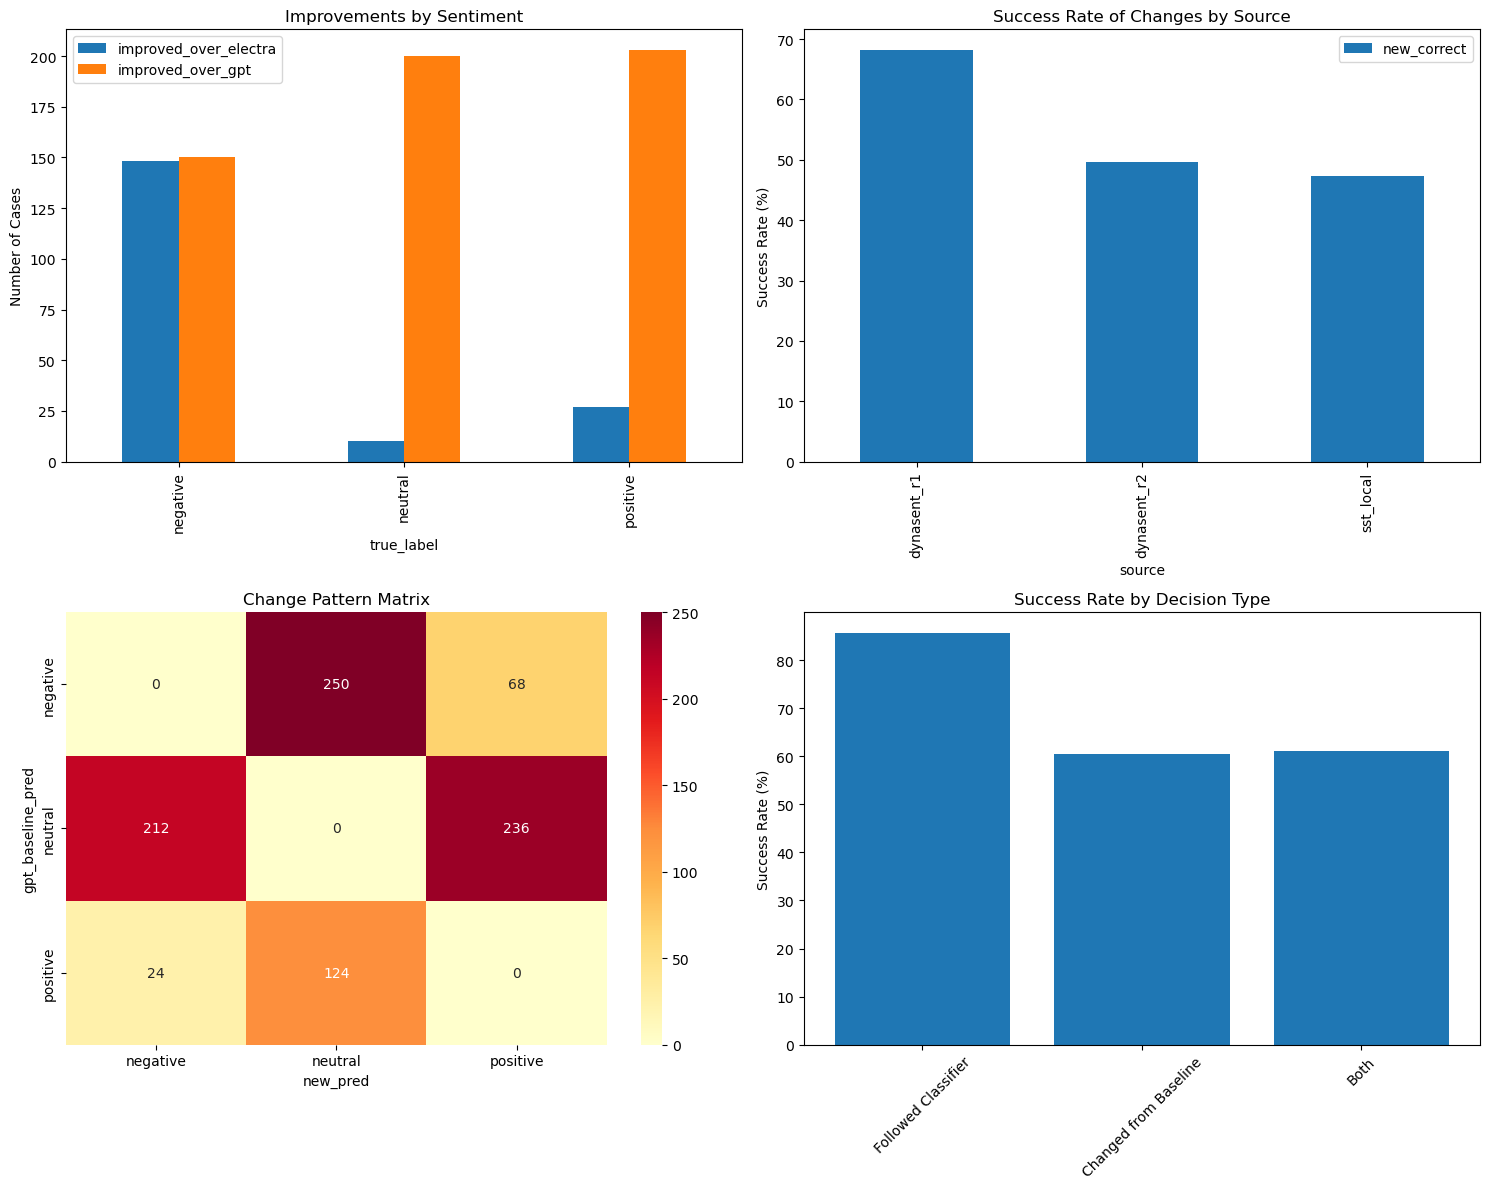

In [656]:
e13_g4om_elft_comparison_results2_df = analyze_prediction_changes(
    electra_df=e2_elft_results_df,  # ELECTRA baseline
    gpt_baseline_df=b3_g4om_results_df,  # GPT baseline
    new_model_df=e13_g4om_elft_results_df  # New model
)

In [646]:
e13_g4om_elft_comparison_results_df = analyze_prediction_changes(
    electra_df=e2_elft_results_df,  # ELECTRA baseline
    gpt_baseline_df=b3_g4om_results_df,  # GPT baseline
    new_model_df=e13_g4om_elft_results_df  # New model
)


Baseline Comparison Analysis:

Compared to ELECTRA baseline:
Improvements: 185 cases
Degradations: 103 cases
Net improvement: 82 cases

Compared to GPT baseline:
Improvements: 553 cases
Degradations: 300 cases
Net improvement: 253 cases

Classifier Decision Influence Analysis:
Total instances where model followed classifier_decision: 6202
Total changes from GPT baseline: 914

When changed from baseline and followed classifier:
Correct decisions: 547 cases
Incorrect decisions: 349 cases
Success rate: 61.05%

Detailed Change Analysis:
--------------------------------------------------
Changes from baseline when following classifier:
Total changes: 896
Of these changes:
- Improved over both baselines: 0 cases
- Degraded from both baselines: 0 cases
